# The goal here is to benchmark the DpoDetection tool with other depolymerase detection tools 
***
# I. Load the models :
#### 77 phages candidates 
>Detected Dpos <br>
>Missed Dpos <br>
***
# II. Getting the resulting predictions
#### Pires Dpos

***
# III. Make figures
***

I.
> Make the predictions : DpoDetection Tool :

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.S1.conv.model \
/media/concha-eloko/Linux/depolymerase_building

In [5]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

#esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.1907.LR5.4_labels/checkpoint-4277"
#DpoDetection_path = f"{path_work}/DepoDetection.esm2_t12_35M_UR50D.LR5.4L.1907.model"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.2007.3_labels/checkpoint-3784"
DpoDetection_path = f"{path_work}/DepoDetection.esm2_t12_35M_UR50D.LR5.3L.2007.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase.2007.3_labels/checkpoint-3784'. Use `repo_type` argument if needed.

In [ ]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 2)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs


In [4]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


NameError: name 'Dpo_classifier' is not defined

In [2]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

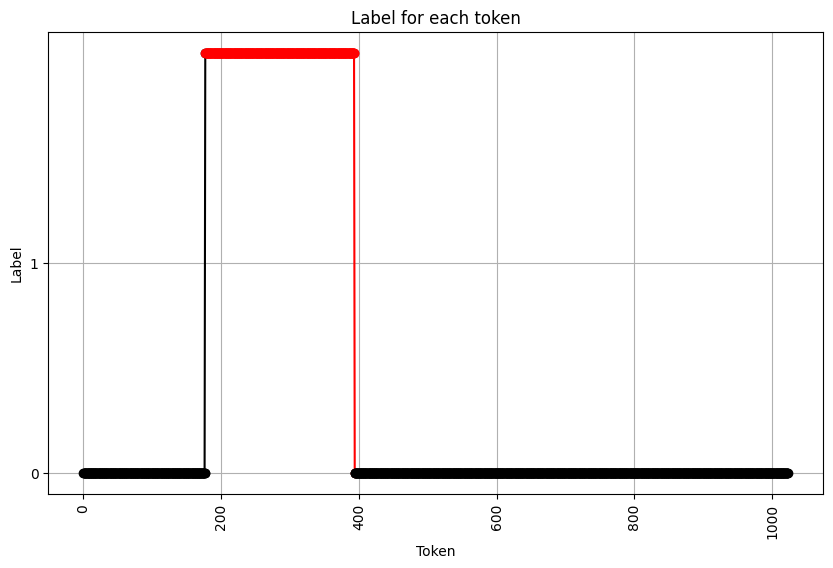

In [32]:
input_text = "MRTIKNLALPQDSDYVNFPDGRVRNETVTAAGTPVVEEVYGDLLQNFYKIIRSSGLEITETADSEGTQFQLLDALKIFANEVNDLKQTLTVNQGEISTLLNLDTLPDDYVFIGKITEDISANNIYLLNGTGEVLVNAVSTSDVKASSLVLVVLSQVGYSSITDLTVAAEDLKSLSVSLGTPLSFNSTKNLMYFSDGKIITDYPKVYDVQQAINDSLMTSDFVAIDCFTVKEKLLCYAFNKTNSTYHLFSFLASNPGALEGEVTFIKSVNAAENKPLIYTNGQFLFITNTENEFGDIASHNKIGKYLFDEVALEITLDTSLTIESSFFKSTNCFINEAGSDIYSMLLGQLNKYSLENNTVEDLGNFQSNNGQVFRFNKQTYFYNGSNAAKWNY"
prediction, sequence_outputs = predict_sequence(model_classifier, input_text)
plot_token(sequence_outputs)

(1, 0.9588682651519775) K2069PH1 cds_25, tail fiber protein


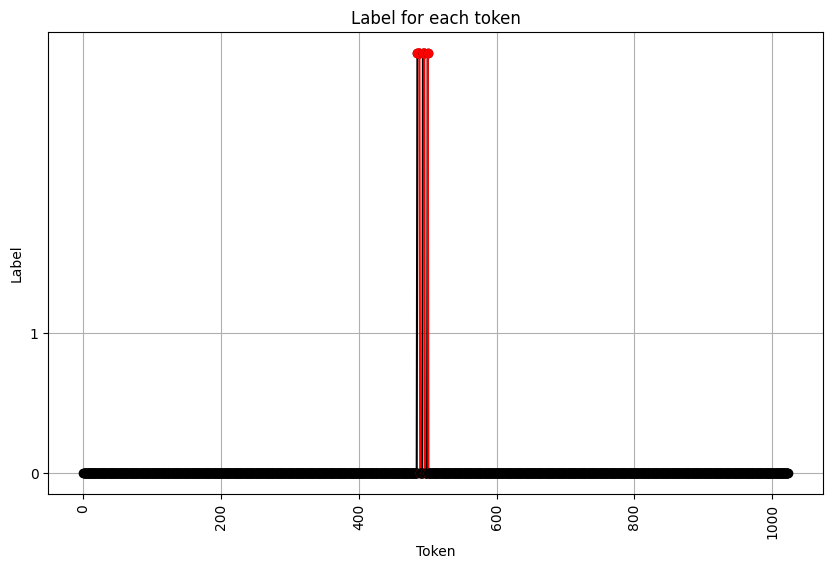

(1, 1.0) K50PH164C1 cds_28, tail fiber protein


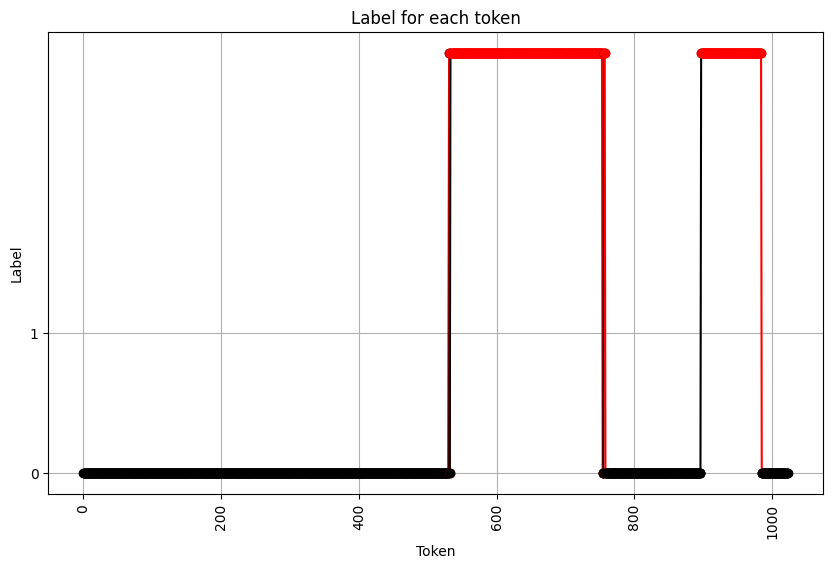

(1, 1.0) K29PH164C1 cds_25, tail fiber protein


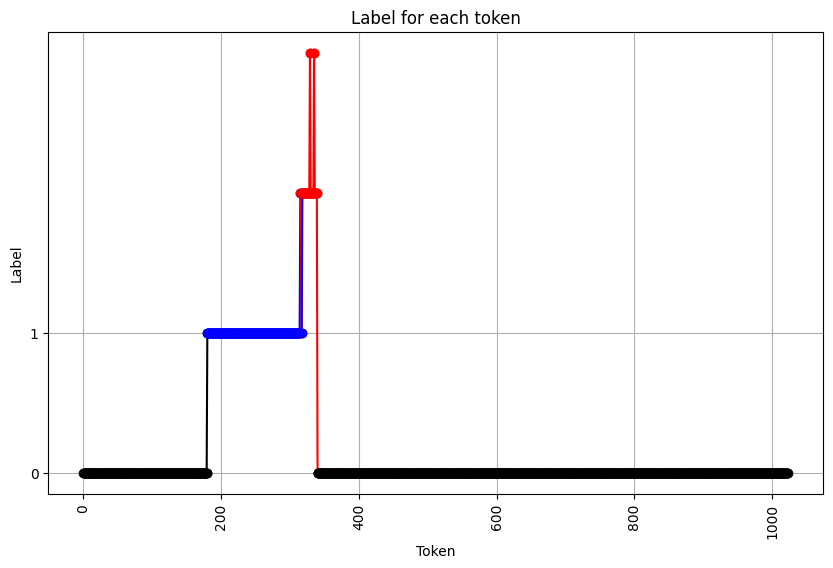

(1, 1.0) K62PH164C2 cds_25, tail fiber protein


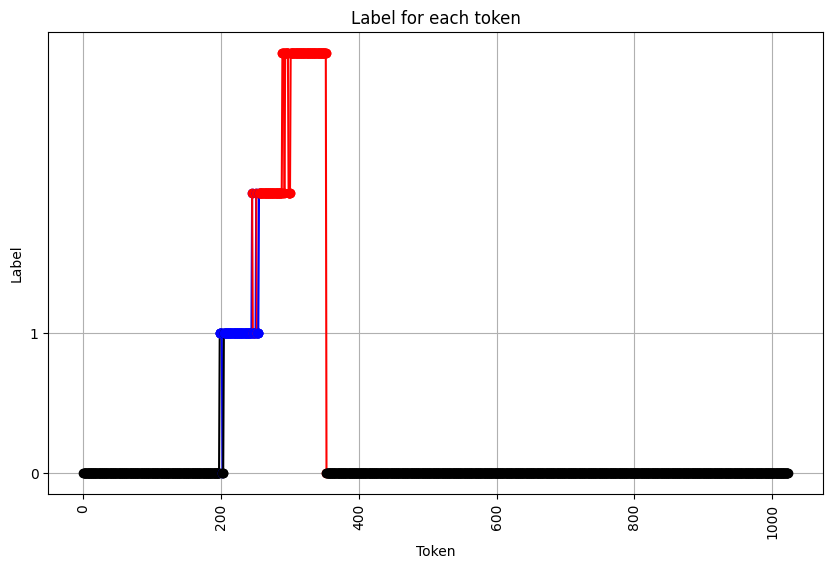

(1, 1.0) K9PH25C2 cds_76, tail fiber protein


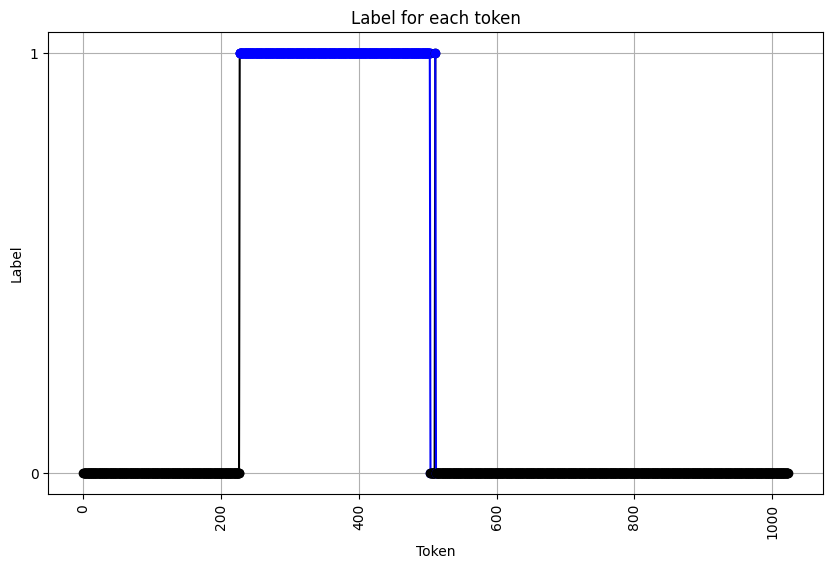

In [51]:
from Bio import SeqIO
import os

#path_fasta = f"/media/concha-eloko/Linux/77_strains_phage_project/DetectedDpo.77_phages.multi.fasta"
path_fasta = f"/media/concha-eloko/Linux/77_strains_phage_project/MissedDpos.77_phages.multi.fasta"
fastas = SeqIO.parse(path_fasta , "fasta")
n = 0
m = 0
for record in fastas :
    prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
    if prediction[0] == 1 :
        m += 1
        print(prediction , record.description)
        plot_token(sequence_outputs)
    else :
        #print(f"Good here {record.description}")
        n +=1

In [42]:
m ,n 

(2, 11)

4L model :
Not predicted : 8
Predicted : 5

3L model :
Not predicted : 2
Predicted : 11

> Make the predictions : Measuring the performances of DePolymerase Predictor
(https://timskvortsov.github.io/WebDePP/)

***
# VS Pires 2016

> Make Pires predictions

In [3]:
path_out = "/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking"
from Bio import SeqIO
from tqdm import tqdm 

prediction_results = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
        if prediction[0] == 1 :
            a = (prediction , record.id)
            tmp_results.append(a)
        else :
            pass
    prediction_results[fasta_file] = tmp_results
        

  0%|                                                   | 0/133 [00:00<?, ?it/s]


NameError: name 'model_classifier' is not defined

> Write the json file

In [46]:
import json

with open(f"/media/concha-eloko/Linux/PhageDEPOdetection/PhageDpo_Bench.results.4L.1907.json" , "w") as outfile : 
    json.dump(prediction_results , outfile)

In [8]:
class Dpo_model_pred:
    def __init__(self, name, tokens, prediction, sequence):
        self.name = name
        self.tokens = tokens
        self.prediction = prediction
        self.sequence = sequence
        
    def plot_token(self) :
        tokens = np.array(self.tokens)  
        plt.figure(figsize=(10,6))
        for i in range(len(tokens) - 1):
            if tokens[i] == 0:
                color = 'black'
            elif tokens[i] == 1:
                color = 'blue'
            elif tokens[i] == 2:
                color = 'red'
            else:
                color = 'yellow'
            plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
        plt.xlabel('Token')
        plt.ylabel('Label')
        plt.title('Label for each token')
        plt.xticks(rotation='vertical')
        plt.yticks(np.arange(2), ['0', '1'])  
        plt.grid(True)
        plt.show()

    def get_prediction(self):
        return self.prediction
    
    def get_seq(self):
        return self.sequence



In [47]:
from tqdm import tqdm
Dpo_class_objects = {}
for fasta_file in tqdm(prediction_results) :
    dico_tmp = {}
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    proteins_id = [prot_id for (pred , prot_id) in prediction_results[fasta_file]]
    for record in fastas :
        if record.id in proteins_id : 
            prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
            a = Dpo_model_pred(record.id, sequence_outputs, prediction , str(record.seq))
            dico_tmp[record.id] = a
    Dpo_class_objects[fasta_file] = dico_tmp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [03:12<00:00,  1.45s/it]


In [10]:
Dpo_class_objects

{'NC_020860.1.multi.faa': {'lcl|NC_020860.1_prot_YP_007675684.1_8': <__main__.Dpo_model_pred at 0x7f7dfc9bcb90>,
  'lcl|NC_020860.1_prot_YP_007675705.1_29': <__main__.Dpo_model_pred at 0x7f7dfa839910>},
 'NC_022771.1.multi.faa': {'lcl|NC_022771.1_prot_YP_008771399.1_33': <__main__.Dpo_model_pred at 0x7f7dfc4a7090>,
  'lcl|NC_022771.1_prot_YP_008771586.1_220': <__main__.Dpo_model_pred at 0x7f7df6c6eb90>},
 'KC821630.1.multi.faa': {'lcl|KC821630.1_prot_AGO49328.1_9': <__main__.Dpo_model_pred at 0x7f7dfcc69850>,
  'lcl|KC821630.1_prot_AGO49349.1_30': <__main__.Dpo_model_pred at 0x7f7df6c46b10>},
 'NC_027994.1.multi.faa': {'lcl|NC_027994.1_prot_YP_009168860.1_28': <__main__.Dpo_model_pred at 0x7f7ed7d3d110>},
 'NC_019923.1.multi.faa': {'lcl|NC_019923.1_prot_YP_007237187.1_12': <__main__.Dpo_model_pred at 0x7f7dfa4ebbd0>,
  'lcl|NC_019923.1_prot_YP_007237194.1_19': <__main__.Dpo_model_pred at 0x7f7dfc4b2a50>},
 'FR671410.1.multi.faa': {},
 'NC_018836.1.multi.faa': {},
 'KC821634.1.multi.faa

In [56]:
for file_fasta in Dpo_class_objects :
    for prot in Dpo_class_objects[file_fasta] :
        if Dpo_class_objects[file_fasta][prot].get_prediction()[1] < 0.90 :
            print(file_fasta , prot, Dpo_class_objects[file_fasta][prot].get_prediction()[1], sep = "\t")

NC_023557.1.multi.faa	lcl|NC_023557.1_prot_YP_009004812.1_20	0.8216886520385742
NC_019400.1.multi.faa	lcl|NC_019400.1_prot_YP_006986837.1_4	0.5977223515510559
NC_016071.1.multi.faa	lcl|NC_016071.1_prot_YP_004894049.1_242	0.5491459965705872
JX262376.1.multi.faa	lcl|JX262376.1_prot_AFO10887.1_21	0.7895899415016174
NC_027364.1.multi.faa	lcl|NC_027364.1_prot_YP_009150547.1_233	0.5915284752845764
NC_019917.1.multi.faa	lcl|NC_019917.1_prot_YP_007236803.1_57	0.8614856600761414
NC_027351.1.multi.faa	lcl|NC_027351.1_prot_YP_009148884.1_88	0.5491459965705872
NC_006883.2.multi.faa	lcl|NC_006883.2_prot_YP_214361.1_128	0.8492451906204224
AY349011.3.multi.faa	lcl|AY349011.3_prot_AAQ54994.1_59	0.8485224843025208
HQ632825.1.multi.faa	lcl|HQ632825.1_prot_AGN12459.1_301	0.8492451906204224
NC_019401.1.multi.faa	lcl|NC_019401.1_prot_YP_006987205.1_103	0.5021047592163086
NC_015296.1.multi.faa	lcl|NC_015296.1_prot_YP_004327542.1_171	0.8429854512214661


> Check if the hypothetical proteins could be scaffold of beta-helix

In [ ]:
path_download = "/home/concha-eloko/Téléchargements"
path_out = "/media/concha-eloko/Linux/PhageDEPOdetection"

In [ ]:
import subprocess
import os

path_project = "/media/concha-eloko/Linux/depolymerase_building"
path_pdb = f"{path_project}/phagedepo_out"
path_db = f"/media/concha-eloko/Linux/depolymerase_building/RefDepo_domains/RefDepo_domains_db"
path_tmp = f"{path_project}/tmp"

path_download = "/home/concha-eloko/Téléchargements"
path_out = "/media/concha-eloko/Linux/PhageDEPOdetection"

def seek_beta_helix(path_in) :
    protein_id = path_in.split("/")[-1].split(".pdb")[0]
    path_output = f"{path_out}/{protein_id}.out"
    #output_frmt = f"query,target,pident,alnlen,gapopen,qstart,qend,tstart,tend,bits,prob"
    #seek = f"foldseek easy-search {path_in} {path_db} {path_out} {path_tmp} --format-output {output_frmt}"
    seek = f"foldseek easy-search {path_in} {path_db} {path_output}.html {path_tmp} --format-mode 3"
    seek_process = subprocess.Popen(seek, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    press_out, press_err = seek_process.communicate()
    print (press_out, press_err)

seek_beta_helix(f"{path_download}/hypothetical_protein.scaffold.pdb")



***

# Get the metrics

> Get the N total of candidates 

In [11]:
# N proteins 
from tqdm import tqdm
import os 
 
path_bench = "/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking"

all_candidates = set()
n= 0
for fasta_file in tqdm(os.listdir(path_bench)) :
    fastas = SeqIO.parse(f"{path_bench}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if len(str(record.seq)) >= 200 :
            all_candidates.add(str(record.seq))
            n+= 1
# N = 4533
len(all_candidates)            

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 917.59it/s]


4533

> Get the M positive Dpos (dataset)


In [12]:
path_bench_dpo = "/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking_Dpos"

m = len(os.listdir(path_bench_dpo))
m

# M = 154

154

In [13]:
# Create a set of all the positive sequences : 

dpos_reference = {record.seq for file in os.listdir(path_bench_dpo) for record in SeqIO.parse(f"{path_bench_dpo}/{file}", "fasta") if len(str(record.seq))>200}
len(dpos_reference)

dpos_reference_dico = {record.id :record.seq for file in os.listdir(path_bench_dpo) for record in SeqIO.parse(f"{path_bench_dpo}/{file}", "fasta") if len(str(record.seq))>200}



In [14]:
len(dpos_reference_dico)

154

***
### Get the scores for our model : 

In [48]:
# TP : 
tp = set()
fp = set()
for file_fasta in Dpo_class_objects :
    for prot in Dpo_class_objects[file_fasta] :
        obj = Dpo_class_objects[file_fasta][prot]
        if obj.get_seq() in dpos_reference:
            tp.add(obj.get_seq())
        else :
            fp.add(obj.get_seq())

len(tp) , len(fp)


(118, 127)

(117, 172) #Old 
(118, 122) # 3L
(118, 127) # 4L
==> See if the 5 additional are legit 

In [16]:
predicted_positives = set()
for file_fasta in Dpo_class_objects :
    for prot in Dpo_class_objects[file_fasta] :
        obj = Dpo_class_objects[file_fasta][prot]
        predicted_positives.add(obj.get_seq())
        
len(predicted_positives)

240

***
### Inspect the FN : 

In [17]:
FN_seq = []
for seq in dpos_reference :
    if seq not in predicted_positives :
        FN_seq.append(seq)

In [49]:
with open(f"/media/concha-eloko/Linux/PhageDEPOdetection/Dpos_reference.T12_FN.4L.2007.multi.fasta", "w") as outfile : 
    for fasta_file in tqdm(os.listdir(path_out)) :
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            if str(record.seq) in FN_seq :
                outfile.write(f">{record.description}\n{record.seq}\n\n")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 308.32it/s]


MEVQGSLGRQIQGISQQPPAVRLDGQCTAMVNMIPDVVNGTQSRMGTTHIAKILDAGTDDMATHHYRRGDGDEEYFFTLKKGQVPEIFDKYGRKCNVTSQDAPMTYLSEVVNPREDVQFMTIADVTFMLNRRKVVKASSRKSPKVGNKAIVFCAYGQYGTSYSIVINGANAASFKTPDGGSADHVEQIRTERITSELYSKLQQWSGVSDYEIQRDGTSIFIERRDGASFTITTTDGAKGKDLVAIKNKVSSTDLLPSRAPAGYKVQVWPTGSKPESRYWLQAEPKEGNLVSWKETIAADVLLGFDKGTMPYIIERTDIINGIAQFKIRQGDWEDRKVGDDLTNPMPSFIDEEVPQTIGGMFMVQNRLCFTAGEAVIASRTSYFFDFFRYTVISALATDPFDIFSDASEVYQLKHAVTLDGATVLFSDKSQFILPGDKPLEKSNALLKPVTTFEVNNKVKPVVTGESVMFATNDGSYSGVREFYTDSYSDTKKAQAITSHVNKLIEGNITNMAASTNVNRLLVTTDKYRNIIYCYDWLWQGTDRVQSAWHVWKWPIGTKVRGMFYSGELLYLLLERGDGVYLEKMDMGDALTYGLNDRIRMDRQAELVFKHFKAEDEWVSEPLPWVPTNPELLDCILIEGWDSYIGGSFLFKYNPSDNTLSTTFDMYDDSHVKAKVIVGQIYPQEFEPTPVVIRDNQDRVSYIDVPVVGLVHLNLDMYPDFSVEVKNVKSGKVRRVLASNRIGGALNNTVGYVEPREGVFRFPLRAKSTDVVYRIIVESPHTFQLRDIEWEGSYNPTKRRV
(1, 1.0)


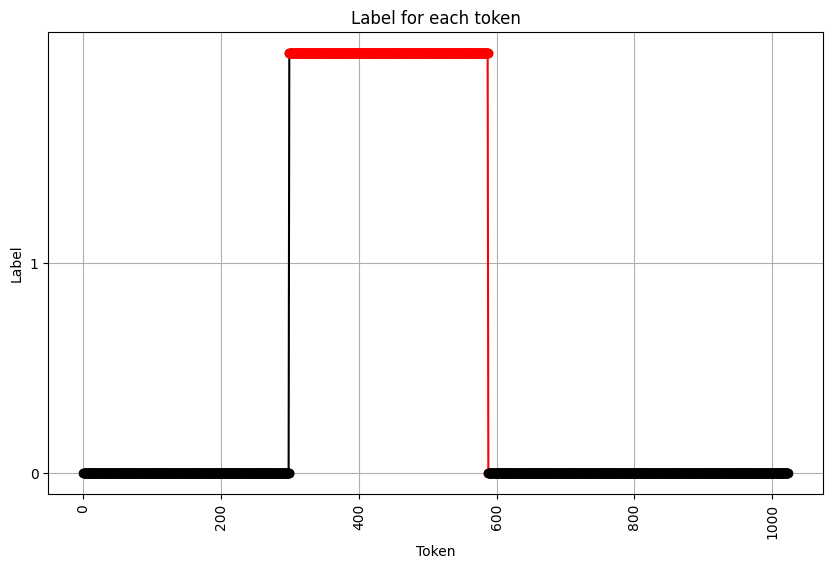



MATPFRIKRSAVPGKGPSVSDLQLGELALNTYDAELYTLRSRPGIGTEVVKIGGAAIENVLYVNKDGDDGNSGSTPADAKATLKAAVGIASEGTAIKVAAGTYIENNPIKVPKQVSIVGDSLREVTVSPQNADEDMFHVSPGDMISEITFSGTVDKGVAVIAFDPDKIQYVNQSPYIRFCTNRVANSIGLKVDGNKAVGPFKSMVTDSYTQYNVSGIGVSVSNEGYAQIVSLFTMNLDEAVSCHSGGQCDVTNSNSSFGNYGLVADGVGALQYTGTIASEAKENTDKFEVNLSTSSVNISNFVYDNVSGLATVTTSSAHGFNVGMGVTIEGVQLTCPYGTKTYPHQAPYVFTVDTVPNTTSFTTNIGISTLAHSYFGGGTAKINLIRPFDGKAVYFENEYNTIGKIKLTNPGSGYNTAPTVTIGDPSTSSTFGVTATALATIIGSKVDEIQILSNGRGYTSLPSVTISAPDVGINTATATVELLPTYYTVKESTPISAGICTITINETLPYSVGVGTTVPFFRQSRILASSHSFQYIGSGVDPINSLPSRGGVTIQENEVDNRNGGLVVYTSTDQGGNFRIGDGVQIDQISGTITGTSYSKSLFANVTPLILALGGE
(1, 1.0)


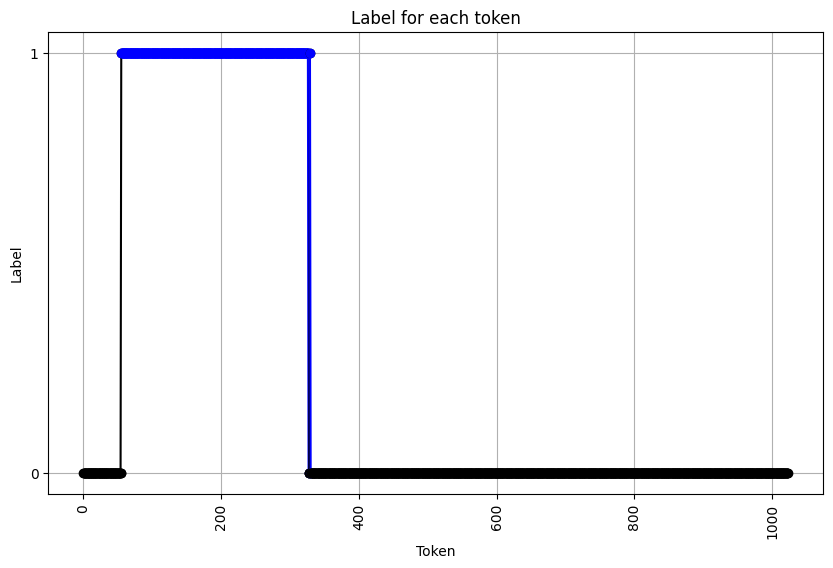



MNTPILTKYKFDPTGKDPENLIGGERHTVAAGPKNKIIAVFEGPFFSASAKVRLLDGSYLEPWVDFQPVHHFPEASKRTGKSCTCFIKILNESVNGDVFIEYQVVGGEFTFNSITLENLLWAIINDERSVLWDNINNRPATYPPSYHTHDIFNDTYGWDDRIAFSNWISDYLILGGERLNYEGFTNKVNVVLDEITTIQANILAQVAEHEADHTNPHADTAKALGYNKLQNLATANEVQALEGQRTDLRLTVKTAESILADAVKGYSVNLIHQGIIPVSRFGNLNFLQPGIIGSFEGASMVDAHDHYAQVVENDGTYIRLRPGTNGESIALYYDYATNIHRNINTFTITNTNNKYAPAGLDQAYIPARLFDCQGDVIAGIMYNKAALPATSDYKYWIALTNGTLDSTKHNCAQIGNAFFTMDDGSTQGFSPSWTQLCMVGSRIYVIHQNPNVATTMEVGGAISGNAIPQIYLGYINVADIVAGGSVTFTQITGWTTTFLGQARAAARSMQICDQVIGRSNQHVLVRYDGNQYVRAQYRSWPGGYGKMVANSDGTLTMLVDFTINVDGRNNSNISVYPIRFIIDVNAKTARPADTMNPFTVVDDTASTLKMTVVTNGSNLNYFKLRGVNDGTAALSGDYHGSRLITKKGFSICTSRQQASNVGMRIDIQQIPNFVDIDTYWRNPAAYTNLLFRTIGDGTSYGSEAKGNLRCPILFPNNRLGFWAFDGTNTFFASQPLVGNGDFVYKLIGLGTVSGFQPSNDRVRATVARPEREIITEINGSSVVTHCRAISDDAPTGAANIDPSLNTSGSISTDVNYLRAQGQRVLNQLGITAAKFRCILFVPTDGGMSLMLKIVGFTPAQANGITDMITVIATVTYNGARDGVLAGWTANLDDIVSKPQSVGTTDISRILTTFGLLTYKVGGEYIIAMGGFYCPYTVGPANNLPLVYMKMTNGRLSGNPSNMYLVSPYVDLLSNTPFALPGKGLFVTYSDNNYTVPVT

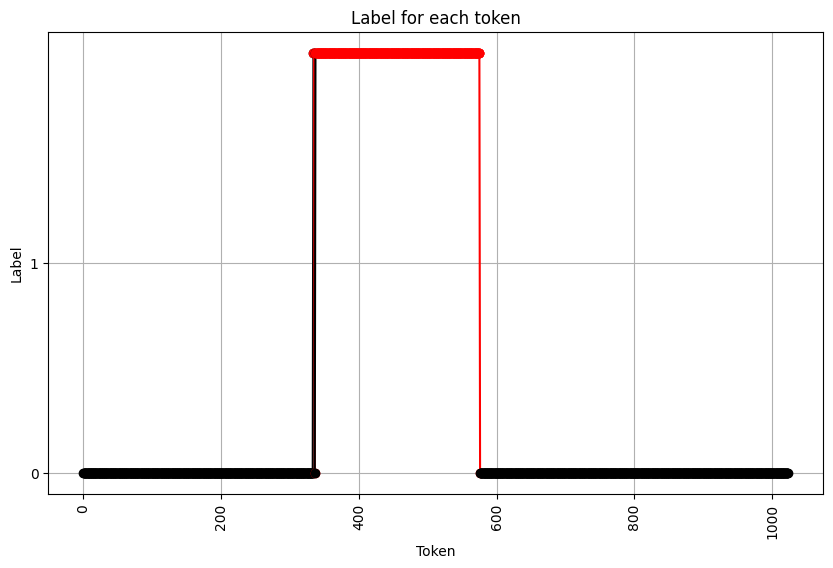



MDGNQLSKMGVTGSSFLDRWVLCPYSVDDFWSSLYCTIIRTKQGELYYSGTNSVFGISSSVSTWTRCESYFGSISPSSIKDIKITSSTSTNNSMLILTSDGQLYGIGMNGASELGTATTPITSPLLIDTSVSAIASSEMSRNFHYIKDGIYYRCGENTFYQLGTGDNNPITTFTALNLGSSHVIAVQATRWVTRLIVQSSTSALSLMVAGWNTQLTIGGSENTAIIRSSFTTNPYTDITANSFDKLSPVSYVNAIKSSTNIINTNGKGYNSNGAGLGRNAFSGNYGSILPIEFFDDSVDLSYVEWFGTIGNGSVSVVSIGEDLYWTGNPGYFTEQGETGYIYKFKKCIPFR
(1, 1.0)


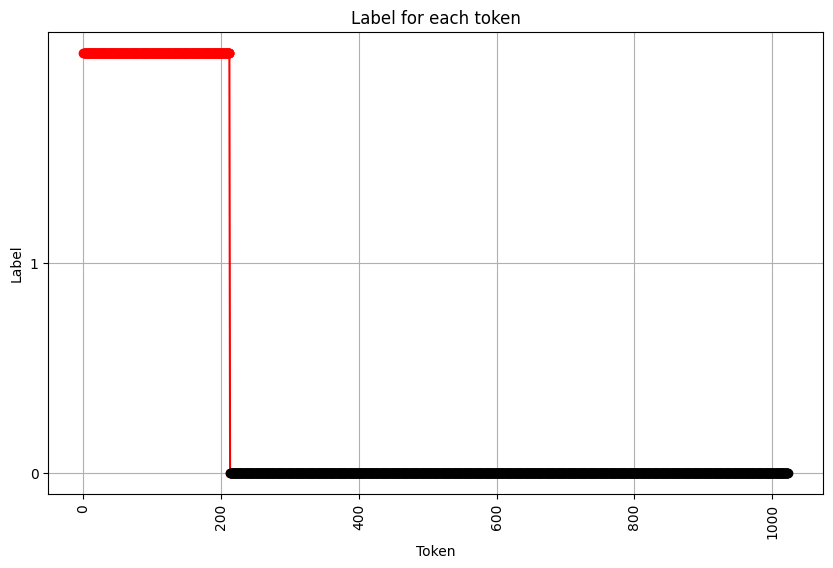



MPVLCTGFLICIKYSIMNKEGIMLPFARMIQYGNIKPVPVTPTIKDFKIGFSHEVLLDSAGDVWGIGYNTAGQLGFLDANTNSIGMWSKIYENVRLIGVTANYTVVVTNNNRILYAGNNLISNTTTFGWNDITSSMGAVVVDSIDALYCTDGMMHIKTADGSLYAYGRNMNANAGVTGVSGVISVATKVSGLPSAVKDIRYTFSYGTVLCQLDTTSVYGWGRNVNGELGQGNAAAVPTPSQRAGASIAIGTSYNATAIVSGTASLVTCGGQNDGQLGNGITTAGNVYTYGARAYPSDLNNIRSPVDCSTTYTSAFMSPDGIYYTGSNRSVFGGPSGTATVAVYTKCSDLPILYSNITQWCSGTIGGAICSSTELYQCGTGRYIAGDGQNATRYGFRKTPLPWDAY
(1, 1.0)


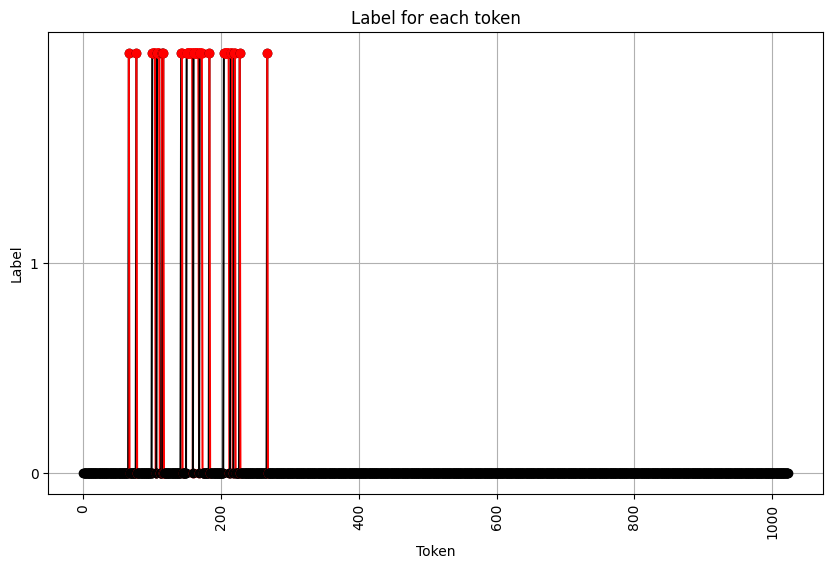



MRNIVLILLFFNISFSFGKDYCEDLYSNFSVYGVVGDGVADDTVALQLALDSDSNLLADSNSTFLVTSTLYLDTRLNQTVDWNNSTMITTTENLLFIEIDKRNSNGGTTIMKDLFIDANYIGMQGVSALSRVDLYNIDGINYIQGATASSSPFHIRTEFLTNDDDSYGEWIIDNCDVNGLRGYGNYCDYCDGLGAANGYLVYWREVPTVATTITFKNGSSLNGFGIDGQNVAVFSPSIDVSNTLANTVFDNITTKGFDRRGWKLFCGNITVKNCLIQDNPESDGVTTCGTTGTGLNCTQLGETGTSNLSAGLFTFGTGSGSTGSYNLLVENTTFVGELSGGTDNRVIFANTNDVSLNNCTFSGGADLALTTAIDDINVCNTTFGTSSTLYEYNMSTPYGTINLDIDNVYATTPSFTLTTINNTDINCDVTIVSTSQKNQNLIYWRY
(1, 1.0)


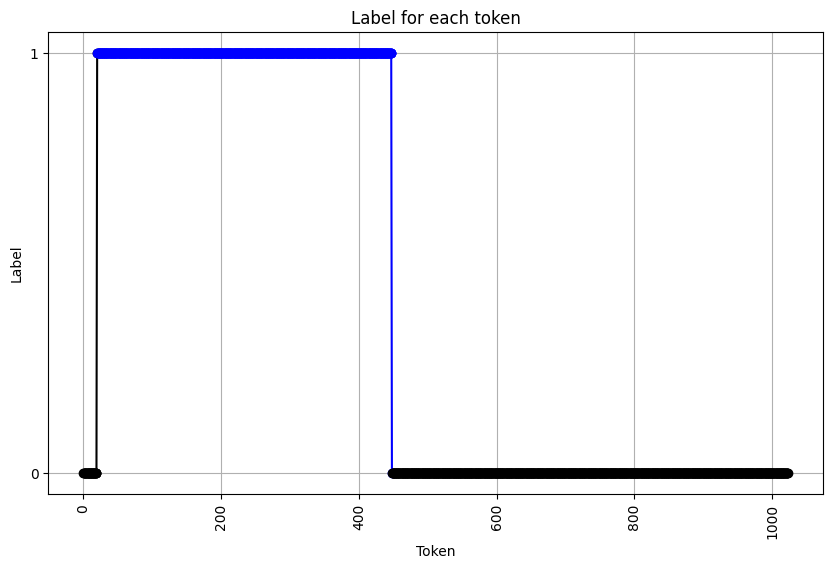



MADKGFGVKKINLIGASGTPTLTSPNNLNLNAVNVAISTDVSIGGTCTAYEFSGATASWMVGNDGTDNYTFIGSGISTQVNDPELNLYKGQKYIFHNRSSGHPFRIQITPNGSVGGQYNTGVTNNDGSAQTDIIFEVPQDAPDTLYYQCTSHTGMGGKINIVGVASDTDTTLDGKTSGTNVYLGTTAGAANTTSPGNEVGIGYSALMQSTGRDSTGIGAYALQNVNGYYNTAVGSYAGFSTTAGISTASDNSFFGYASGYQNNGDGNSGIGLRTLFRNIGTENTALGMYSLQDNINGSYNVGMGVYAQYANVSGSNNTSAGWAALSSNVSGNFNLVLGSNALRTITSGLSNAAVGSDAGRYLTGGSSYNTLIGNYAVGIGTTGSYVTAVGASALAKNIANFNTATGAYASLQNTTGALNCSFGAYAGENTTTGSWNNAFGYAALNDNITGVSNNVMGYFALGVSTDASYNVAIGYESLKSLKTGDYNTAVGHRTLDLQTSGSYQTALGGFALGMSTTTISNTAIGYGSQLQTIEGNYNTAVGNNSLRENIEGDSNVAVGDNAIGIGTTGSYNVAVGAYALEKIIVTIVLQ
(1, 1.0)


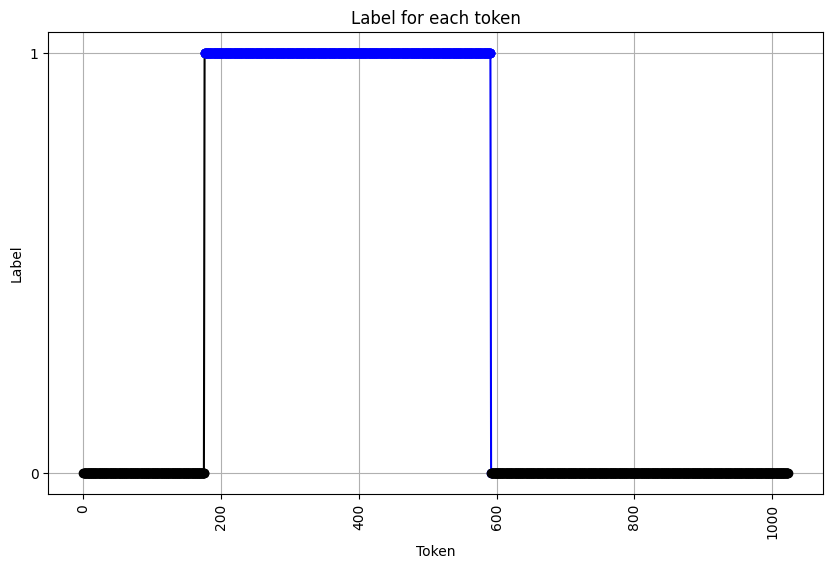



MRTIKNLALPQDSDYVNFPDGRVRNETVTAAGTPVVEEVYGDLLQNFYKIIRSSGLEITETADSEGTQFQLLDALKIFANEVNDLKQTLTVNQGEISTLLNLDTLPDDYVFIGKITEDISANNIYLLNGTGEVLVNAVSTSDVKASSLVLVVLSQVGYSSITDLTVAAEDLKSLSVSLGTPLSFNSTKNLMYFSDGKIITDYPKVYDVQQAINDSLMTSDFVAIDCFTVKEKLLCYAFNKTNSTYHLFSFLASNPGALEGEVTFIKSVNAAENKPLIYTNGQFLFITNTENEFGDIASHNKIGKYLFDEVALEITLDTSLTIESSFFKSTNCFINEAGSDIYSMLLGQLNKYSLENNTVEDLGNFQSNNGQVFRFNKQTYFYNGSNAAKWNY
(1, 1.0)


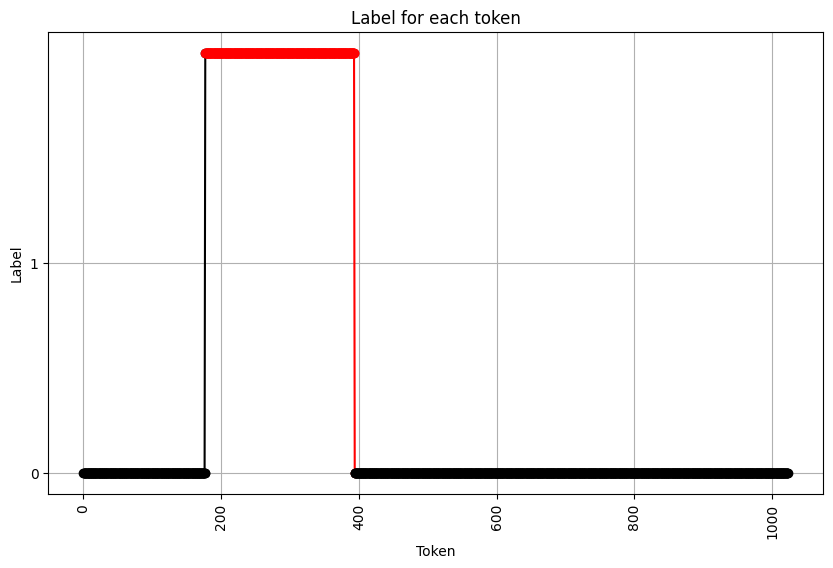



MNPQFAQPKGSTSKETNKDSIARKFGCKKSEVVYAKAGQSLSGYKVIYDKVSQRAYSLPSNIGAVTVTSLVDGILTHSGGTVDLNELAMTRREFITLQGDFVSGVTVNAKHEVIAYGNSRFRWDGDLPKVVPPNSEPVIPDWVNVDANPALSELAKSVGSSLVGYKPTGTTTTTGTVKGKLDSFIDFANDYCGGPITGQPDLTSQLQQAIIDAFNSGIADIKIVGDFYISGMILWYPGVRLIGGRYDSTLIRVSNTFPVGGTMFRSYRPPLWAAGCHGLSLENVYLVGRAAKDVYGIDINDASYFNLEGVRLDLFDKAISFNRWIDETRVDTSGTITYPNAHSAEMGGQSYFGTITRCYAGNCVTCVDFNGVVNRCTFISNTWTTSDLAYNFSNPRGVYETNTFITCNIEGVKSAFEWFFSINSPYHNVWINTSIDNGNPDITSLAKDGGRQTFIGLAIFPYGNPSLVNWYGINPNGHRSTVLGTDLGENLPEDQLKTQVREELHTLTGIANKQWAGQQVTETIPANGYKALNISVPGLKGNSAVIASLSAIYHGITVDAASNNTGTVSVIISNYTGSPIDVNAYLSVTGIAKSFL
(1, 1.0)


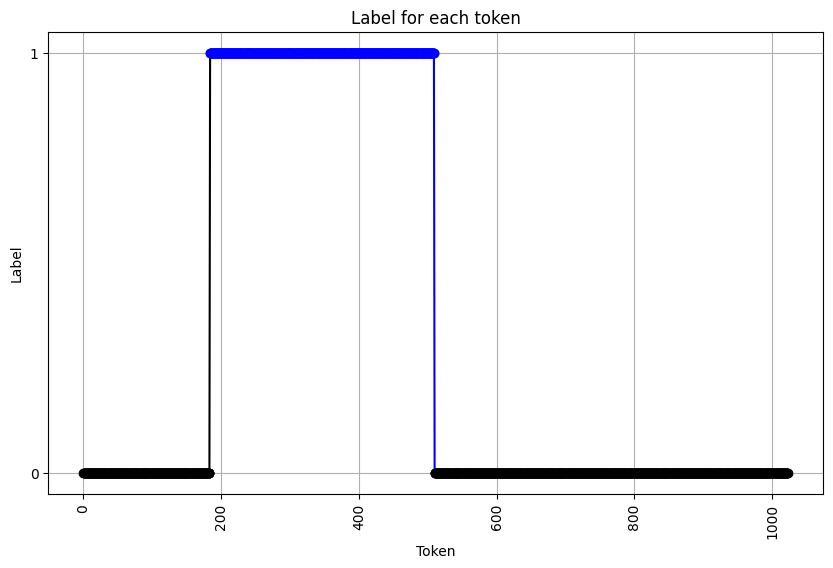



MSIRFNHATNTMTSTNSASIVVEGGTPSVPRPLRLNASSVVFPNKALPTGEAGAVVFDTASKTLKYHDGFQWVELLSQDEILEPIQISLTEIYNQLANRVSSVTYSSSAVPSASVSGTNLNIVFPTSSGGSGAAVPGLFTSSPPGSIMHYSLTSGQSVASIREQMSGVSGGQNGRNGTVSAPFVTKTGWCFADGMYWTWNGSDGAVTKVVPNLNQEAYLKGITTSGVTKTDAIITGSGTISSTSITMPEHYHGTGMMRGLGGDHGDDGVFIIGKTWNDGRTYTGAIITGDKQQYWTTAADGSDTRRAFTTTYPIYQSGNTSTHTHNLTGIDVGHFNVAVLYNIAEPSLALNQANGDARYVLKSGDVMSGSLTIANSAAIQANDTNLILWFRNASGGERGAIYHSTTTNTLRFRSAGGTEMALSNTGVLTVAGLTVSSQGATVGGRNIVRSINGSTADANGNVTLSITGGVVTNVRRGAEIAVNRYSLGDESFVYRCGEGQYVTGFNIWSKSNNNDEFRDMYSRPVQILIDGTWRTISDV
(1, 0.9930928945541382)


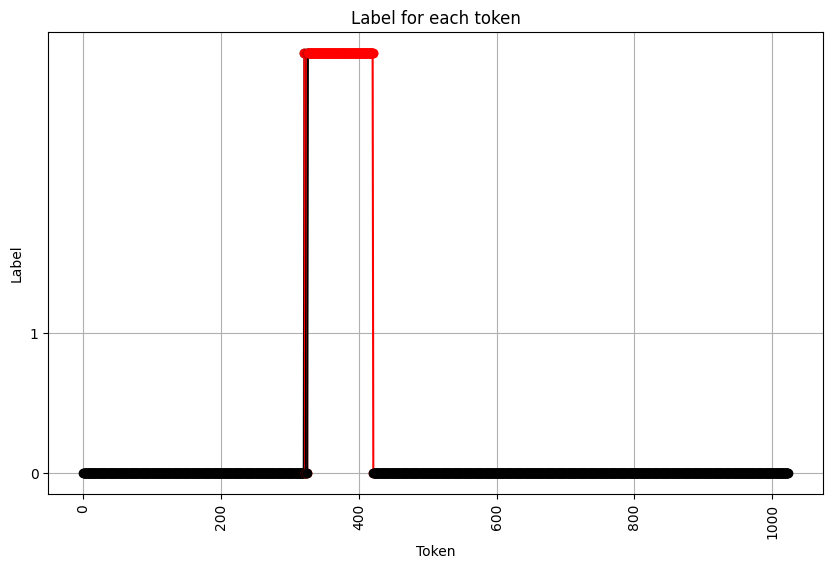



MLPFSRIIQYGNIAPAPGHIIKVQGSKFNQSNTIFLTSTGNLWAIGSNNSGMFGTGSSTALTQWTLIATNVKNFWCDSISSPGGVLLYITNDNKWFSSGIATALGINASSVMVFTDRTNIFGAVTYDNIKYLQLTYENINIVMKDGSMYTGGANGDGRLGLGNTNFGTFALRTDIGSVIQKARFNTTGTFYILRTDGTLAGSGNSTVFQLNPNVTRSTFINLNTEVLDFYVGTNNYFTKKIDGIYVAGTNNSGQNGNGSTAGTVTVPTLVTSIGNPDYIYSAYNSAVAYYNSTGEFKYWGDNTQGKIGTGSTSSYNVPTLHDKVLLPEFSHDETIYNDGWFINSSNSYILGTDNMIYVAGAIGTHTPGIGSNSYRFKPITLPLSI
(1, 1.0)


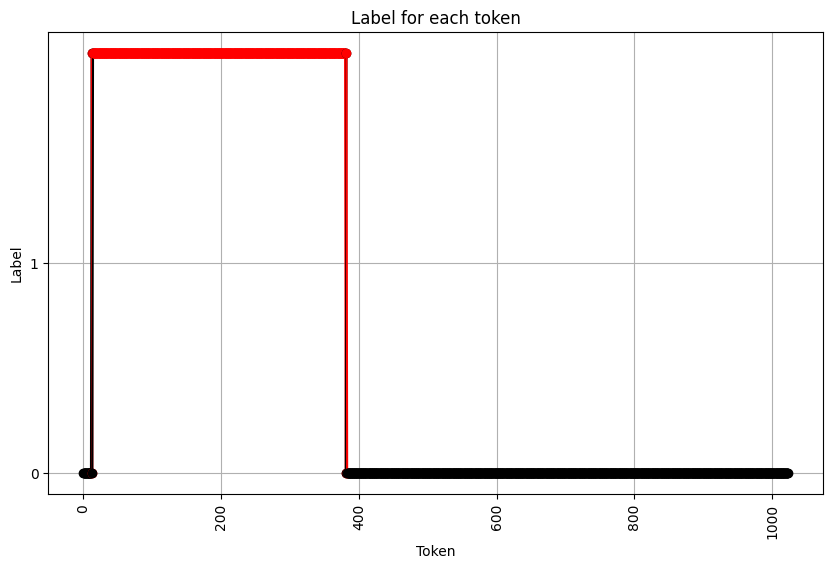



MARPKIQERTPDLLRVEPFLGLNVSQAAEQINDHQSPDLLNVIVSKTGNLDKRTGYKKAFTTSLGSGRITGMYLYRKIDDTKVFLFGWDTKLYKLENGAPVLLSSTFSGNELSFFVMNNKCYIQDGTKMQVTDGVTVSDIVPYIPTVSISKTPLGGGTPFEDFNLLGGGFKDSFSGDGTAKDYQLSFSGIDADKVTATVDGANKVEGTDFTVNRTSGKVTFTTAPTKGTNNVIITGYKRRQDLERKIHKCRINVLYGGANDTRVFVAGNVDLLNVMYGSGVNDPTYFPENRFYQIGADSEYIMNFAKQFDTLVIIKERSIWGMSFELKDGVPSYPTKPLNDTTGAVSRNSVQVLDNTPVMFNDKGVFSLTSSNVRDERNVSLISEDINPALLVEANKQNAKTIDYDRKYFLALNNRVYVYDYDIKSWYQFDNINACNFLEVDGRLYFGALDKGMIYMFMKPTDTYPYNDDGKAINAYWKSKLFTFDADELKKMVDKVFFSLKVGKASSADLYYITNKKYSNLIKNVEINGFMDFRFLDFNNFTFNTSAFPKEAAARIKAKKITHFQILFKNDRLNEGMGISSAAIKYRYMSYIK
(1, 1.0)


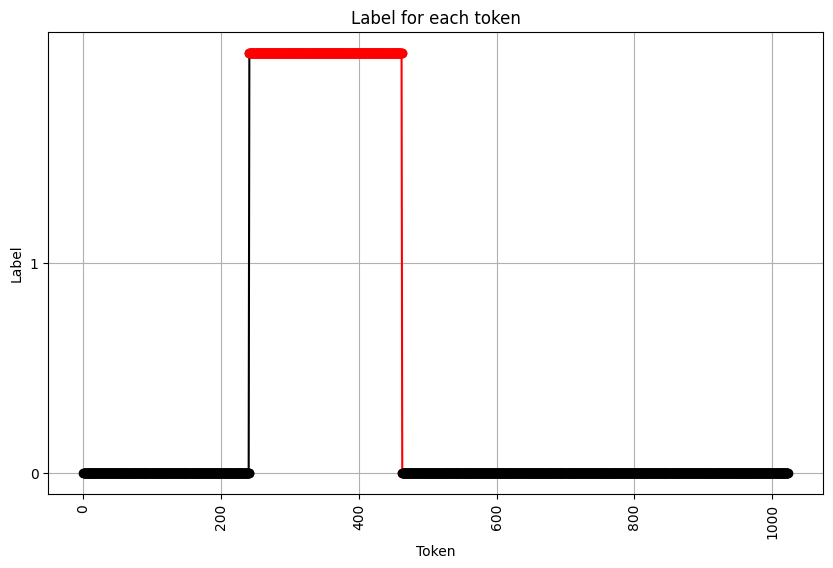



MADIKLKYLTDLASATGASGDDLMHINQGGNDRSITVTTLTGAIVNSIYPVGITIWFNSSSNPNSLFPGTTWGRLSGAGRTVRIANDNGSDVGQQGGSDSVRLTTGNIPAHNHSFSGSTEAYDHGTVNTANSGAHSHKAGVGAPGAQWEGFITGTDNSGWYSKNYTSTDGDHSHSVPIGAHSHKFSGETSSVGKAEQIDIKNSYTTQAAWTRVS
(1, 1.0)


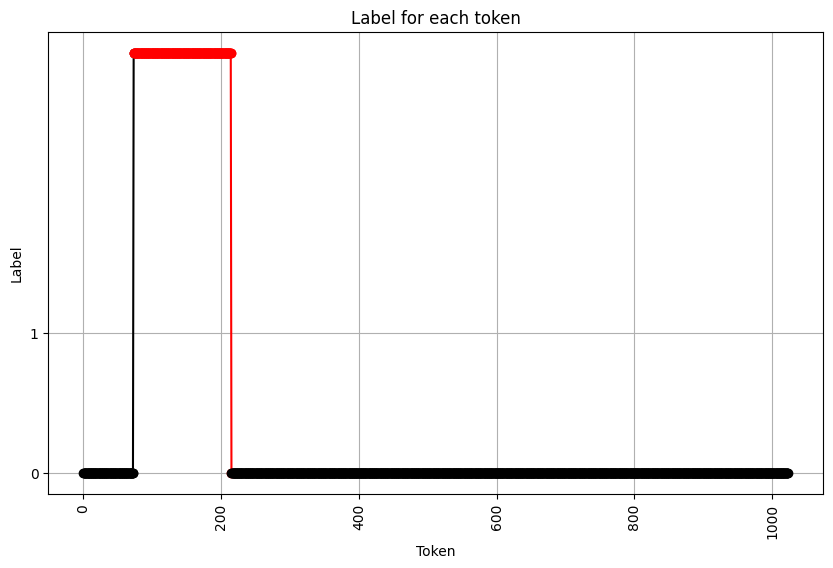



MASQSHGFDNTIVFGKETEFGVPAPNSSYGSLGVIEEFSPEENRNIVSRNSLGLRAPFMLRQGTNETDASVTLAVQNGKPFAFALGHVDSVENPDVEGGYIHTIRPTRAGEQLPSFTAQNHNALLNWTRNYVGGKFDSFTLTASSDDAVTFEGDILFATVEDSETAPVPVVLDTENYFMFYEGFAELNNQPFADVTNFELEIANNLERRYTLNGKNRADRVQEGNLEITASLTVDLTNTDVYNQFANGEDLNMKLTLQDQYDENHKIVVELLGGKYDSNAISLTATELQEQELEAVFTDIQITAHDTRPNLI
(1, 1.0)


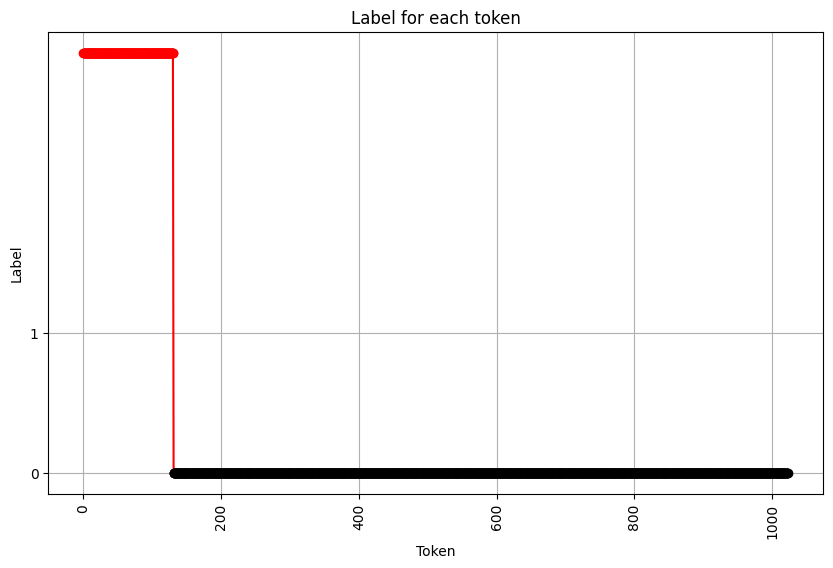



MKVPEVKEIFIYNGYSASVIPATALLLLYKNGDLMGIGGTSSQNYGFGNGVPNAKVKEWALIYQNVKRFRTAQGSFNLIQTEDNKFYYSGVGRAIGTGLSTVSTYTDCTSYFTSVFNATQLSQIKDIQIVGEGIFVLLQNGTLYGMGANTQGYFGNNTTTRLSTFTSINTNVDSVKTGSSAVIVQKIDKTLWVTGQNTWGSLGISNGETNVKVWTQMGALANNTVIHYELGGSASWVVSKHNTNNTYTVRASGIQSEGNLGNGSAASSGTVLSTISTLPISDNMEMKSNSLTYGGLTVKTNNSLYMCGINTYGRLGRGNTTSSTTFVVPVDAPKVGSIELFCPSECTNVYMDNQGDVYLSGYIPQATGTTVSDYYTKFQLYKIPSRGI
(1, 1.0)


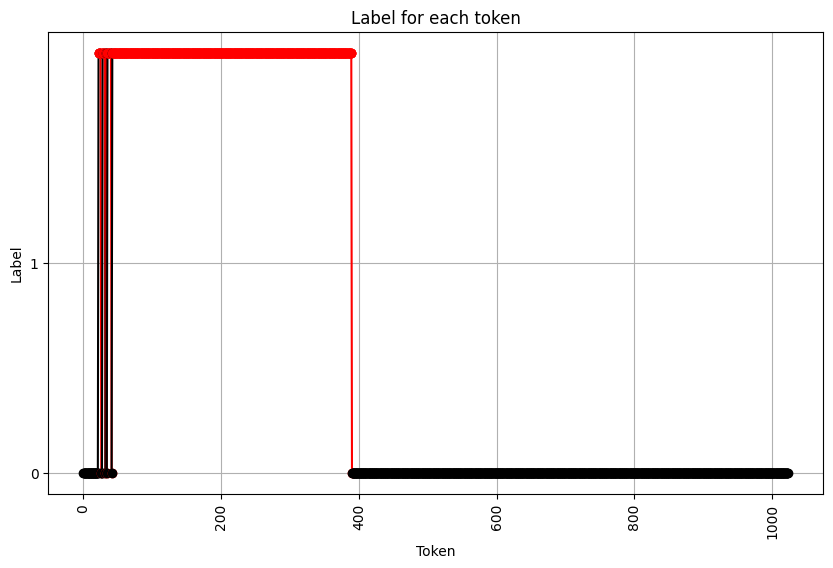



MVDIRPKGLPPAILPLRTGDAVIIDQGADGVRQTNPISFTDSVAPVATQSEAQTGSDNTKRMTPLRTKQSIASEVGVSIASKAQGDKADSAVQSVNGETGSAIVLDKGDIGLGNVDNTSDADKPISNATQTALNAKANASVTISAGTGLTGGGTLAANRTIALNSTSIASLAKADSSVQTVNGVSPTGGNVSVSAEEVRLQDSRSSALLESFAGSVNFVQTAGYNSVGDGGGALYRRVASEPVSVNKINNGDFSSDTGWVKGPGWSIASGKANHATGASGAISQAVAFVTDRKYRVTFTVSDRTTGTVTPQFLDGTAFAGTA
(1, 1.0)


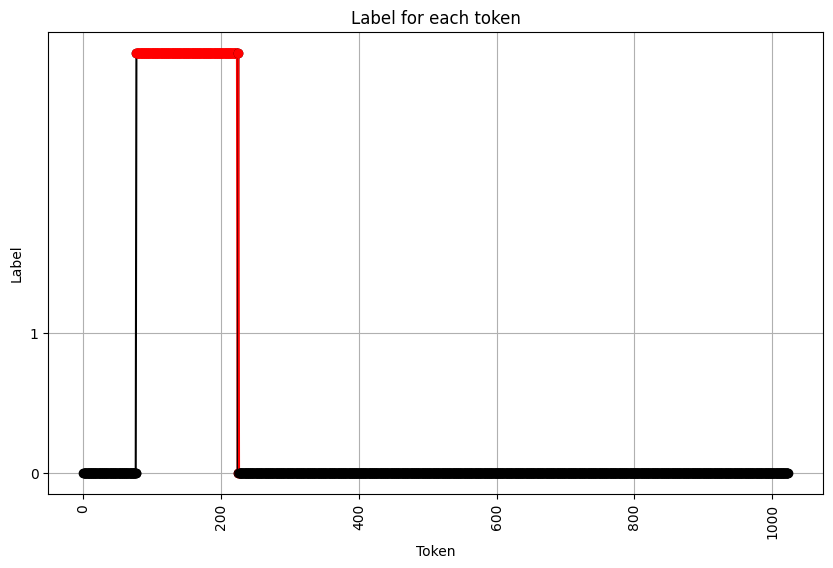



MNPRFTQPKSAVSEMTNLAAVSRIFGYETKNSEYIHVGLDIGSYKVVFDDTTSTCWLVKNATGNVVSYSRSQDTLVVVTSVGTFKLNRAKAVDMELLFKSEQHLQYYYDLLGNWDDAFFMAQVNVFLKGYSPRIILPVAEITITRPILNGVALGDKIHATYPELNFYNSTTGNYLAAWPLVIHGTYRKQQDGGLGGYSGSQIIFRGCNNRDDMTWTQWAIIHSGPNPTEVGQLRRTDTLLKNWPAFADLRDFNIRAINKDGVPISNVHGMYFHYGTQVSAVNMSIYQCYGAGVAVDNTWDSKFENLKVLQCGRMSPVFGQYVTDGNFGPQYQTYAPIHVMRSPLSDNSNFIRFHNCHVEDNMHAAVDVIVSGNSSPVWLTDLHVEAQTGLGGTTNNGQRTIVGLGNFGVTYFGQDAQPGYDYKARPDTGTGGNVVWTGGGMYSDTYSHIARLTRYSAFVLSDMVFPNSGNINVVGGNAAPYVYLSNCVVGDISFTGGNGSLSPLKASNCRIKSLTMDYTYGPQLSNCEISGAFNITNMYSNKPEGGVQLTNCNIGSMSGVIQFGQGIVTLTSTTDPSPFVVYYGHIDVSRYAYYNTNNLVGG
(1, 1.0)


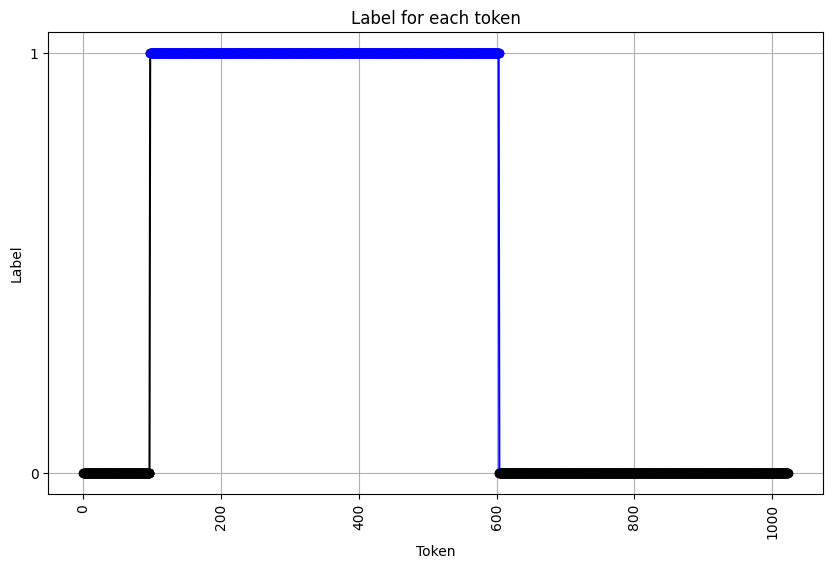



MAVNFPNSPSTNDTHTENGYTWKWDGTTWIIQSLAPPGPTGPSGPSGPSGPSGPSGPPGPPGPTGGSGSSTFVGLTDTPSTFTADKFVKVNSSGNALEWTDAPTNGLPIVNVADFGALPGASGATNRTSIEAAINSLASTGGLVYIPTGTYDITGTILIDQGVMGDGGGVSIIGPTQNYRITAADTEGVCLRSTDAGSDIIKVNNVRNVTFANLAFDHKEGTSRTGGNAVHFYSNVNTQQIRMDRIYIRRQFGAIKVDGHSIATFRDIEIRDIVNEGGSFGMLFSASAGGSERQDQIRCENVIIDGVISGSPHTSAVGLWVKDFVNSIWFLNCAVLRCNKGFLMDSTVPSGSTGNPGSFFRINDCDFDTNNSYGIEIAGGSFIWINNPYISSNFVNGLRVSSTFTGVLRVNAADCRGNRQHGIYIDSQDHKKIFIRDSQCSNNSATNTNQYDGLAFYDSNGTNQSDIHIDGGQYGGDIMGSTDGGNSTSTPQRYGIAAVNNSKYDRVTINNVDCTGNRTGTVQFNPNNGSDNYIHNVIGFHGTHSGAH
(1, 1.0)


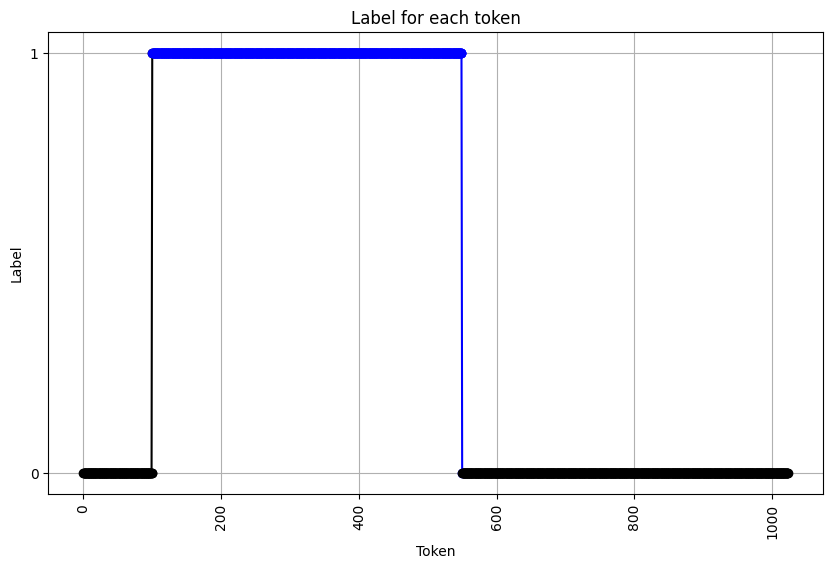



MFPIPIFTIMTSTGVVPLPAGIVKKVITLDYPDNAGNSNSSLAILLNDGRLFTQGANLFGEIADGTRSARFNNFHLASTVVADVFTADRCFVIKTNSGGWQYSGLTAGLVGSIAAGGTDACVTTWTSFPSVITGTISLANLKEVKGGYNNTLWLMNSGVLYGSGQNTVGSLGASTTNEVSTPRQITSAAVAFDAGYNQCSYVNNVGTLRVCGASKGLAGNNNTTTAFVNAKISATETVYVKDYINTVSQTIVVGDTSGGTGAVNYLYVRSNTETTYTKLDTFAAGFSTWKFPPSRHSFFVGINNSLWAIGKNYTANLGLGYDSASGDPLQVGKPVKPEGVGSWDINKLTSVHTLNMDVTNQLGYQGTFFVYNGDMYYSGIWKDGKASYLFNSGLNYNKFTPIASSVITGDILATGLTTDSLGICIVGGTKQLTHSVSPEGGKLFNIKYTSSAPANMTISSTGLMTFHAEGGFDAGMTALNAEGTTLSDTSGGYASTLSVYTPSLSAMDVGTTQTMVAEITPTGAASLPGMVVEYFSNDPTVATVDPVTGVITAVADGGCRIGCRATYQGVVTAEDSSYLTVNAVVIVMDYDLTQETIPADVKVNRSNRYARASGDILVPTESSAPVAPLEYVGTTPQGRRVVAANRTHIFINNNLTTASPWLKTNLTVTASTINSPVGTTANTYKLTPSTTSGQHILSAVNTASDITAGKHWAASVFLKPDGITKVKLKLTSGDEINEGTYDLVAGTFTGADANIIDMGNGWYRVILHKVTVAKQASITYEIIALNASGSDTFAGDGTAGLIAWVPQLEMGDMTNPVWAGTPFVCSYARDTTSAVTFTIPKNGHTGVDIYHTDGTVQREVFTGTATTWMLTFTAASADWGSKFITGLKYYD
(1, 1.0)


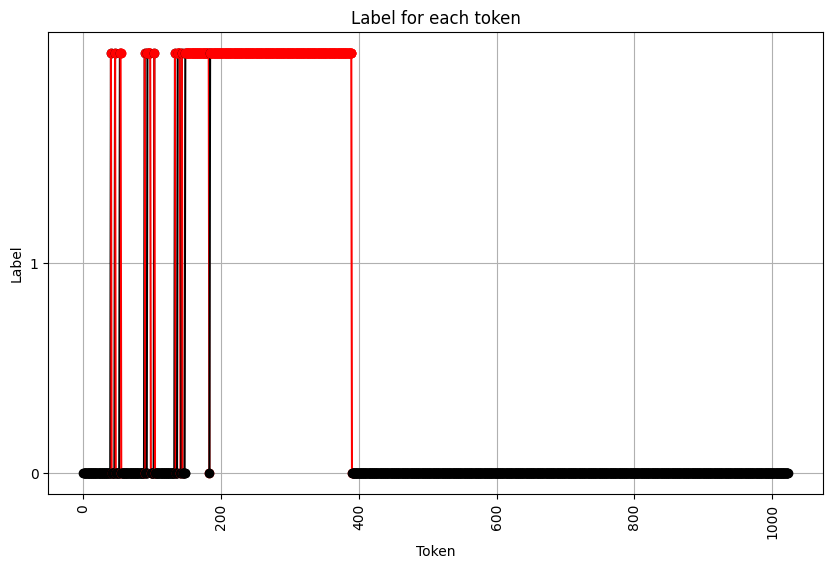



MASSLEGAYKSLLQGVSQQVPRLRLDGQVSTQENMLADPVTSLRRRPGAPLTVIHSLGTITDTNLYTQYVERGSDGRTLIINTSTGNWWVMNKDATAVLKSGQDAYFIASGGSSSLQSTSVGGETFILNIQQAPQAIASTTKRDPSTTGWYFTKVGAFDKDYTLTIQRGGTTQTFTYHTPSSTDANAVAQTSPVYITSQLVQQMQAAGIEVHQQDMYIYVVGAATLVVTSTSGTSYVGYSGRHNVALITDLPAVIPAGGDGILTSVGTDANALTWYRWEQASNSWVEDSSYGSPAALRNMPRVLAADDTITAPDFEGRLAGDDLTNEIPTFLDQGVITGMTTYQGRLVLLSGAFLTMSKSGNPYRFYRSTVTELQNSDRIDIGIGSSQNSILRRGIQFNRDLVLFGDAVQAVVSGGGNILTPSTAAISLTSEESCVSKIAPMQAGQTVLYPFKRSSGYSGMLELIPSQYTSSQYVSQDATGHIPEYFAGDVRVTAASNVVNMCVFTGSRDTSVIYVHEYQWSSDGKVQAAWHRWTMPQPVVSLHFAREKLVIFTADGGNVMLTVIDAREGYDNQTTSELPYLDLYTQVAVSGGQFVVPSQLRTPYTNGKQLGLAFATGTAATEEAGISSVNTNSWTGTVELGVPDGTYWVGIKYMSKFTPTPPILKDENGKEIGAGHVRLVRMEVAVRNTGMFNANVKDVRTDVDTTGDYTGLFMNSPELVPDYPLIISQANVIVPCRTLADTTEVTFSTNGTHDMNLLDISYLLRYNQRRRRV
(1, 1.0)


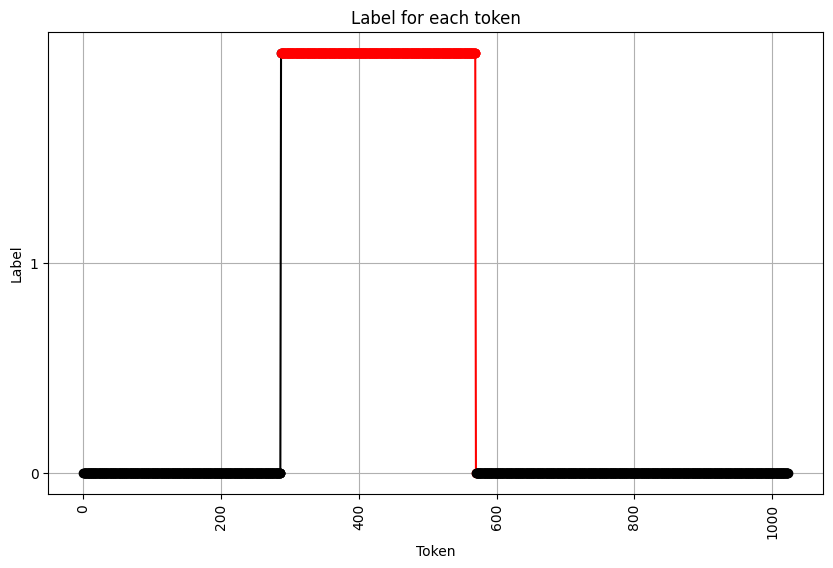



MLPFARMMNYGNIAPGKDRRFKIYSSDSMYLHDTYTNKLYASSATNWGTGTGVASSKFILCAENVKRVLLEDNSSSCQLYEEKGTGKVFITGNTKAFTGVTDTKTLWTDCTTWITSGGINVSDIKYMSSFNDMKVNLITNDGTLYCCGVNNNSNLSSFGDGTNINSFNTFKRVDTITSVKKAVGNIYLKEDNTLWGCGFNYYYQLGTGNQTSITGVTMISSDVIDFDVSYQSTFFIKSDNNLYACGKQFGAQYGNEFGTGGTSSSTDIQYKTPTLLSSGVYTLYTCVSNMASHIVKGDEVLYASGSNGFGQLGVGNNINQYSYTPSYTSFNSSCNLVRTPSGSLILTDTEKLYYCGYAMVVMGGIAGQNILSYTEVDMSFIQ
(1, 1.0)


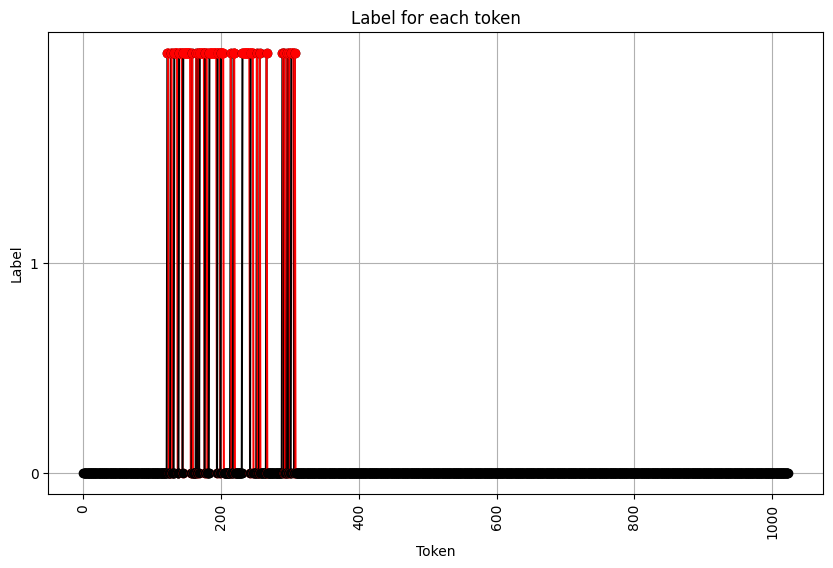



MNPQFAQPKGSTSKESNKDSIARKFGCKKSEVVYAKAGQSLSGYKVIYDKLSQRAYALPPNIGAVTVTSLVDGILTHSGGTVDLGALAVLREEYVTLVENFTSGFTIRVKNEVVSDGVSLYRWNGAFPKTVAPGSTPATTGGVGLGAWVSVGDVSLRSELSKEDGFKYIGYSSVEGLRSIEPSTPNQQIMVNRYNDSDAGKSGAGAFYYDPNDTTSADDGTLVIVTTNGKRWKRINPHNDFAYLSGGRYGDFDNTEAMQRCVDGMVSGKIRPPVYINGTIRIDGTVNVNNLDTSVPEKFVSFIGGEIVANGQQYVFSSTEADNASGNIEFVGTNFSQKDTSKVTYIINGQKLIRVLFNGGTVNGLLVAKSNNWLQTLYLTGTKIIRSPQGYALDAGQWFDVRLSKVVFERGWDFARATATGQCVTYSSVTECCIEGSQNGVVIIGGVSGFTFADNTLELMTGQYLDIGASGDKSNSLVVTGNTAYLTADQKASASYFAYNLPAITQNGTSLVQANFTDGNLYSVYPGNQQLISLSGMCGAGKVFLNAANGPTHVRYSLQYGEIERTISALGRDVGVGDVNPQTEPAYYGNITWSTGSYIAKKNPTVVSRNITALGKLADCLLKGWVCQIGGSPGTWVEDLMIL
(1, 1.0)


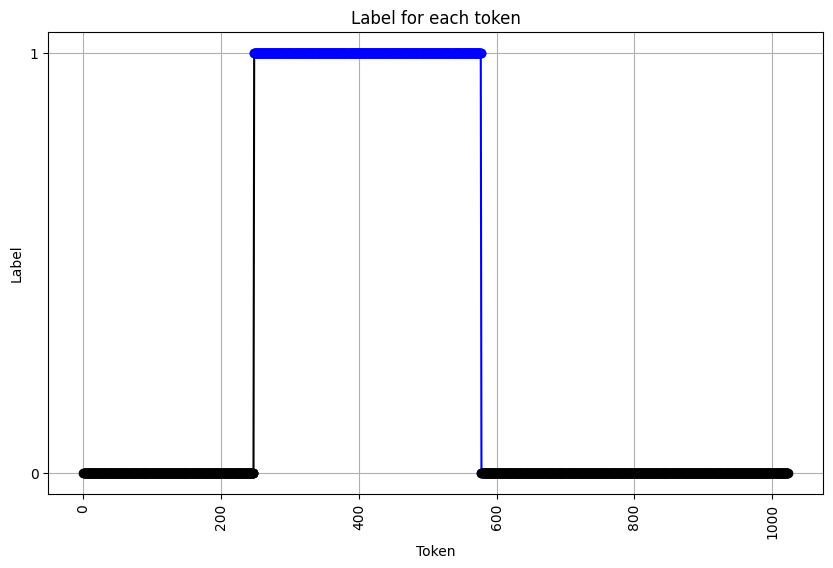



MANKPTQPLFPLGLETSESSNIKGFNNSGTIEHSPGAVMTFPEDTEVTGLPSSVRYNPDSDEFEGYYENGGWLSLGGGGIRWETLPYAPSSNLLEGRGYLINNTTGTSTVVLPSPTRIGDSVTICDAYGKFATYPLTVSPSGNNLYGSTEDMAITTDNVSATFTWSGPEQGWVITSGVGLGQGRVYSREIFTQILASETSAVTLNTPPTIVDVYADGKRLAESKYSLDGNVITFSPSLPASTELQVIEYTPIQLGNGGGSGSSTITWVYNGGSAIGGETEITLDVVVDDVPAIDINGSRQYKNLGFTFDPLTSKITLAQELDAEDEVVVIINGTPNIYNQIDYTLREVARVTNVKDTEVVYFSVGAVLSGYKVIYDKVTQRSYFIPELPTGTTAVSLSSSAILVHSAGSVDLGALAVSREEYVTLSGTFDSGAVINVKNELLTHTDGKYRWDGELPKTVVSGSTPTTTGGVGLGAWVGVGDASLRSELNSTNGAGIVTTTSGYTVQETFDFIKNVQQANLHPFVPSGDFGFGLPFDSSLQVFKYNDEYYSYKGPIAPGSIVPANPSSDSNWKKEPVSDYIENYGGGVHVADQTPAILKAIAAGVRHIIFPKGELRMSQCDIPEYTQGLTFEGQGANQAYTGTTVIKPLSDNQNCLFNSGVNKHGQDSIKFKNIQFDGEWRCNHAILHESGAGWYYEKLTGKNFNTWVIYDDQGLTVMRDVYTEATSSDLTKRATGGCIRIYSDSVMDTVNCYGGSVPLWLAAGGNRITNIWANGGYDVGAIRLMPKNDSTNHINTAMSNIYIGESTNTSSTAIPVLDIRGNSIRRVSGVQISNAHFVHADLTLNTNVVMIRTDKVDGFVMSSFDVLGRGEYSSASSRTYNFLNATDSTGMAFSAGSVRGINNNPIVLSSGSRLAIDAVEFDGWSTNSDSGIENKAAIRSSGAGTRCCIGSSCAFNASQADAYAVYAGDEFAVDISILNLNYPSSNIIIPANTNYSYMY

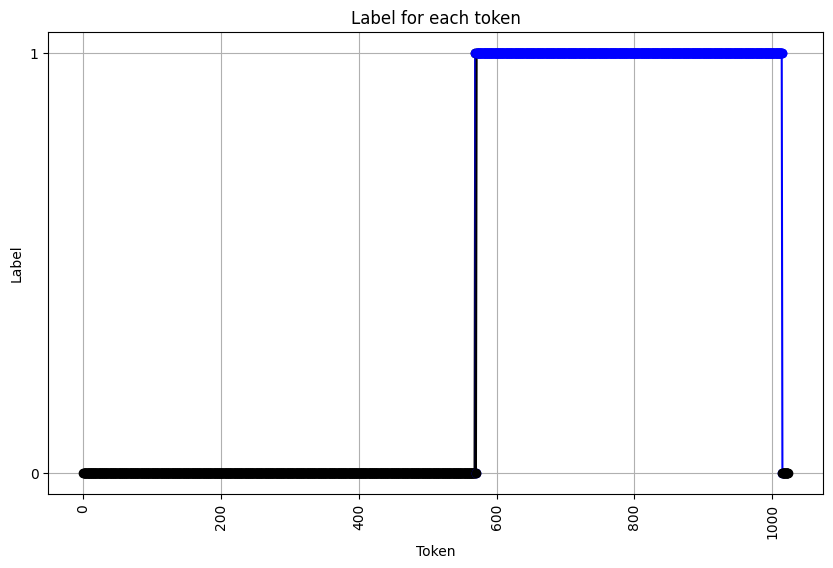



MSRDPTLILDESNLVIGKDGRVHYTFTAEDDNPKVRLASKCLGTAHFNQLMIERGDQATSYVAPVVVEGTGNPTGLFKDLKEISLELTDTANSHLWSKIKLTNRGMLQEYYDGKIKTEIVNSARGVATRISEDTDKKLALINDTIDGIRREYRDADRKLSASYQAGIEGLKATMANDKIGLQAEIKASAQGLSQKYDNELRQLSAKITTTSSGTTEAYESKLAGLRAEFTRSNQGTRTELESQISGLRAVQQTTASQISQEIRNREGAVSRVQQGLDSYQRRLQSAEGNYNSLRETVAGYERRISNQDNTISSNFTQLKTLIDQSVTLEKVQSLLRQSGDSIMLAIKDKLPKSKMSGNEIISAINLNSHGVQIAGKNITLDGNTTVNGAFTTKIANAIKIKADQIIAGVIDAAKIRVINLNASSIVGLDANFIKAKIGYAIVDMLEGKVIKARNGAMLIDLSSAKMDFNSNATINFNSRDNALVRRDDTHTAFVHFSNATPKGYTGSALYASIGITSSGDGVNSASSGRFAGLRSFRYATGYNHTAAVDQTEIYGDNVLIADDFNINRGFKFRPDKMTKMIDMNDLYAAVVALGRCWKHLANVGWNTVHGNFVSAVNGELNNYITKI
(1, 0.9999996423721313)


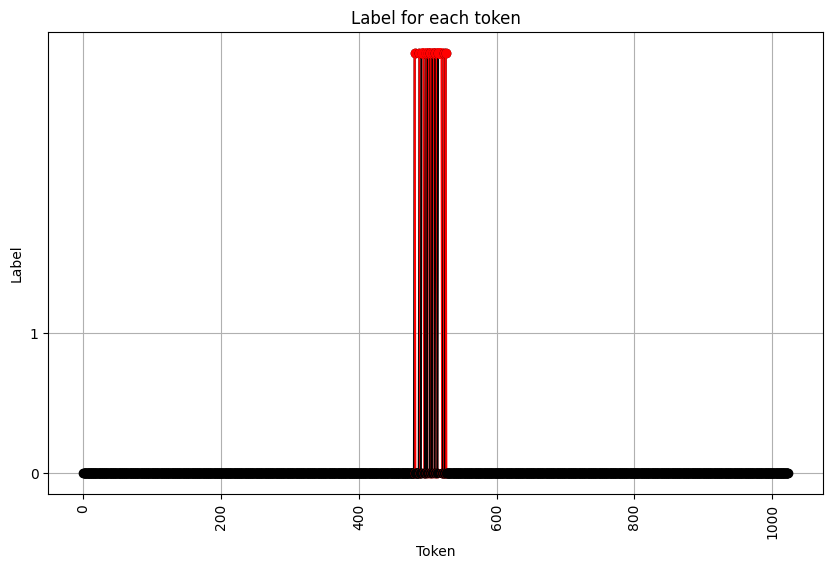



MISQFNQPRGSTSIEVNKQSIARNFGVKEDEVVYFSSGINLGGFKVIYDESTQRAYSLPSGIVSGTTAISLNEQAILTHSSGSVDLGELAVSREEYVTLPGSFNFGHTINVKNELLVHDDKKYRWDGSLPKTVDAGSTPETSGGVGLGAWLSVGDAAFRQEANKKFKYSVKLSDYSTLQDAATAAVDGLLIDVDYTFTADESVDFSGKVLIIECKGKFIGDGMLVWNGLGAGSVIKKPHMHTKTTPYTVYRFDANGNWVTDPTQVLASVQQRLDVGYKPNINDLDIWDDLPDNVKNQVAGATLRIMSGDNIIVENPEATFGGYLFTLCNRILVKNPRNFIALESGITFENHHTTAWGTGNWVVGGEIKYGSGSAVLFIRNDGGTDHDGGVRDLISYRVGESGTKTYQNEIGGRSARNYRLVFDNITTIQCYYDGIDVNADTGSPTERVDDYSLAEYPWFHLPTQHIIRNIITRDCMGIGAWWDGQKNIIDNVVTYEAHKEGVFDRGTNNDITNITVVGANKDLTNLNQITCEGGSRLRGINIHAYTTQGYAIYAPSSEVSNVSCAGSGTKKLLCTYISDIQGGNINVQHSANQMTLAMQPAMGGTTNPSLLMTADCQVATPGGEASIVKLSAIQEGVRVGEFQLNRLGFKHMSIPAAPLQLPESALEHNSSIGFFFGSDGALRLLAKKPDGSYVTYTL
(1, 1.0)


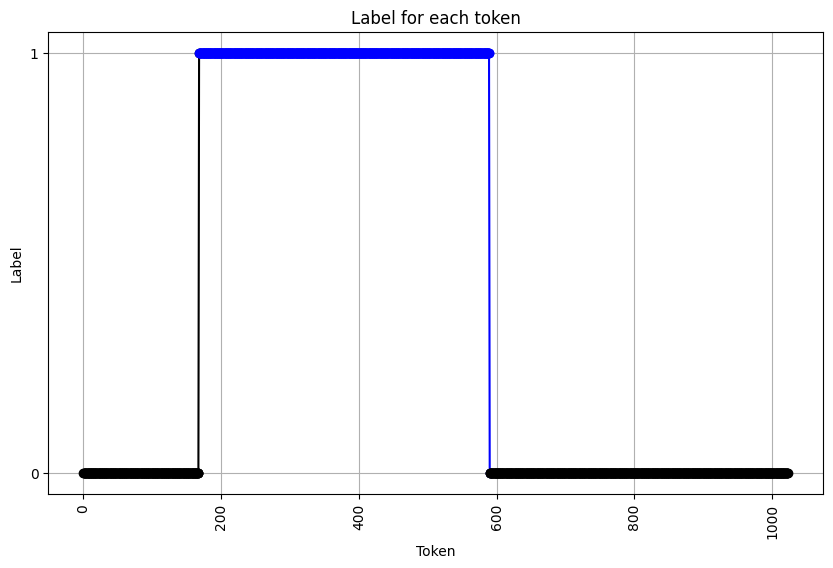



MTRNVEELFGGVITAPHQIPFTYKSNVGGETFLSLPFYPVTGVVTINGGMQVPLDNFEIDGNTLNLGRALSKGDVVYCLFDKILSPEDTAKGIRIYKFQAVGGETEFTPDFTSYGVQSLYIGGEYKTPEIEYSYDSTTGKVSLQTALTAGVWVVAEMSVKQPNISPAFDRSIQEIARSANVKDSEVIVSTDTISLLDGKKVIYDIAAQTSYGLPTIPDGSVISSVSGGKLNYNPGDVQVDLLPLPDSSQAVKLFYLQPSGAENIKVSSGDTVQDILNNINKHRVVSSISELLNISPTETPVVFVASFHPSTNYGGGFFRWDPSGNKATHNGGTIIDPGKTFPTWDSTGKTSWFTTSGTGTGVWRRHDVVGHYRAEDFGALPWNVGDAHDSTKEFQQVANVAYRGGCWRWTGRHRITSYIDIPNKQTFGSYAQMTSVYSELFQPSNFQGVHVISDPSLARSVQNAVFFDAATGEAFRCGEGASPTDFLVYGRGFTTTGMDLATSLPSAASYCDTQAFRHGKAINVRNVTVALMKYALDSNPWDASKGDYYSTTDHMTILYCYCISRVPTGQDITFNTKHINMRAYVNQIGDYGLAVRNVVFIGGSIEGYNTSTFLRSSTQLSFKGTYFETGDTSFNGTVFSLVGWCTLNFEECLVYLNNTTNFVSSGGSGQSAGVLGLTIKSQGNVWRKTDLGTTTVFAVDPVTNKQALVGSEILNAASGATIAYWAGAVPPGTYTAPISVAF
(1, 1.0)


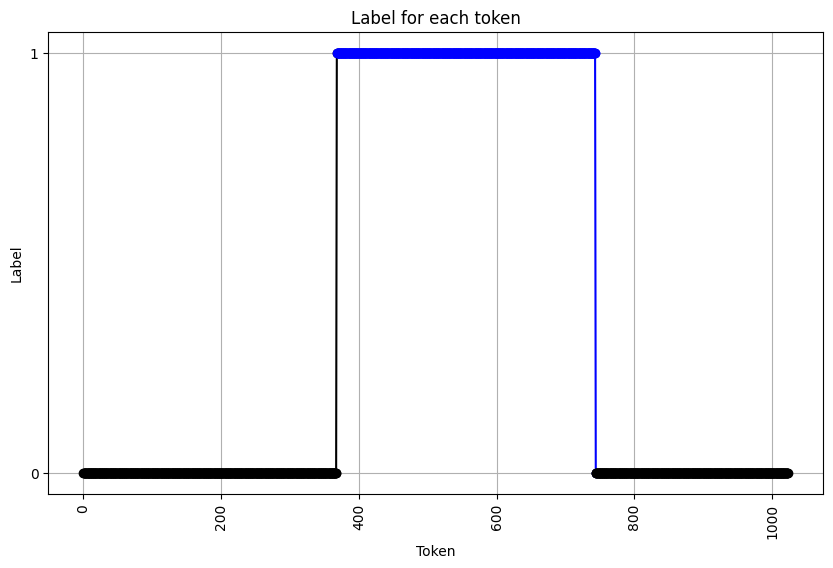



MTLLGTTYNGGELRDAVNGLATPGQALIDIPFPSSIPRSEFFLPNDFLGRLEDKGSDSRAYAHCNYTAEQIFDLFSTARSAPVNTFVVDPTSGNDTTGNGLTEGTAWQTIGKAILAANATGQPAKIRIKGGQGASIELPKSKNFANGSSSTTYDPTVDIWFEFYGGLLIVGSHVDFSTPSLHTGASFTYACAVTTADNALDRLNVDEDGMLTPFQYVPWVASGDIPPGCWTTDGTTTLVRRADNSAVTIANTRVIQRVRNFHAGKNISIGMGPATSGDVMILEGGGGGNGPFDYVVPTSDTNVTPRCVAVRGVRFHGYGFLTTGTGRAVTVDALHGLAWFEDCFFGRSKTDHQNIHNQRWQLGLGVKTRALFVNCVGRKNGVTVNAAGLSNPLSANAHTGHEDVITADYAGDYRDSGGGCVRSIDSSKGIFAGTMAHDRGDRRFAGTTPPTAFRADDDAQFFLFRVRTPQMSPGSYAYMTSGSGSAIYLRDCWPDRGARMGNVSTW
(1, 1.0)


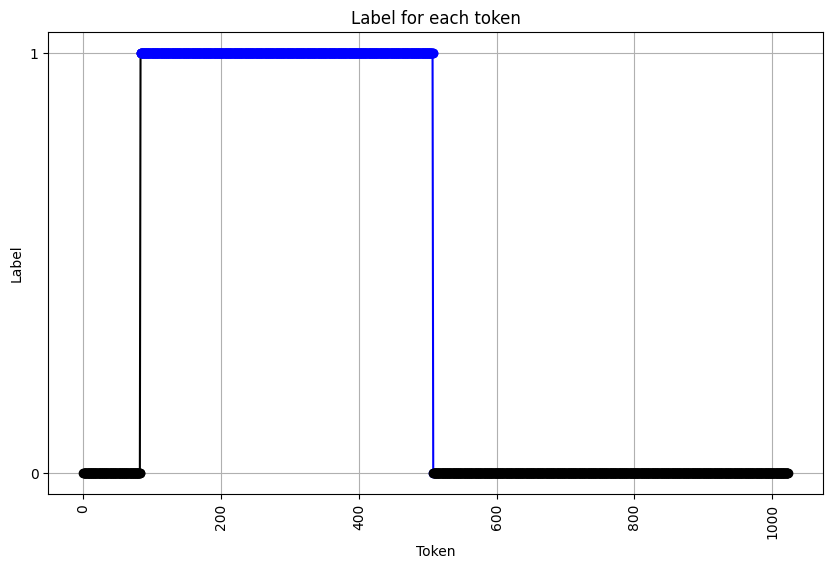



MEVQGSLGRQIQGISQQPPAVRLDGQCTTMVNMVPDVVNGTQSRMGTTHIAKLLDEGTDNMATHHYRRGEGDEEYFFTLKKGQVPEIFDKHGRKCNVTSQDAPRTYLSEVVNPREDVQFMTIADVTFMLNRRKVVKVSNRKSPKVGDKAIVFCAYGQYGTSYSIIINGTTAASFKTPDGGSADHVEQIRTERITSELYSKLQQWSGVGDYEIQKDGTSIFIERRDGTSFTVTTTDGAKGKDLVAIKNKVSSTDLLPSRAPAGYKVQVWPTGSKPESRYWLQAEPKEGNLVSWKETIAADVLLGFDKGTMPYIIERTGIIDGIAQFKIRQGDWEDRKVGDDLTNPMPSFIDEEVPQTIGGMFMVQNRLCFTAGEAVIASRTSYFFDFFRYTVISALATDPFDIFSDASEVYQLKHAVTLDGATVLFSDKSQFILPGDKPLEKSNALLKPVTTFEVNNKVKPVVTGESVMFATNEGSYSGVREFYTDSYSDTKKAQAITSHVNKLIEGNITNMAASTNVNRLLVTTDKYRNIIYCYDWLWQGTDRVQSAWHVWKWPIGTKVRGMFYSGELLYLLLERGDGVYLEKMDMGDALTYGLNDRIRMDRQAELVFKHFKAEDEWVSEPLPWTPTNPELLDCILIDGWGSYIGGSFLFKYNPGDNTLSTTFDMHDDSHVKAKVIVGQIYPQEFEPTPVVIRDRQDRVSYIDVPVVGLVHLNLDMYPDFSVEVKNAKSGKVRRVLASNRIGGALNNTVGYVEPREGVFRFPLRAKSTDAVYRIIVESPHTFQLRDIEWEGSYNPTRRRV
(1, 1.0)


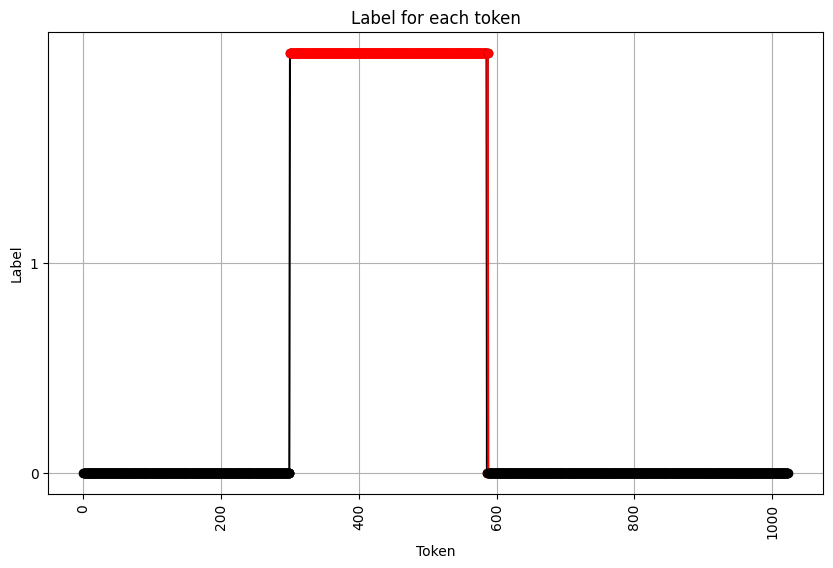



MRTFNGTSPDANTGIVQYPIYKRSEVQSILDMLPISRVGEMDYLPLNVSGSYEGATPMSSDQVVQPTIIEDDGTAVVLRSGTNGSTKGFYYSFIRELRNITMISQESVISTNSMYKPSIMSSTENIKYFIGSNGYEMLGCLSTEDNYIFTITNGTFNEISHIHAKVPSTSFGNDMPIYTHIVGTKVYIWCKDKSVSNLGLALSIYTVELSDVKASSMASLTKVTGLSGQTVRNTSYSASNNIRVFDKLYSVGTSSDSLFEVTSPVSRVEFSDYTDFNIQANVSPDLSKIRVTLYPTHRMVTPLYISTVYGTGISFVYNINSKSMSLDGSARAPATVSYNNGFQVSNPFEIDMVNFTGTTAAGVLGNAGGLCQTKDGLVFASKFRWSSTEFYGLQRYKVSGTPFDSWVASTRTASNVINANVLPVFGSAVGANLLGVRFIDNRKILLACSGTYDDVTYNYNNTVFSEIGSQPTYQYNSVQNNTTLNGFAPQSNRKQIGDDFTYTAMISLVDTDGSVRCYGTSFIEGVYKTSGGLLNPDTLEFDETYTIEPTVLESLKQDIFANIGNSGIVGTLSGQIVLYYVPDNTFSKSIAVVSAYNLNNNQGYAIYAEVDVVLSGTNITSATLVSTRYETLSSVTGIITEAYMKRCTGLTVAKYSGFGYIGVDAVHQFSQPGNAQFKMMIAKTVDGVITSNRFLSSSYIQLGAAYQHGVIPGVGFGYYNFQDSDYQTKSVFSVFGTTSAEMDGLISGNGSVKEKIVVVSQDVAQGFSVYFTREVPVFLGGIFDRLPIQSVDLSTVKSNPANTTFYLYIQMNRNTKKASYVISTETIDESLTSTYIGKIVTGTSGITSIDTEKVTRFLTYRPSTTKRGSAIPASTGVPSGPGTRWK
(1, 1.0)


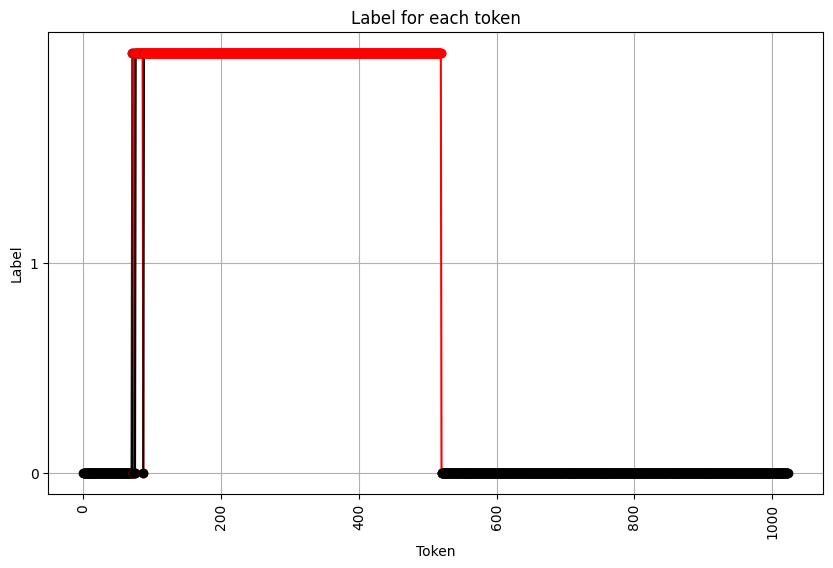



MALKLSNNSVSKLASSLTAGATSLAVLPGEGAKFPTLAAGDWFPLTVVKSDGSLEIMRCTARTTDTLTVSRAQEGTAALAFSAGDRVELRFTNAVFAVLAQIDGAPAFSQLTVNSQGNATNPFTVNGATNTNGAGIFLIGNGATTPNKTIRSHNGKLEIVNSSYGAVIWSLADTGSMDAAQRPTWAGFTPWDTGNFDPATKQAAGNYAKSTNNTVTFDWGTHQVGQLGLTIDTIYQGYLWHSGNFNPANYAIKSVHQDNGNINGSVWGGLLSDYLAAQLSGKQATGNYMRGITGNGFTVGWDSGSNHLNFFVDNNLVGFVVSDERAKKNIAPSAADALARVNALDFVEFDFIDSPYLPKKHVDNGVIAQQARLINPNWIDEPPADHPDAYLGLNLQYLLLDAMRAIQQLSFKVEELEAELTRKA
(1, 1.0)


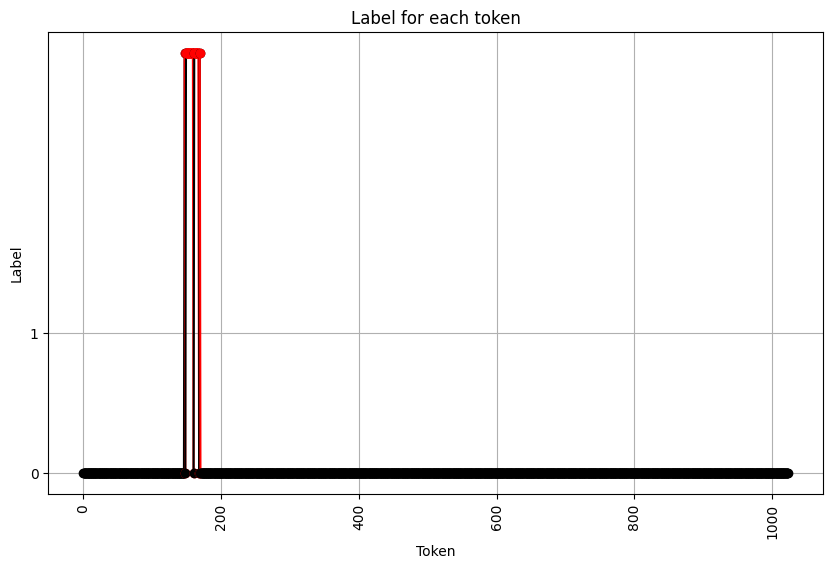



MTRNVEELFGGVVTAPHQIPFTYKSSVGGETFFSLPFYPVTGVVTINGGMQVPLENFEIDGNTLNLGRALSKGDVVYCLFDKILSPEDTAKGIRIYKFQAVGGETEFTPDFTSYGVQSLYIGGEYKTPDIEYSYNSTTGKVSLQTALTAGVWVVAEISVKQPNISPAFDRSIQEIARSANVKDSEVIVSTDTISLLDGKKVVYDIAAQTSYGLPTIPDGSVISTISDGKLNYNPGDVQVDLLPLEDSFINVINTLGRNDGAKYIGECHSVADLRNTEPTMDGQRIILKQHTAGTLLGGGVFRALIDGTGKTDDNGTVIKTVGGAAWLRVNADRVNPFMFGALGGSNDDTIPVQSCVDSGKATQLTGIHYVSNIQLKYNTSSIYGSGLHYSRLHQLPSATGNCITIKDTCSLIVLDSFGVYGTGAQQGTSFTAGTTGIYIETPSGLSADYPFHTTADPRRDLCISKVHIAGFDEYGLNIDSGNFSVTTDSLLVNHINQVGVRCATTDWTWTNIQVNTCGKQCLVLDGCGNGRIIGGKFIWANWQPYGTVGQFPGITINNSQNMVINGIEVQDCGGNGIEISDSYSISMNGLNTNRNGINANNTFYNIVFNKSDAVINGFVGLNYAANSGSGANSSAGNFQFLSNDCSVTINGVVETGYMGINFIGDNNIINPTNSDLSINGLVNYSKTGLQTMNETPTFDGVSTTPVYVSVPSSVGQVNGLRLSQANKDKLLYSRTAGPEGITMAAVVVPTISGAEVFNFMAIGSGFSDTSNSLHLQLVIDASGKQTIALLLGGDGTTQILSGDLPNDLKLQSGVPYHIAIGAKPGYFWWSILNIQTGKRIRRSFRGAYLAVPFNSIFGLTSSLTFFSDSNAGGDACSGVGAKVYVGMFSSENDYVASRYYNLINPVDPNKLISYRILDSSI
(1, 1.0)


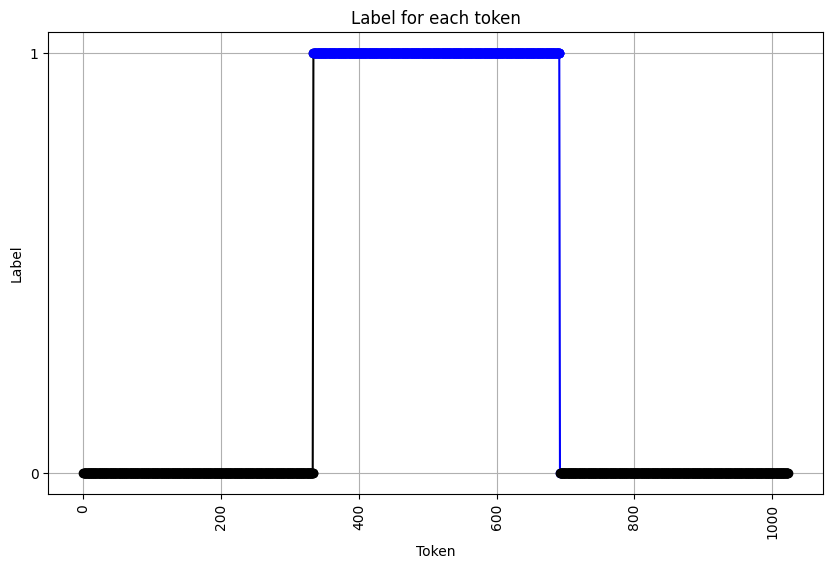



MAKVGGSYDSVVLGVSQQTPQDRRSGQMWEQVNMVSDPVQGLTRRHGSVFEAKQDLKAGTVNTNWLREAAVKFKVRPFSIGGIDYDLIYSNEYVRGNITEVLPVYCYDKTNKKFLPVRGSGDVWGALVANGASAVVNIGSYLFLSAKGYVPQYTTTTKYTPDNERKSIAIWVRNGDYSRDYNFRFTTTAGTTFLAAVRTPASTYPGKLDTSGIPVPVINMAGIGDSGSAEDTMKLNKAIADFNSKMAQYNKQIADSTNGYNSAVTQWLGTASAAIQPEQIAIQLTDQIRSKAGLTAQQVQRDGSYIFITDAANVKTGECVAVSDAYLKAVVNDVAKPDDLIPKHFFGKTVKVRSQKATGKDAYYLVAEAKDGQSGLYGDVIWRETAGVQTTPTKVFCVGTIANGTLFIASDPASLESAAGITGVPRFVGSQVGDQISIPVPNFLKKGISYMGVFQDRLLIGTGSTVFASRPGDYFNWFRQSVLSVSDNDPVEMYALGSEDDTIYWDTTFDRNHVMFGRKYQYIISGRSLLTPNNPNIQIMSAVEDAVQAEPQASGNLVFYGKDIISKGSLHQMQVGATTDSAESYECSQQLDRYIKGKPCQILCNQSPYVVLLRTTEKYNGFYVYTYLDSMQGGQRMFDSWSTWEWDEKLGYCAGISKYQGEILCYTLRTHNNWMGMVCDRFTFDTELSDYPYLDSWRPMKDWQANNQDLVPSQFPKRLSVAYTVAHTYYFMGSPYENLDNNMPGWESDINSLIIGVNYPAYFTPTSPYLRDKNDKAILNGRLTISRLNVAVSDTGALDGQLDLGDRQIDLPGFSGRILTRLGNFVGRQPIVETSVIMPIYKEIREYKLKLMARDWLPLTVTGLEWVGQWFSRVRRV
(1, 1.0)


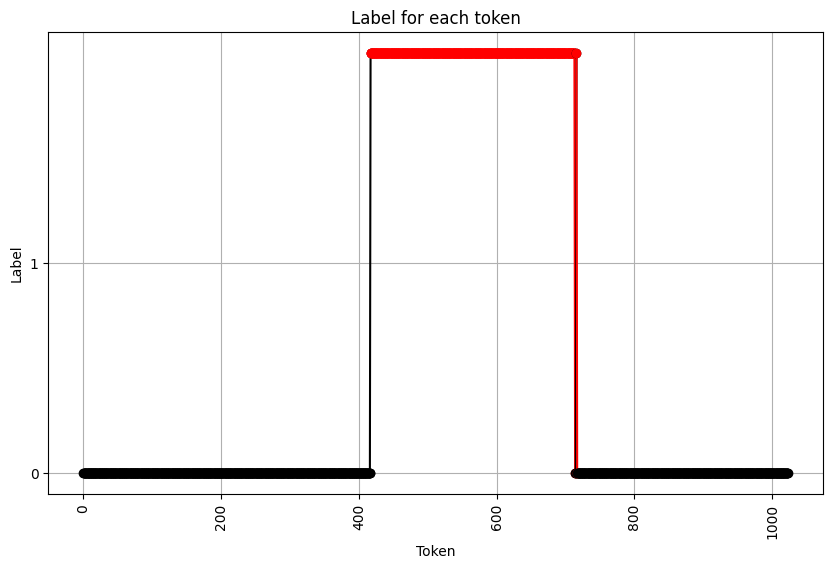



MATPFRIKRSAVPGKGPSVSDLQLGELALNTYDAELYTLRSRPGIGTEVVKIGGAAIENVLYVNKDGDDGNSGSTPADAKATLKAAVGIASEGTAIKVAAGTYIENNPIKVPKQVSIVGDSLREVTVSPQNADEDMFHVSPGDMISEITFSGTVDKGVAVIAFDPDKIQYVNQSPYIRFCTNRVANSIGLKVDGNKAVGPFKSMVTDSYTQYNVSGIGVSVSNEGYAQIVSLFTMNLDEAVACHSGGQCDVTNSNSSFGNYGLVADGVGALQYTGTIASEAKENTDKFEVNLSTSSVNISNFVYDNVSGLATVTTSSAHGFNVGMGVTIAGVQLTCPYGTKTYPHQAPYVFTVDTVPNTTSFTTNIGISTLAHSYFGGGTAKINLIRPFDGKAVYFENEYNTIGKIKLTNPGSGYNTAPTVTIGDPSTSSTFGVTATALATIIGSKVDEIQILSNGRGYTSLPSVTISAPDVGINTATATVELLPTYYTVKESTPISAGICTITINETLPYSVGVGTTVPFFRQSRILASSHSFQYIGSGVDPINSLPSRGGVTIQENEVDNRNGGLVVYTSTDQGGNFRIGDGVQIDQISGTITGTSYSKSLFANVTPLILALGGE
(1, 1.0)


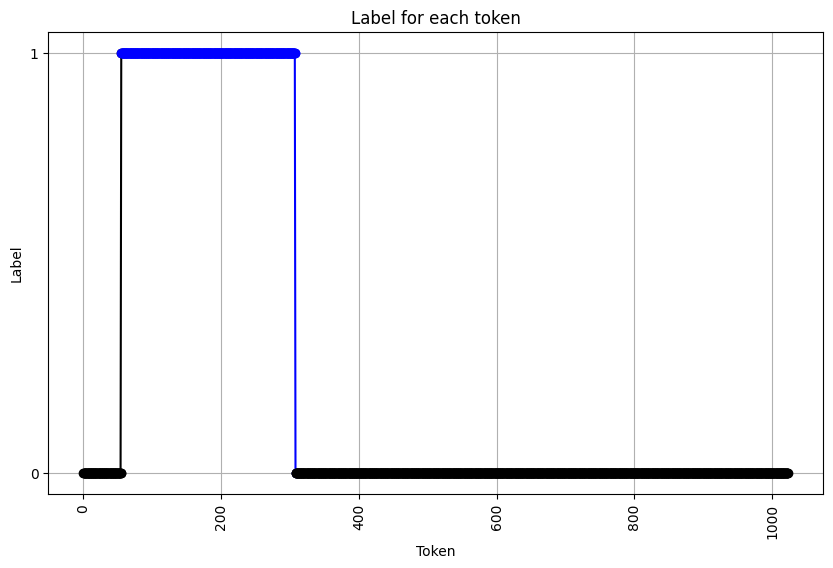



MANIKKTFNFRNGVQVDDDNLIVNQTGLVGIGTTVPTEALDVRGKVKVIADPNVTGSGEINATTGIITSLTVTNLTVSGNNYSGGVIGVGISVGTAGIITATEPTGIVTYYGDGKELLNLPTSQWLDKDVGLGYTSIYAQGGVGVGTVDPRFTFQVSGNNDLTNFEEGVGINDKGGIVATGVITATTFKGHVDGSVSSGLSTITQLQSTNANVTGVVTATEFKGDVTGDVVSGVSTITTLQSTTINAGLINATGAGFTGALSGDVTGNVTGNVNGNINAVTGISTLNILKILGTIDGDTVSGILTTGRLTAATSTIGVATAASLNVQGKLGVGINNPIGDIQVYKSGISTVNVVGEEFAVLQLGQRDSIGIGASTAQFKFGETSQELDIINGDPGSINSIIHGGGSAGINTGSFNWIYGVNNSTLMSLDYTGKLGVNKPDPEYPLDVSGIGTFSSDVYVRNSLDVGVLLTVGGNATVAGTLGVTSSVTVGGDLNVTGVFNYPSDVPADKLPDQIDVRINSAGVSTFLGGVNLGAVQVGGLNGVISGVSTIGILTSAENIPLAMGVYSPTAKAVFNRLGVGNTDPINALDVTGTIQATQYLGVGNQPIGAAVDFSNAGRGLTVPSLQNRNFMLPPKVTTTERSNLAGLAAGAIIYNTTTNKLQVYNGSSWQNLH
(1, 0.9999998807907104)


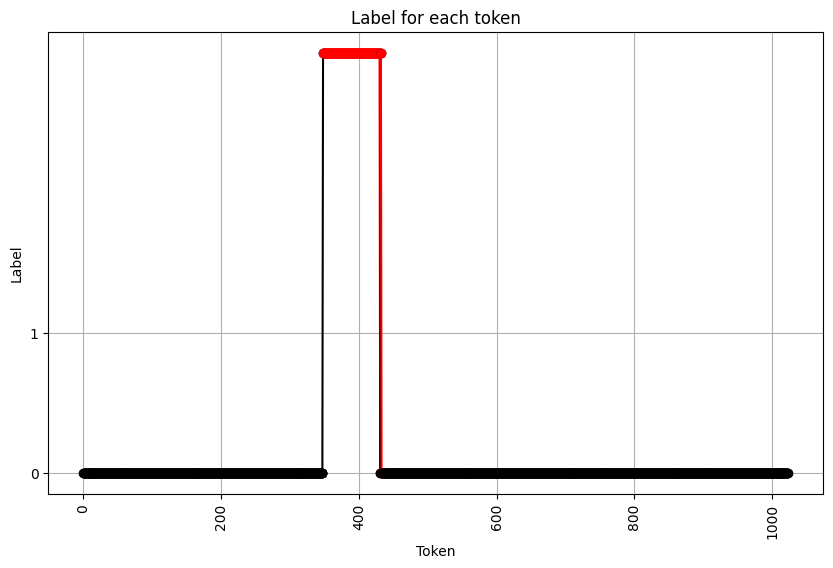



MISQFNQPHGSTSIFVNKQSIALNFGVTQDEVVYFAAGIDLSGYKVIYDESTQRAYSLPSGIVSGTTAISLDERAVLTHSAGSVDLGELAVSREEYVTLPGSFNFGHTINVKNELLVHDDEKYRWDGSLPKVVAAGSTPDNSGGVGTGAWIPVGINSLSGDGGWSRIGSEFGKSLKEHIQSLPSLSAVKYMTFVEYAALLAGNDTVNHDVKVQQVMDEAHELKCSVYFPTGRYVFDTAVNVWTYVRAVWGDGSAIITRRYGSQFSSPGVIDPAHDTRKLFRMMGGALGPQSIHGLIIDGNARSFTVPKHTDPDQTYPNQTYYGDVEPVDVGPYVFGPEGNTSVPGASYYNHDKKESGLTVFDMVFKDQPGGGVVGNGQNIRVFGNHFMGWYDHAVYIAGSNFASEGDGILCSDIVVTGNVFRNRINNRGNGAVKARFGVNRYAVTGNSFDIVDYCMAFEMGNGPATQPFGQIVVDGNVCTSDGMFMQIGNDIGTEWFSTNWLKSMTITNNTARSLDRIFLLGVSGSSSYIMDGFSVQVANNRFYAPSFLSVYTFMTNTEWMLNNNIVEITGTAMITGVDQSNINNSRIYLKDNVLGVLRTDVQGYAAVSNFQQVEISNNTLRNLYFQIGSYTTDLSIKGNTVNYTSALSSKNLALMYSSAGNGLITADISDNKFFGGVGRCQLKFSSSASLDCINNKFFTTSAPFLELHPAGYTPRVVRIKDNLMRGTGVLLAPLASGVSLSGAGNYMVISGNTLMANNPSAPENITLYQDTGAQSWVAHYETIRCVRNDFKSALLAINATGTAQSGLSTTNKFWFGDNATINTTVVCTYPAGNKANTDITQTVSV
(1, 1.0)


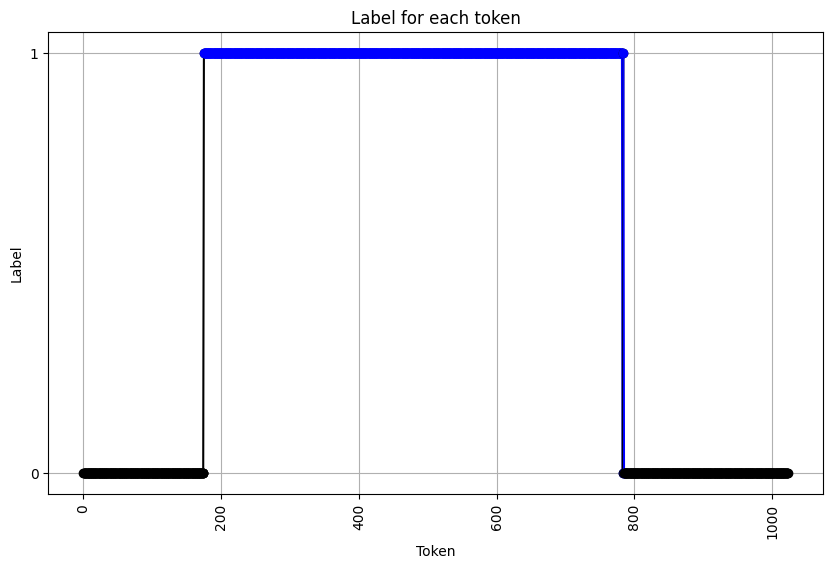



MFILHYYKEIYMNFYYVDTSRNINGDGSITNPFNSMSNLINAGVQFPYTISIKKGTVIEWSYQDLTNSSIFYNTSNQQCHFTSYGEGKKPIWISTGIDKRHLYAKMMNVAIHDLQISPPPGGVFTGGYLYGVPYGDPSNNNECNLEFYNLDFIGTPESIGGSAGSKEISMILLLVDNGGSSNVAHKIYIHDIIGDHVNCGIFVRGNPHLSDPTTYKGDQKKSYGVRVIDVSFTNIINYGILLAGCASKNKNRDVRNDDMESGFDGVYYSSYKTNVYNPYSDPYAYTTARYDVPLWMTMCAYVTGQNFEVHGSGPGKPDRYALDFDWHCNNCLMRWGYTTNNAKSFMFIQGPFSNSWYSSHGYTPLSNDPYTLYYTYGAGCYDNVYEYIVSYNDGIGRTHRKSDIFWKKAAAYRYCYNNIARNIVFIDTVSTSNDYILACNPQTDDNSNSTSMTVDSCIFYWKNRDSSNLISDIDVSNFGNLLSKFKFSNSIMYSEKWNGINPEIPNVSLTNIIYQNPLFKYDIPTVPPSGMKEVKELLKLSNNSVALDSGTQNNNKDIYGNTGNNIGWYQ
(1, 1.0)


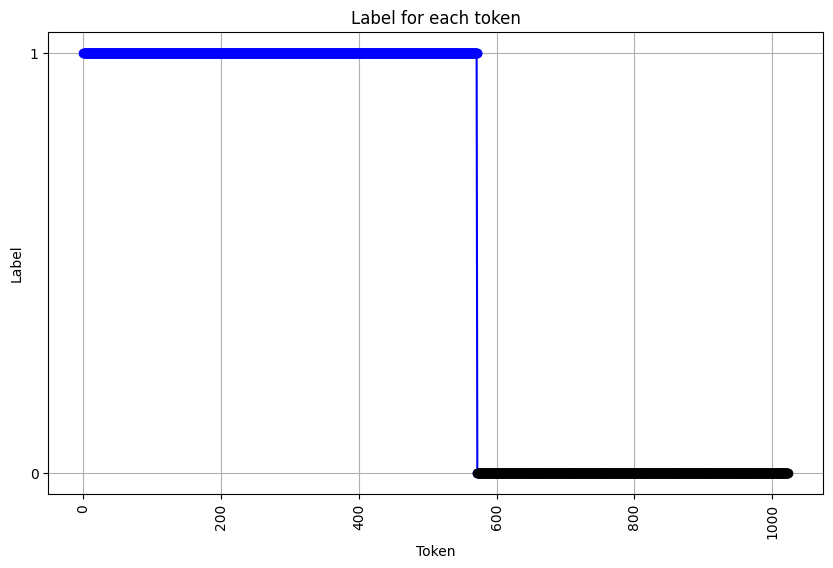



MPGLIVYRHSTHQPRAIMLELLMLGHPTQSAGGMQEDIKTDVSGLIAKYSNAGSVSALNITVGTSAGLAVYNNQLILIAPSTVSYYDINTFVRSKVTNNNVSISVSYNSVAHQSGKHWWFGQDRSVAAIYHVDLETGVVTKYPTPPVKKGMFYAYKGKLWLVGGWIGSVSNTTTIYSIDYNNPVSWSSQPLNAPLPRQLAGASAYFTTNGLVAFVGGGAVSSSGDTDGTGYTSVMLLNPDTLTFTGKTISTPMGGGYHNPNFVFNDTAYQFKYTNTGQRWSLGDVSRESSLSPAPIIGGYHNAFTIAGRVAFYGNSYSTSPVYLYVLPD
(1, 1.0)


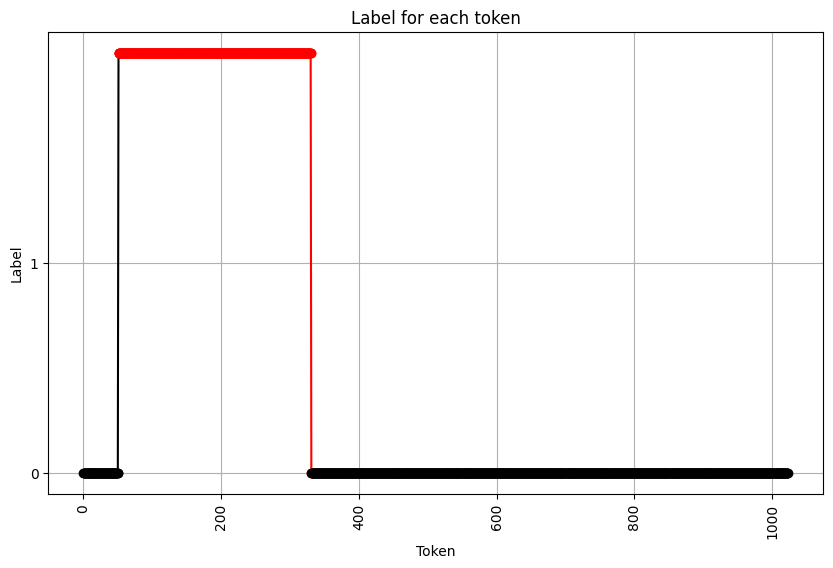



MALVSQSIKNLKGGISQQPEILRYPEQGTLQVNGWSSETEGLQKRPPMVFIKSLGGRGYLGEDPYIHLINRDEYEQYYAVFTGNNVRVFDLSGYEYQVRGDRSYVTVNNPKDNLRMVTVADYTFIVNRTRQVRESQNLTNGGTFRDNVDALINVRGGQYGRKLEVNINGVWVSHQLPPGDNAKDDPPKVDAQAIAEAIAVLLRTAHPTWTFNVGTGFIHCIAPAGTTIDILETKDGYADQLINPVTHYVQSFSKLPLNAPDGYMVKIVGDTSKTADQYYVKYDKSQKVWKETVGWNISIGLDYTTMPWTLVRAADGNFDLGYHDWKDRRAGDEDTNPQPSFVNSTITDVFFFRNRLGFISGENIVMSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFACVLTKGAPSKVFIYKFLYMDENIRQQSWSHWDFGDGVEVMAANCINSTMYMLMRNAYNVWIAAVDFKKNSTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICDSDGKITTYEPMGDSWNSTPDIRISGDIAGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDAGRLQLRRAWVNYQDTGAFTVSVENGNREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYMRRANGI
(1, 1.0)


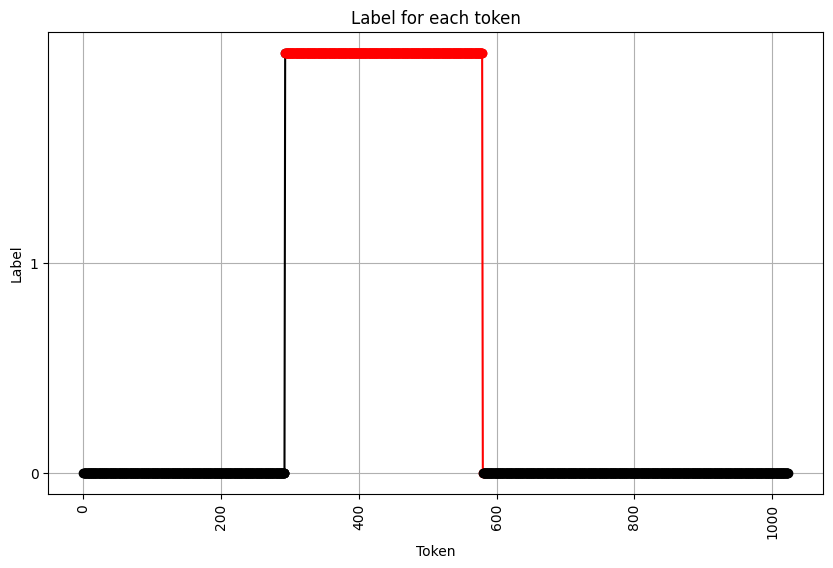



MPIQQLPMMKGMGKDFKNADYIDYLPINMLATPKEVLDSSGYLRSFPGIAKRNDVNGVSRGVEYNTAQNAVYRVCGGKLYKGEAVVGDVAGSGRVSMAHGRTSQAVGVNGQLIEYRYDGAVKTVSNWPADSGFTQYELGSVRDITRLRGRYAWSKDGTDSWFITDLEDESHPDRYSAEYRAESQPDGIIGIGSWRDFIVCFGSSTIEYFSLTGATTVGAALYVAQPSLMVQKGIAGTYCKTPFADSYAFISHPATGAPSVYIIGSGQASPIATASIEKIIRSYTADELATGVMEALRFDSHELLIIHLPRHVLVYDASSSQNGPQWCILKTGLYDDVYRAIDFMYEGNQITCGDKSEAVTGQLQFDISSQYDKQQEHLLFTPLFKADNARCFDLEVESSTGVAQYADRLFLSATTDGINYGREQMIEQNEPFVYDKRVLWKRVGRIRRLIGFKLRVITKSPVTLSGCQIRLE
(1, 1.0)


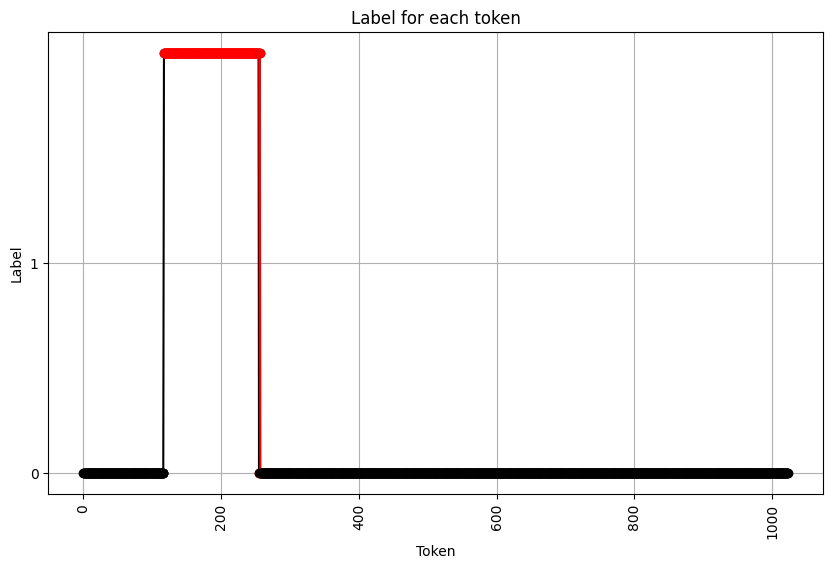



MASQSHGFDNTIVFGKETEFGVPAPDNTYGSLGVIEEFSPEENRNIVSRNSLGLRAPFMLRQGTNETDASVTLAVQNGKPFAFALGHVDTVEDTENAGNFIHTIRPTRAGEQLPSFTAQNHNALLNWTRNYVGGKFDSFTLTASSDDAVTFEGDILFATVEDSETAPVPVVLDTENYFMFYEGFAELNNQPFADVTNFELEIANNLERRYTLNGKNRADRVQEGNLEITASLTVDLTNTDVYNQFANGEDLNMKLTLQDQYDENHKIVVELLGGKYDSNAISLTATELQEQELEAVFTDIQITAYDTRPNLI
(1, 1.0)


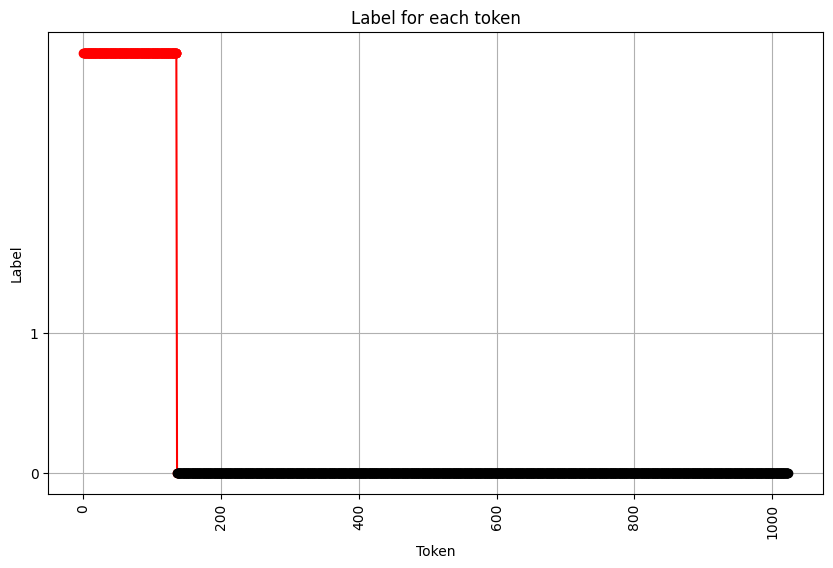



MSISFNNPLDTMTSTGANGSLELIVLGGTPTNPRPIRFNSSSVIIPVQTLPTGEQGAMVFDRNELVLKYHNGTSWIAVYDTDTILEPIRISLDEVNRKLNLKVESVTYSSSTVPSASISGTNLNIVFPTASSGGSGPTGLYTSLKPGAITQYSLTSGQSVASIREQMSGQSNGQSGRNGSQGAPWKTSDGWCFADGMWWQWEGENGTITKQVPNLNQNAYLKGISTSGVTKTDSVIGSSGNISGTVLSVAQLPSHSFSFSGTTGAAGRHGHSQALKGMDRSGLNALTSSNDNGIPTVINNINEAPDHIHSFSGNTNTLGGNQPHYHGISNIDVEHFNVAYLYNIAESNVALSEKVANTRYVLKTGDTMTGSLTIANSASIKSNDTSLVLYFRNASGGERAAVYHNSSNNTLRLRSGGAEVTVNSSGTLAAPSLTVSNNSATVGGKNIVRSINGTAADASGNVTLQISTNNVQSIRLSARIETSKIPDSSWTYTPEGAFMDGVWISVNGSSGTHLERISYRYVQMQINGNWETVRQQ
(1, 1.0)


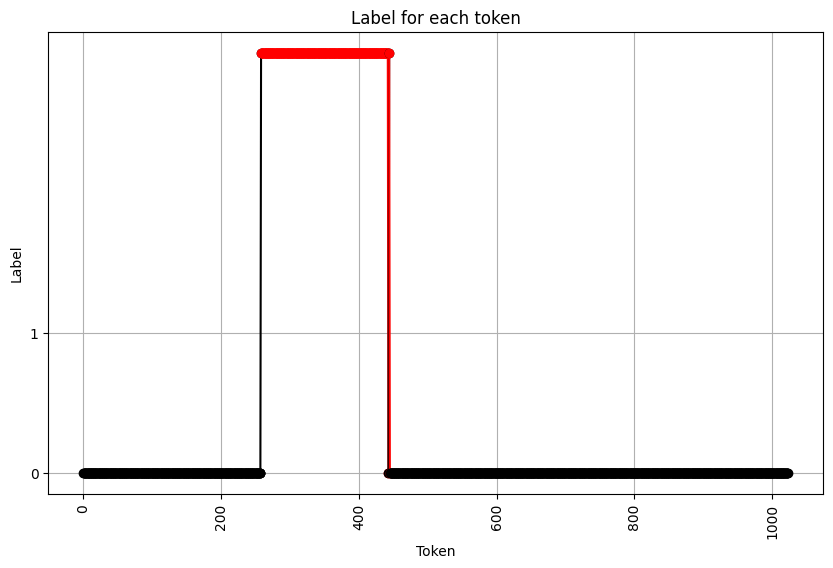



MNPQFAQPKGSTSKETNKDSIARKFGCKKSEVVYAKAGQSLSGYKVIYDKVSQRAYALPSNIGAVTVTSLVDGILTHSGGTVDLGALAVLREEYVILIENFTSGFTIRVKNEVVSDGVNLYRWDGSLPKTVNAGDTPGSTGGIGLGAWRSVGDTSLRTSLSSHTVPGASLVSLPNGTVNDAIKYVTPEMFRLDTDTNDDQMFQRMWDFAIPANANIIGDGEYHLANTYEVPEVHTPPVRYDFNMMTIKLRKVVYTSASGVAFINRSPGCVFEIGELAGKIFEIAEDAGTLDSVVIDETIGFQLMGQGRIPNVIHVVHGFATNVKLDTCFTRAIYVGECYDSLRGVRCVVSNANRIFGKIGGGFSNAEIDPSTCEVGITFDTSSNTNEVYANIEYCRRTVNSRPFVDDGSTNSFFGYIESCNLPGLVNGPYARYQIKNGGNNTRSQFGFEVGGMQSQIEMLDDAVDNGVPVTVGNSTITFKNLQSALSKSSQAEVIGKGSREIIAQGKVNQYIVSSNDLLSPQWNLAVAGAAQTSDLSITSGLLNGGASTQYRYGSRIVANREATESDYYVISQNVTAAFLREVSFGIALRMVEEVGYPGDADFMLKIQAITGNILYSKAFRLTGGSKIVEHFHSIPTQFVDSDTYSVQLHIRTWKMSKIDIFNIHLCNGANIERAPAGVGTGPTPFQPIDKNAIGFLPERICKPISAPLTLKQYDFDTYIVEGTGNITLNAGYDGQTVTFIRNGATDFNLLSTETIDGAGLTPMTDGMKITIQFIEQLGRWVTLSKVS
(1, 1.0)


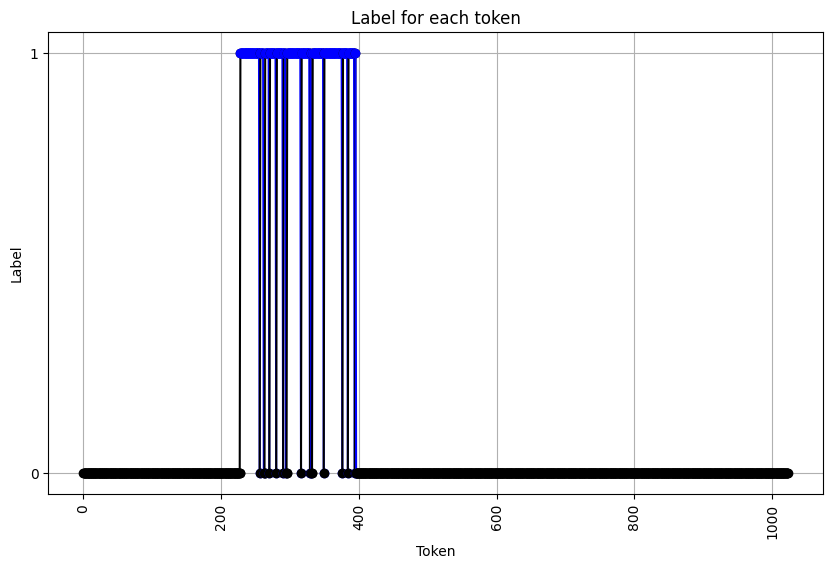



MGNFIQPKGSTSTEIAREILSKTYSINYSEIDFIKQNLSVTGLKLLIDPNTQYIWGTISSSETGTISSWSIDSTGEIMTVLTTNGTLTLRKISVSTSTTTANSIYNFMTSDDIYNIKNVVGIEINVDYALQKAINSGLMSIYYPPSKGIYVHSNVCTLPSGFNMYGQSRKPYTVSNDASFNNCGTVIRLASGSPGIFVLSGRHTFDNIVFDGRNNTVGSMNATSQVSGCRFEKCGFYRWGIGLGRTSGYVATVYARGCNFSGNNTAMQDWIDSRAVDCTINAQVSRGIAMRTGANNNAWVGCRVEWNGTDGFYFYQSVGNVITGELIDRNGYAGITVADGASVSVTTCSIQRNGRISSNTNNGANILINDSGIILLNGNRFTSGVDDGGTGVLTPDYDIICAGGTGKILIASGNSFSGGNLGYMKEVTIANKVITGNYGLPDIINTGTYQKSSGLVKMGNTSTGTLPPAASNGTLTLSLSRPAMTQYMIPQKIVLEISARDTIGGRAEYFTVPLLCSWESTVPVINMISSKLDTYPDNVWGPSTNTPTGVQVSVSTTSDGSTITINLVSMDTRNRQIQAYIRGA
(1, 1.0)


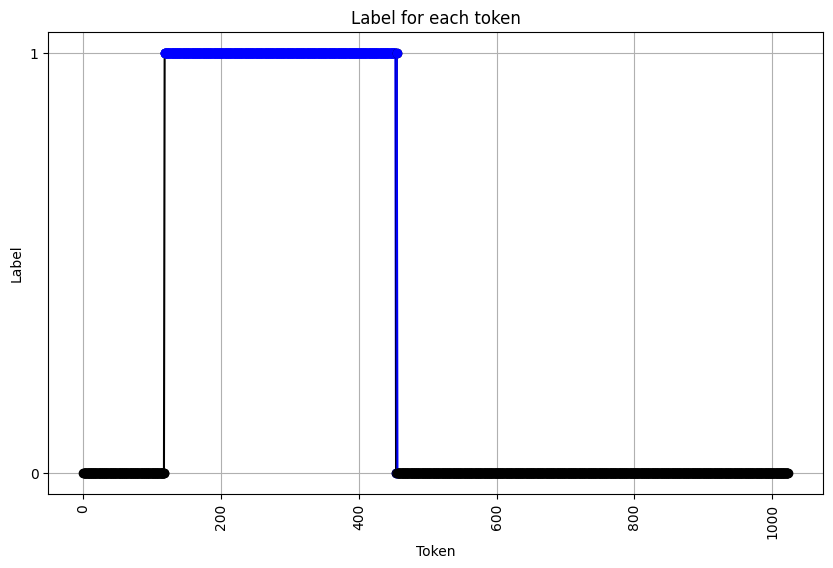



MNKEGNMLPFGRMVKYANIAPGPEPVEFSDVLQQHYTNCMYLHNPTNTLYGYGSNNMYQFGLGNSAAVSSFTVLARNCAAFWLGVQGSLMIDLDNKIYYTGSVAAFSDYGDATPVNGYLTTWTDVTVAFNKIGVMANMIKSVYIGESTRILLTDGRVIACGRNTNGECGSGNKNSIPTLTVMTNMGEVTHMACSLQGTHYIKSNKDAWFCGKDNFGESGCGGSSVVYLNKFVISNVEHISTTYDVTWWFTTGGSVYYSGANSTGQAGNGTTTSVNQLTPIRNTSVTVDVSKYSTFICPSNMGNASIGAPMAQYAPYVRSSGANSYGQEGNGTNTLVRTWNIFNLSAISGGYENVLMASKDWSRTIIITKDYKLYACGGWNGNGGRLPDGTYSITTLTLMPTQLWQQ
(1, 1.0)


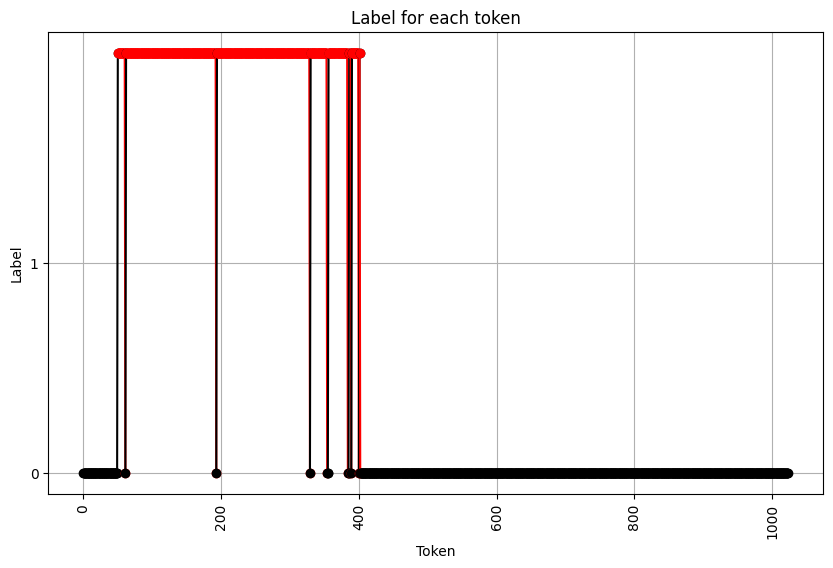



MALKLSNNAVSKLASSLAADATILAVLPGEGSKYPTLSAGDWFPLTVVKSDGSFEIMRCTARATDTLTVSRAQEGTAALAFNAGDRVELRFTAAVFLALAQIDGALSFSQLTVNSQGNATNPFTVNGASNTNGAGIFLIGNGATTPNKTIRSHNGNLEVVNSSYSAVILSLNDAGDVAVSGSLKRAGNIVWDAGNFDPASKQAAGNYAKSTNNVVTFDWGTHQVGQLGLTIDANYQGYLWHSGNFNPANYAIKSVHQDDGNVNGSVWGGLLSDYLATQLAGKQASGNYMRGVTGNGFTVGWDSGANHLNFFVDGNLVGFVVSDERAKKNITPSSTDALARVKALEFVEFDFIDSPYLPKKHVDNGVIAQQAQRINPNWIDKPPADHPDAYLGLNLQYLLMDAMRAIQQLSSEVDELKAELERNSK
(1, 1.0)


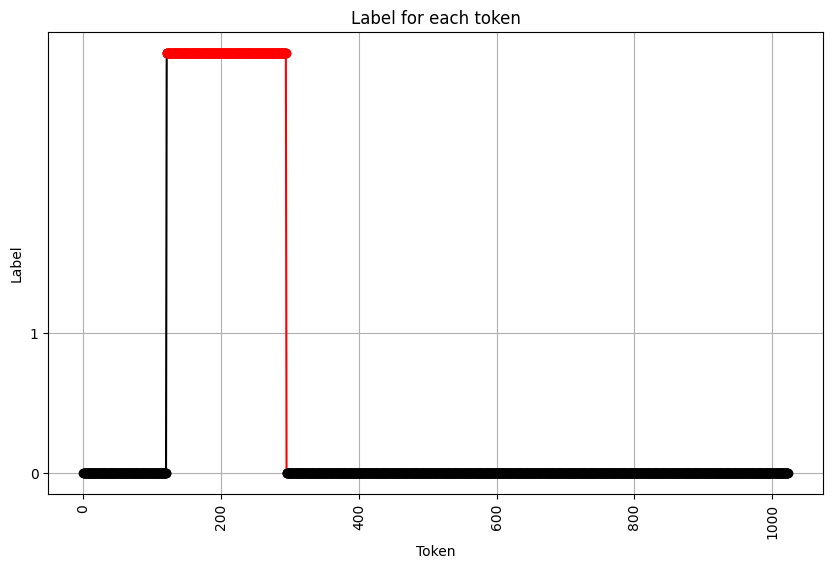



MTIIKITGFSGEIPRLVPRLLPDTAAQNATNARLESGGLTPYRKPKFITRISTIPAGQIETIYRNGETWMAWDKPVYAAPGPVAADRLYVMGDGAPKMIVGGTTYPLAVPMPSAALTAATSGTGTGDVFSRVYVYTFVTGFGEESEPSAISNEVNWQAGQTVTLSGFQAAPAGRNITKQRIYRSQTSLSGTDLYFIAERDASAANFVDNVPLSDQNEPLPSLEWNAPPDDLTGLISLPNGMMAAFRGKELWLCEPWRPHAWPQKYVLTMDYNIVALGAYGTTIVVATDGQPYIVSGASPDAMSQEKLELNLPCINARGLVDLGYAIAYPSHDGLVVASSSGARVVTDQLMTRNDWLKTAPGRFVSGQFFGRYLASYEYIDPAGTARRGSFIIDLTGQEAFLHRTNYKADATFYDITEGKLYLCIGQDIYEWDALDSENEILVWRSKQYVVQKPTNFGVILIEGSVLMTPEEEAAEQAAIDAAKAHNDSIFGDASIGGELNGAALNVYPIDGDALVRIESSRFVAATVYADGKAVATVSKLNRMCRLPSGFLAQTWEVEVSANADIAQVTLAGTGAELAGV
(1, 1.0)


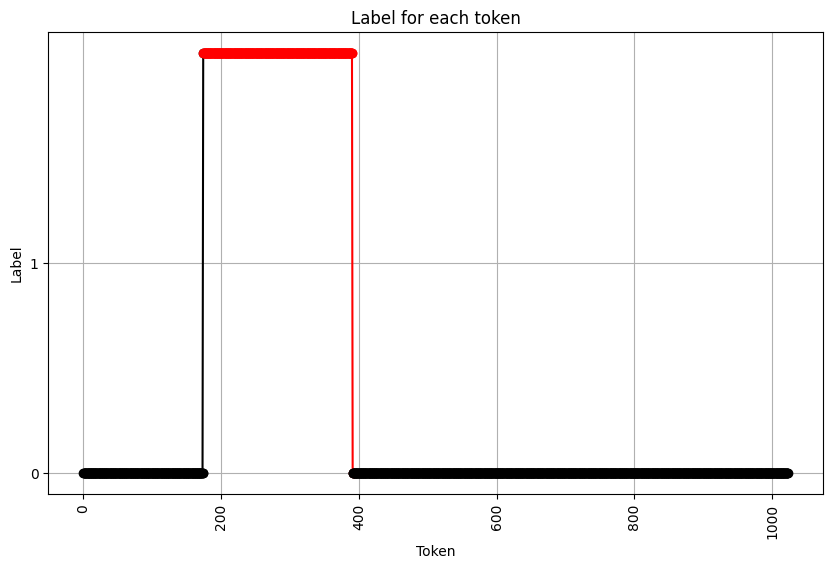



MTNKLTQPKGSVSKQLNIQTISRICGCNENEVSYIYNQLDIFNIKYLYDPISEKICISNGSGLVLSYTVSENSIMVITTIQTYYFPILDVAVNINSVDGLTKIGRGKTSLELKNYEPTYDNEYIFCDINGLDFWYYDPLDVNTPDNGYFCVVTNSGKRWKRKNSNDYIDLNWFGLKFDGELSLIWQNAIDIIHNMAISANSIYNLPYIKINGGNYTLSKNVTIAPYISTVFTKDTKIVCDNILDNTDEAAITIYSNDSINLYDNNRSASFPKCISNTSGKTKLIRNGTRSLTNPKGLYTKGASSTSHAINMRISDLEVQGAFSSGHSNTATRTWLMRFENCIFNGFYAISYLGTNTDSGERITYSNCVMSGGYGDVNTKTIYLESSGINLHLLSCSIDFTGGDVIYLSDTAKWCTICIEDSHIESWNGYLVNSVNTSNIARYITFRSTNILPTGSLGFSQSLSRKLINGQACTILFDDCFISWTVYPYDSYDSITTDTSNVIIRTKNHKDLSLGLHPFSNKNRLNKIYNFSSETVGNTLSGTTNTTTVRKYGTSFSNVTAVISSIDNSLIDTALGAGSTNVLSLTWNTGGYAYIETVEKVRVIPGFDYSFKATIVMPNLTSTMNISPAIAWYDENDTLISKTEIYYSDMKTIVNTAISSIPIYTSRTNKRVACRTSIMTAPQGAAYARGVIECTNGTTGSVYYITDYNLFYSPTN
(1, 1.0)


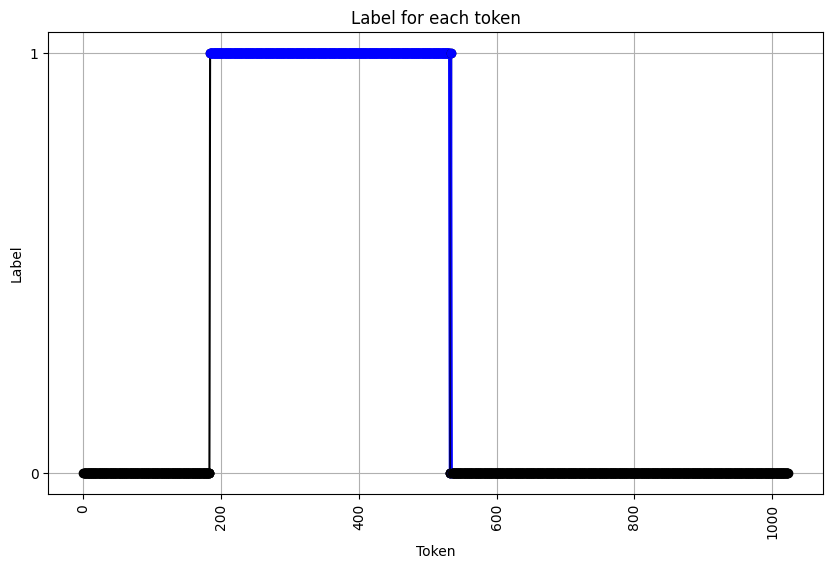



MRFNMSLNNLSATNISGALIDAGDFVINKRLVSNNQILYYTDPVTSIKTGYVWKGTLPHITSTNNPNTDGGISDTAWVPVIYSKLKEKMETEGLTLDWNAHLPTVEVAYGLTKNSLKMWKSGTTATSDDYWLYTDGTVWNGVGVLGSTPETSTGFEKITPNFNASIKTYSASATDGQTDFNIPFTFSTITVFVNGSIQLPGLNYTVSGSTLTFTTELEAGDLLYVFIGNPNISTNDKLNRIYTANAMQGQTTIQVPYDFSTAIVYINGVLQNPSTAYSIGADKIITFSEELYQNDEIIIMLGDVVVQSDEYVLKNDLLSPDASDNINTNDGTSVQQNIDNFSNFNNLFSNDNGLSNINYKSSLFSNNYKSTLYDLYQNKLSLFEFIPPELHDGIRNYTYKGDLSVYIQNAIDQANLLGGAVIECPPGQYYCNVVTKQYVVLIGSRNGSVRRSLPWTYGTPGNPSRPYGTRFRNFSNDWIIKSETNSQNDVSSRSFGIIGIDFDATDAINSTGGVRLRGPEFCVKSCSFYGFQDQGLEVSGNIGLIEDVIANECLKNRIRTDYVGTIEISGASDCQIHRIEGNAQVKGLNSITNSSPYICGIKISGNNHYISGLMGEISETGIYISASSVHHKISDSRADNNVGPGYLLNGVQMVNCHSYNNSRTGDGLYPAFGALDSASRLLLSNCLAWTDNAPVDGTGTQRLHSYGFDFSNVDYLSLRLKPWINQCFSYGDKNGWINSPLTYGVEYTPTNGLLTISSNATTTPNVDGVSVISISTTSLSQITGFVGGMIGQEVDVYLNATASVTLVNSSTFLINNFAKNSNKTMVVGRVYKFIKTSATIWREVGDVVRVYSGTTAERPSTAATTGMQYFDTTINKPIWRNADNTGWVDSSGTSV
(1, 1.0)


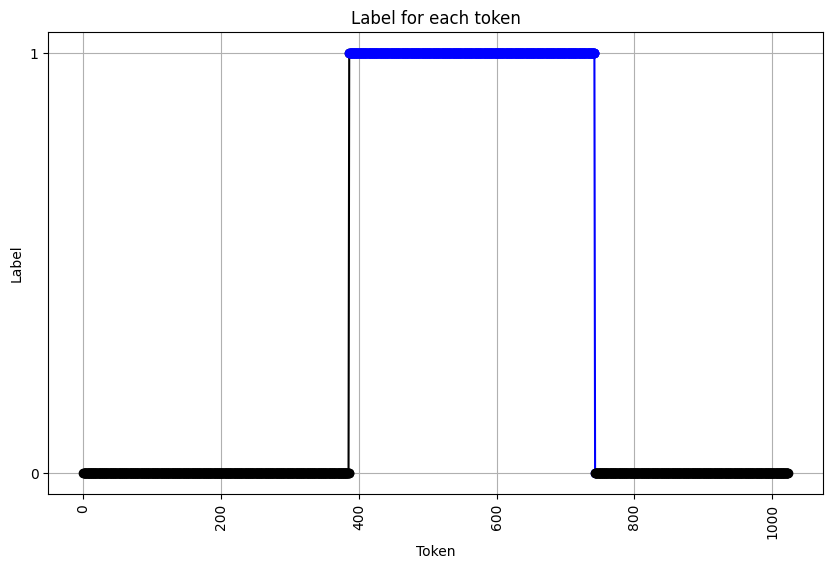



MGFNVVPSPEVSGLTGAPGPQGLKGDVGSSILTGTTVPLNTTGVDGDWYFMEDTRTFLGVTSTTFTIYKKAAGAWSVVGNTLGGSKWYVNTASTSSTDTKPGDMLLRTDTGDIWQRSASGWGSAIGNIKGPQGIQGIQGIQGVAGPQGPEGPQGVAGPAGPAGGVVSVNGKTDVVTLSAGDVGAMPTGGGAFTGDFSLNGASGSYRQWSLDVGGVKRWTFQKDDVAEDGLGAGSNFRLSSRNDDGTFKSTIMYADRGTGQVAIGTTSPYSNTKLSAAGAIGMKDIGSDPTTTAGGVAVYSKGGKLYAKEGGGAVTQIVNSSPTFDDFMVINATADTNYGIVAMRKLNKKRWMFAVSGASETGSDTGSNFMIQSYTDAEADKTVHLFGDRATGNTIIGGSTVMNGARLAVAGGALGIADQAANPTSSSLGSHFYSKAGRPWVQRGSGASPGGALAFELQPRPDEFLPEDLGLKAWTGDPAACVSTGAFCGSGPLRIAAVNLRQAQSISKIAWHFLGYAGGLQTGSWAAVFNTSGTRMAYTNDISTAGNEPAEQHGSGGGTSFVPLTATWSATPGIYYIAWRFIYNTTTGDGPMCLQYENAAGAPPNVFGLGTPVKRFGYFPSTSATPPTSIAVANMENGANRFWAALA
(1, 1.0)


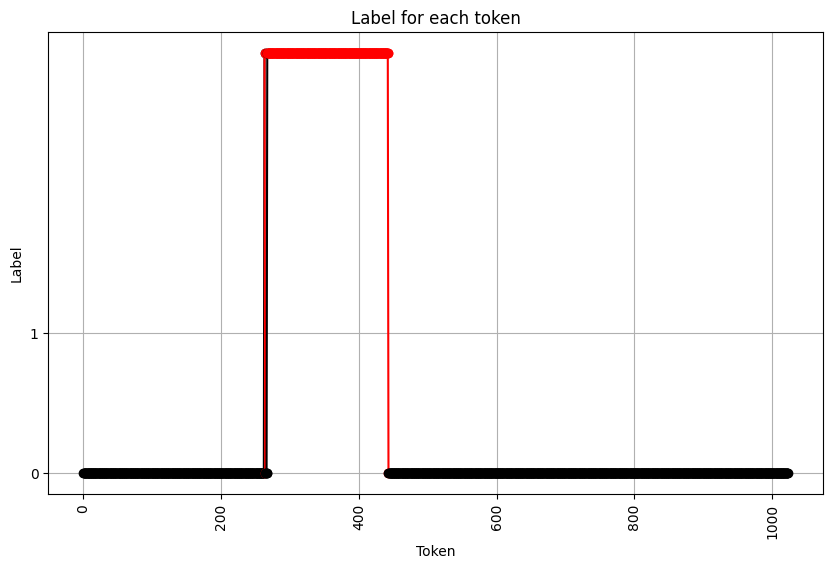



MPTLKNRRAPKSQWDSLNPILASGEIGFEFDTNRFKIGNGVSNWSSLAYFADENTLLPDSTIIQATSSRVPGLDTTGSVSASDALNSVFANAPVGSTVKMVGTYLIDKAVDIDPTKFLTIDASAATFLLHGSGTKLRCIGSFQEPYSILTISTESLVVENKTRTFTKLMLSNPPPWKVGDVVKIVANDVIPASHITSDTVKPRVGEFSVVHSVDGATVYLKTPLIENYSLNPRIARMNPGSVTMLQPTVDVTDSTLASKHVGNFFRCQALVQPRIIRPVMKRLTSMGLSMKSCLGYVIEHAVGRYALDDTANGNVGYFVHDSGCQVGRVIGGDFTAGRHAFTDGSADVAVDSTEFADYGASIDYKIIGATSRAMTAACWDTHHNSIGGEFIDCSAYPLKEESAFLLRGRKHRVINPKSYGGDTLLTVLTQVTGTWSKGESYGHELVNPWSDGTARIVVVNVRSDVNHPNVGVRQEVPNLTVQGGTHYGAVRRALVINGWVDMVGSALTKLGDYANGALYETQNSVLTFRDETIDASLVSSFGQGTQRVFYANDSDSAKHSVVKGGRLSVSASSAYITASPVPIECLINTERFDFDDIFFDTAWPSSTPIAVPDSTLIQNNIKWRSRNVHAASSVTQRSSHVVNFSNAQVSGSHRNLARSIDETLLMLVDITDSTPRTLSQLWLGKFVGQRLVIFRPGTGAAITVVNGASGRTALLGGSDKTLSSAGDSLSLIWTGTAWSQVS
(1, 1.0)


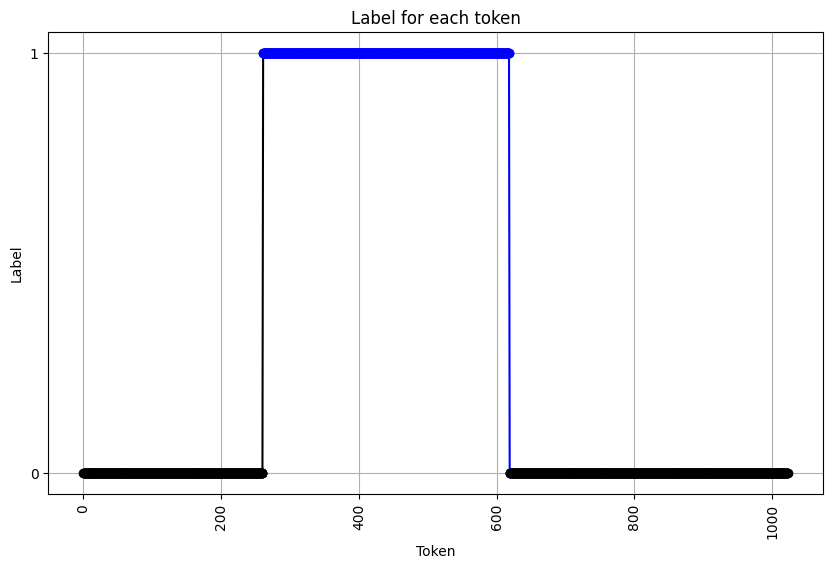



MADIQLKYLQDLEAAGGVAATDLMHVSQSGLDRSVTVSVLMRFMTDAFFPVGSVMLRSDAKNPNTMLPGTTWVRLAAGRNIRIAAENGSDVLNIGGADDVTLTGNNLPSHSHAFQNGATNQAGNHTHNVWTGNAGSHTHGAYTDAQGNHAHRAWTDAQGQHQHGVGIRNPSNYGGSGGYYGVRGIGLGSGAWAQGGGQTGSESLTSADGNHSHNVGMDAAGNHGHNITVNAVGDHAHAAAMDERGAHTHTVTGTIGSTGNNASFSVVNAYVNLAAWRRTQ
(1, 1.0)


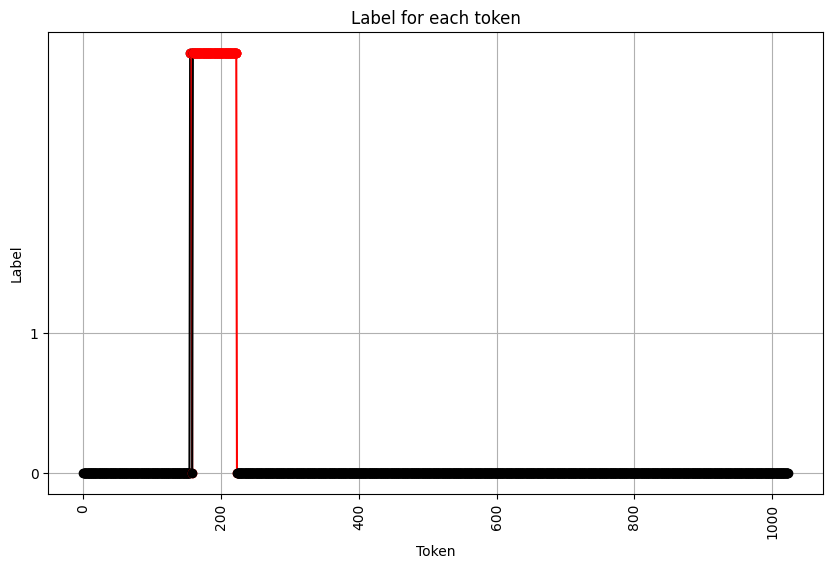



MLPFGRIIRYGNIVPGPKKIIKVGASTQGQFLLTDSHDLYYIGRNQGGESGNGNTNTVSSWTLVSADVSNFFVGDRTLVIIKNDNTIWTSGQTYWFSSSTTTSYSTVLVERTSWFTNAIPVSEIANIVCTNGLIFVLSTNSVLYGAGDNGYRGSLGIGSSSIYTLTQCATNVRKVMTNANDSMYLTLDNKLYSSGWNSSGQHGTGNQTQINTWGLRSSGVIDAAIGGNALNYYNGTSYFVCGQTPNFLSSGTTTFRAVPLSTLPNSSPLFMTNSPALNTATQMVITSTYQKGVGANRGLGLNNSQTGAIYSATNLQLPVEVSEIRDVLFSDGLTSILTKNGDVYSTGSYYAIPGAIEDVAVFTKIDLPK
(1, 1.0)


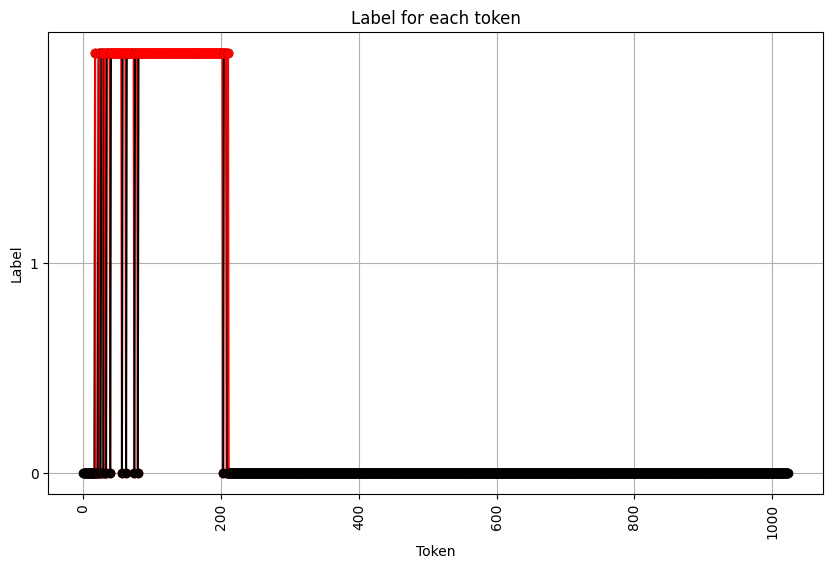



MLTIDGVVQIPTSADAVNGAYTVDGADILFSDDTVQKYLKPNQQLYFLFDTSWGDIGSGGGGGGGGNNGVMVERKFTTTGGETILDPKITFSSVLLFVDGEAKYPGEYFTISGNKLVYTDPMTAGRDVYALFGIPSSSMSLYATQEELSGVQANIDGLKTQLGAPWNGIVSDVYTYIDSVTSITSRAVPANINIVYTKKYSTASLSQSDIQLVREPSEDNVLLATKTWVQNGAINGKLLAFDNAGKAFRLNPVNGQYSIESLGGGDGGDDTVLIELAQQLSVKPVQLVENKVYNYTRAVKHTGGRGWIGKNTTFRCTNATASVPFVTSLKTAQGADNDLVNGTSGVANAIWSGILIDTNYSDTTGVVGFQFAENTLDNWVKCRFVDVVFKNSKFDNLAMQNGCIELRFENCRFENAGEDSVTVRKTCERVVFENCTVDKTALVAHVSSGNAKFGDGIVVKAKFVTINNCTFKDVGNNIKGAGIANNAEDNDNVDQASYNKYTNNTFINCYGGMGIGTVNAGFIAAGQLIGDLIITGNEFINTQANAIGIRYVKNVQIRDCIINKQNLQGYHAVELINVVNVDAAATVLNASGGACTVTNCNGKVDIHANDVSKANALNSLVIGNCDGLKFTADLYLSGRTAMTVDSFSNGKIDVRLRGVAKAGLVGNIVSRSEINVAATSCGNNGVTMTALNNSVLRAEVYDAGTEADVTYVSARLVSGSRNRVFVTSTSGQTNRPSYDILVEAGVSNGALYSDCSAGKTGKVNIVTGATITQFENL
(1, 1.0)


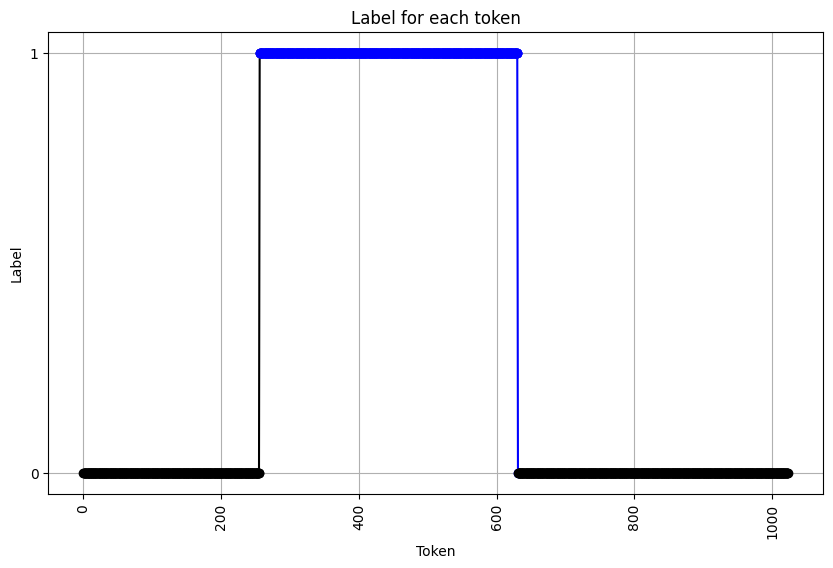



MISQFNQPRGSTSIEVNKQSIARNFGVKEDEVIYFTAGIDLSGFKVIYDESTQRAYSLPFGIVSGTTAISLDERAILTHSAGSVDLGELAVSREEYVTLPGSFNFGHTINVKNELLVHDDKKYRWDGTLPKVVPVGSTPTTTGGIGVGAWLSVGDASLRGELFSEYILYKTPQAFGAIGDGVADDTLSLQDAMDYCQVHNEKLVIPSGRYRITKPLLYRNQGFYNYEIEGQGGAAVIIMDSLEKTGITAPDAFGDDFNVNAAMVVLNDTNQSKYCRISGLRFESPVGAEYAIYVGQAENTYIHDCFWTGFTFGWYDLGSWVTRVERCIARDIVDTGFFKKNGTSTYIAECYADRMMRGYYLGGGYSAIINCACDLTTRWGFYLYGGRTGSDLATFSIKGCGSEQSGTDSVFYVDGLVALSIEDHNAGNDPTVQPAPAALLSMASNTSYSQVVLKNIRTVNVDTLILDSADHNYFDLTNVTCRSEMSKEFYLGTNSRVLKRSYDGERFITSNDQVGIGFAESDIVDGWTDLTLSGLRNGQFIIRRTVSIPRTSGDAGAVTITMPLNMDTNYTVAATLEGEFSQLQSICPVFSVTDKTSSSFSLCASSAKNNTTWSAIDVEVIIYGLKS
(1, 1.0)


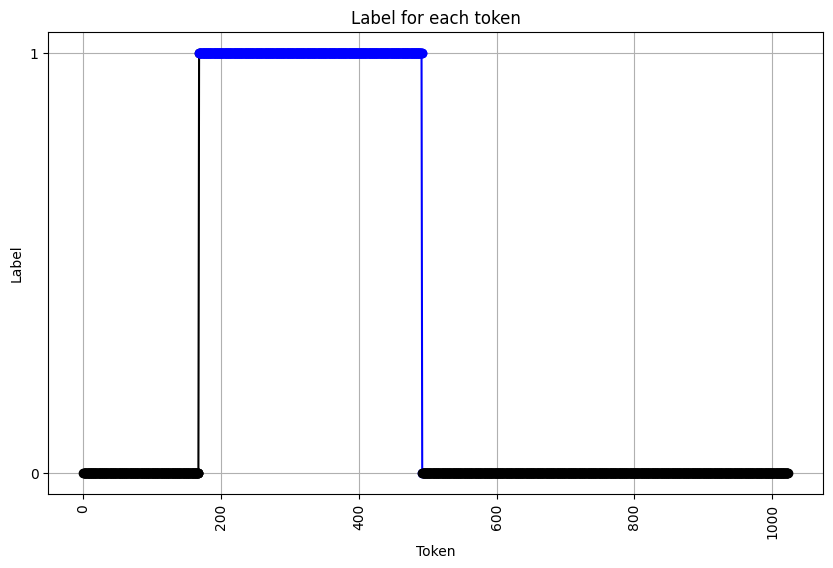



MAFSLDRNYDPQYNARMLTEIENDMETIEKALNSLLYKINTHTHTAEQIKFGSSNVLDQINIISKRINNLILNADGTNIKEVVDARVDDDGFVYPVLKDRLDADKGEIKTQLEANKNQLAEMYKTVELITNSQDGLSYLNNVEAMTTFKAREEALFWPQSANINELTNEIYVASQENEGTELRIEIRDLDTGSFKERKSIPIESGAYTEGLSFFYNDQGNLCFIVKASKTPGYNIFNYDTGELSDLISANVSSKYAANKYYFASITVNQFSIHAYVYTWESIKSGNPVLYTDFTVDYIPHLEKVQGMTLNDGFLFMSHGKSNGRPAISVYNLTGELLNYYIYTKDSLASAINKKFSNFIPNIYNYNFENESCCVYKGDLVAVQVVNNADVVLVRHNRMLGYSLDVNVNQSRKDTGWMNIELLKGATAYIPERKPRIRRIGNKIRLEAELKGVTTMDTEYISYYPDWSPDRVLPFTIPTSGGYNAVCQIQPNGKVKVLSTRHPTPDVNSWYPIIFEWYLN
(1, 1.0)


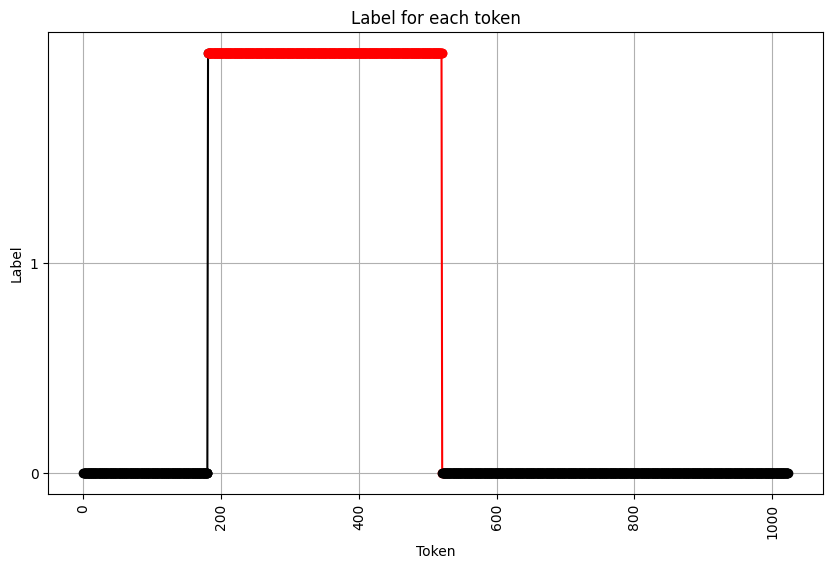



MPLSSQSIKNLKGGISQQPDVLRYPNQGAQQINGWSSETKGLQKRPPLVFIKRLAESGHFGTKPLVHLINRDAFEQYQLIFHNGALTIFDLAGNNYPVSGSLSYIATANPREDLRLLTVADYTFILNRTKTVEMSSELTHTGYPALNSRALVSCRGGQYGRTLRIRANGVELASYELPDGLAENNTELSKEVAAMDAQAIVKELVKRVNAGTATHGFSAAEGPSHLVIYGNGQPINNIYTEDGYADQLISGLIYQVQTTTKLPITAPAGYLVEITGEASRSGDNYWVRYDGAAKVWKETVKPGIISGINPGTMPHALIRQADGTFSFGPLTWAKRTAGDDETNPMPSLVDNKLNDVFFFRNRLGFLSGENIIMSKTAKYFQLFPSSVAASADDDPIDVAVSHSRISILKYAVPFSEQLLLWSDQAQFTLTSSGVLSAKTAQLDLTTEFDVLDAARPYGLGRGVYFAAPRARFCSIKRYYAVADVSNVKNAEDVSGHVPTYIPNKVHNVNGSGTENFVSVLTDGDPSKVFIYKFLYQDENLAQQSWSHWTFGKCKILSMFSIGSYTYTIMDRAEGVVLERLEFTNDTVDFPEEPFRCYVDGKRAIELTAYDESTDETYFNIVSLYGGVPDPSEVFWVIDKEGWAQRFDYEDWSSGVIRILGDRRGQTVTVGRSYEFLYEFSKFLIKTQADDGTVSTEDSGRLQLRKVWLNYEGTGSFNIEVDNGRNVFKSTLTGVRLGTGYRLNMLNLGTGQYRFSVAGNAMNQKVTAKSDSPQPLNIIGCGFEGNYIRRSNGI
(1, 1.0)


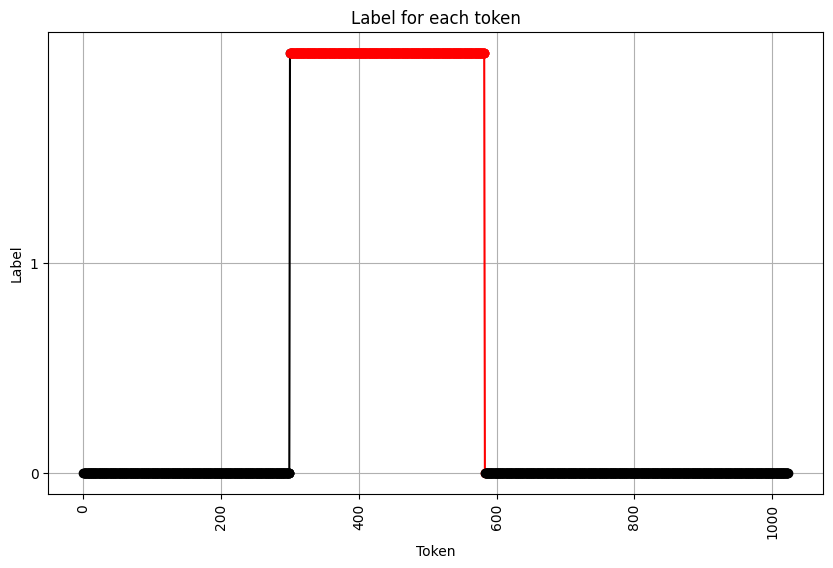



MEVQGSYGRQLQGVSQQPIAVRLPGQVTSQLNAVPNVVDGLKTRMGSKHLARILNSLDANSLIHHYKRGDDAEEYFVILQPGQVPVIFTVGGLACPVNTQGSAATYLSSSSLPRETTQLMTIGDYTFVLNRKMPVQARGDVTPSLDNKGLVYVAYANFSFTYQILINGQVAAEHKTASSEDVKNEDLVRTDYVAGKLLENFNSRTASFPGFSMYQDGNVLVVDNSNGANYALTTVDGADGQDLVAIRHKVTNLDTLPNRAPVGYKVQVWPTGSKPESRYWLQAESQDGSKVTWVETIAPGVRKGWNAATMPHVLVRESLNANGSANFTYRPGEWEDRDVGDDLTNDFPSLLNDSSPQPISSMLMVQNRLMLTSGEAVVASRTSRFFDFFRYTVLATVDTDPFDVFADIEEVYNIRWSAQMDGDVVLFTSDQQFTLPGDKPLTPTSAVIRPVTQFKMTPGVKPAPSGDSILFAFDQGSYSGIREFFTDSYSDTKKAQPATSHVDKYIRGKVLELSASSSFNRAFIITSPDRNILYVYDWLYEGTEKVQNAWHKWSFPAGTVLHAVSYSNEKLYLVLTRTNTSGGVAGVYIEVMDMGDELEYGLQDRVRMDRRATLSMTYNATTRVWTSSALPWLPQDLSSLDAVLVSGWAGYVGGAFQFSYNASNNTISTNFDLAEGNTATIVVGETYWYEVEPTPPLIKDSKDRVSYLDTPTVGNVYLNLDMYPDFSVVVTDKETLQERTVYLANKTAGSITNVIGYIAPHEGTLRIPLRRKSTDVSFKIRSKSPATFQLRDIEWTGSYNPRKRRV
(1, 1.0)


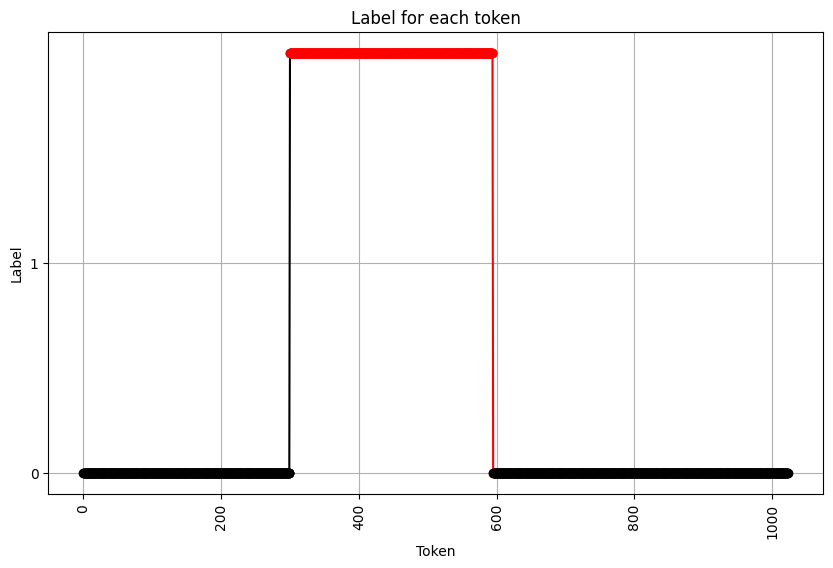



MSLIQLSPSNGDSLLINSGPFSTGKIIRTRNELVFYTDQYGNSTGYRWLGNLPHTINGNSPQTDGGISSTSWESYITSNLYDKLKSENITLSGTAHLPTVEVAYGLPKGSLKVWTTGSTSSSSQYWLYTDGTVWGGVGTLGTIPDVPFTQLHLQRDIIKYNYIVQTDGEKNINIPYDFTSVDIFINGVLQNLSTGSYKIVENIIQFSEVLNKGDNIQFYLSNVPISSINFALSSDLSNYVLKSELLDTSGADNVGFYPGGNIQDAIVYVTPEMFGAIGDGITDDTNSLQNAINFSKNKTLIFSNGKKYRTKNLVVPHAMTFKGLGRRQDGAIVPYGNVPAESFIHTGTLILLTTSSTVTFYDLTVDARGITLSFVDGQRLTGVGANDNNSGVYQSGLQMYNCNVSGFSGNNLYGGGSKSFGILKDCQFESSGKSCVRIDGVDWRISHCAIGRSLESYGLEILNENNYISNCDSYFNKLSGIFYQQPTGMSFIKIIGNTINSNGQHGISCSLPYAQPAGTIITNNIFWNNSTESTGTYHNIDLNYGRGHIVSNNVHKAYQATSGSTSARCGYCINLRNGATISGFINDAIDPLYSYVLGEINVITQNFANQNEVQVGTGLPLTKTVSADTSIGIKLNISSESYDRVQINPGKILLGNGSADPTHGIQQLAAYPGITMGVLGLGVVGNYSSSVFRVGTHRIWSGGDNTLRNKYGSDPTSATDGNILSVKVSVPSTSTSAGIIGQWASDDAYLYICTSANTWKRTPINTW
(1, 1.0)


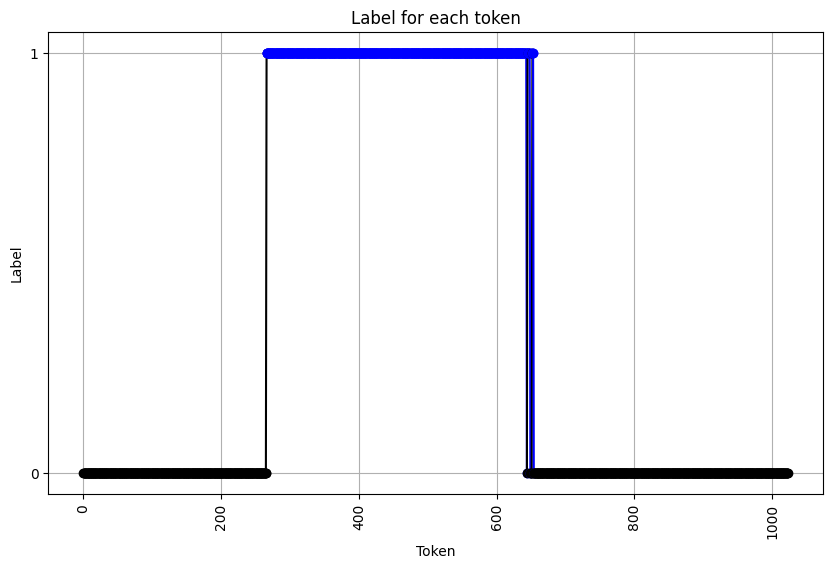



MRQGVVIEGFELTIIKITGFSGEIPRLVPRLLPDTAAQNATNARLESGGLSPYRKPKFITRIDTIPAGQIETIFRNGETWMAWDKPVYAAPGPVAADRLYVMGDGAPKMIVGGTTYPLAVPMPSAALTAATSGTGTGDVFSRVYVYTFVTGFGEESEPSAVSNEVNWQAGQTVTLSGFQAAPAGRNITKQRIYRSQTSLSGTDLYFIAERDASAANFVDNVPLTDQNEPLPSLEWNAPPDDLTGLISLPNGMMAAFRGKELWFCEPWRPHAYPQKYVLTMDYNIVALGAYGTTIVVATDGQPYIVSGASPDAMSQEKLELNLPCINARGLVDLGYAIAYPSHDGLVVASSSGARVVTDQLMTRNDWLKTAPDRFVSGQFFGRYLASYEYIDPAGTARRGSFIIDLTGQEAFLHRTNYKADATFYDITEGKLYLCMGQDIYEWDALDSENEILVWRSKQYVIQKPTNFGVILIEGSVLLTPEEEAAEQAAADAARAYNESIFGDASIGGELNGAALNVYPINGDALKRLETSRFVSATVYADGKPVATVSKLNRSCRLPSGFLAQTWEVEVSANADIAQVTLAGTGAELAGV
(1, 1.0)


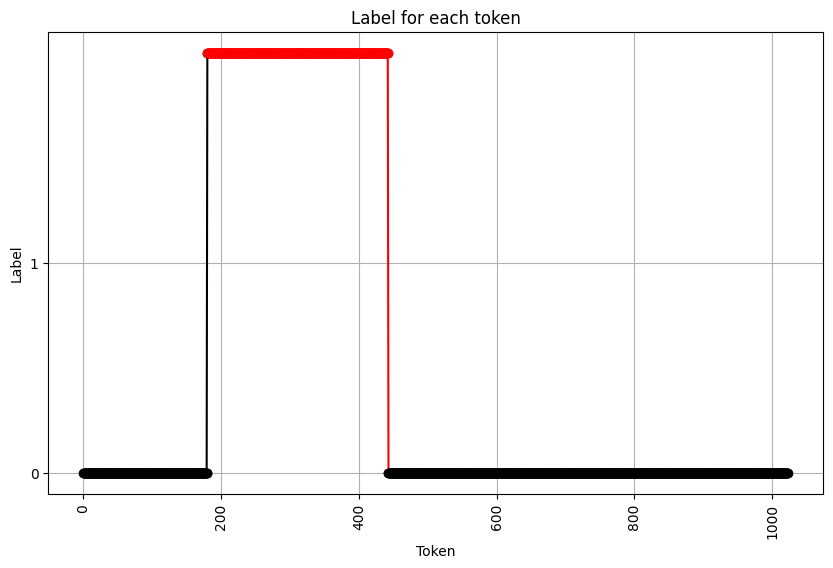



MLDYGNKVLPYIPNFVKLVTPSCGYSYTCTMMLDKNGSIWAIGLQNGGIFGLGHTNQVTEWTQIYSNVKDFWCSTMNSFCLIRTNDDRFFYSGLDKWLGNNTTNTVTTFTECTSYFAQFGISKIKEIYVGYDYALILDTDNSLYLLGDNTGAKFGINTASYYNKFTFLVDNVKKFCSSITPANWIIKLDDTMWRTGTTTSGTLGNSKQQTYVFPWVQYKGTPITEAIDIFCSSNYIGIITKGTPESCPMYTLGFQGYGQLGNNNVTSAYKLNPVLSTTVPDDSEFIRIENTSTRGLVYYSSGKIYSTGYNNNGQLANNTTRESGSFVEAILPSGVQFKKSESLVAGNDATLYMFINNKLYYAGKSPDNVSASSSSVMKEFLLPTI
(1, 1.0)


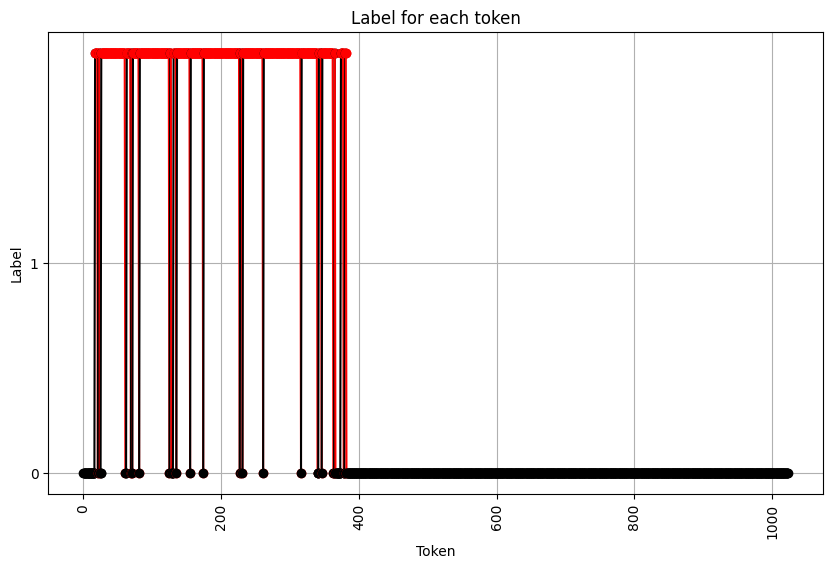



MANIKKTFNFRNGVQVDDDNLIVNQTGLVGIGTTVPTEALDVRGKVKVLVDPNVAGSGEINATTGIITSLTVTNLTVSGNNYSGGVIGVGISVGTAGIITATEPTGIVTYYGDGKELLNLPTSQWLDKDVGLGYTSIYAQGGVGVGTVDPRFTFQVSGNNDLTNFEEGVGINDKGGIVATGVITATTFKGHVDGSVSSGLSTITQLQSTNANVTGVVTATEFKGDVTGDVVSGVSTITTLQSTTINAGLINATGAGFTGALSGDVTGNVTGNVNGNINAVTGISTLNILKILGTIDGDTVSGILTTGRLTAATSTIGVATAASLNVQGKLGVGINNPIGDIQVYKSGISTVNVVGEEFAVLQLGQRDSIGIGASTAQFKFGETSQELDIINGDPGSINSIIHGGGSAGINTGSFNWIYGVNNSTLMSLDYTGKLGVNKPDPEYPLDVSGIGTFSSDVYVRNSLDVGVLLTVGGNATVAGTLGVTSSVTVGGDLTVTGVFNYPSDIPADKLPEEIDVRISSAGVSTFLGGVNLGAVQIGGGNGVISGVSTIGILTSAENIPLAMGVYSPTAKAVFNRLGVGNTDPINALDVTGTIQATQYLGVGNQPIGAAVDFSNAGRGLTVPSLQNRNFMLPPKVTTTERSNLAGLAAGAIIYNTTTNKLQVYNGSSWQNLH
(1, 1.0)


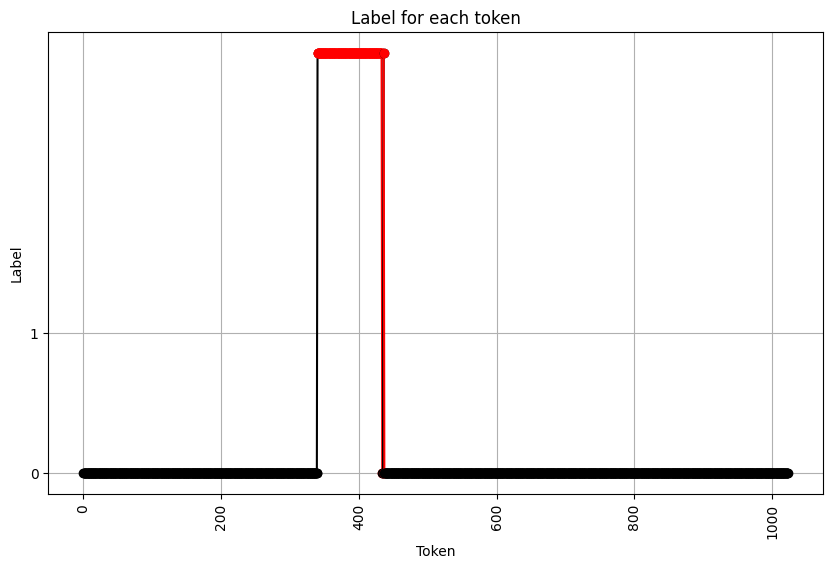



MPTTWYPYDNGTVGPTGPEGPQGPPGSAGTPGVVQSVNGQSVQDVVLDAADVNALPSNANAQLDATYFGINKAAGNYRVLRWLTDGASRWEAQVDDVAEGGSAAGSDFRLASRNDDGSFNKTVIHAKRSDGTISFGTTVHHGAAQVTSYGAVGLRDIGADPATASGGTYVYSKSGKLFVKQADGTSFQIAQVSYPVTSVNSKTGNVTLGAADVGAISSVSGGTAGGTVRVTGTAGTYRTLGLSTGPTGTASDRWYFQADNAAEAGGAAGSDLVITGRSDTGTFQSHAMHAKRSTGQTSFGTTSPLGEAQTTVAGAIAARDRTTDPATASGGIQLYSKAGLPYIKQGDGTVFKVGSGGGTGGGAVDSVNGKTGIVTLAASDVNALPISGGDLTGAVNINPTSGNTLTAYGSTDPATYFRVTADGHPYSNSLRATFYNLGVGDTGAPFGGGKFMLGIKDASVLPTSNPTNGVIAYSEAGKLKVRQTDGTIVTVANAPVSSVNGLTGAVNLTIEDLEGVSVSNVGQANGLATLDSGKRVPLAQIPLSATPGAFQPEDLGLKAWAGDPATCRSGYRDGSTGKGRMAAVVVRQTTTVSKIVWHFLGYAGGMKTGSWAGIYNTSGALVRGTGDLSTAAYEPAEQHGVGGGCSTSNLTSSVTLAPGTYYIAWRFNYTASPADGPLLMAFESTDVSATLYGLNAVRRFGAFATSATTAPSSVSGWETDPIRFWVALA
(1, 1.0)


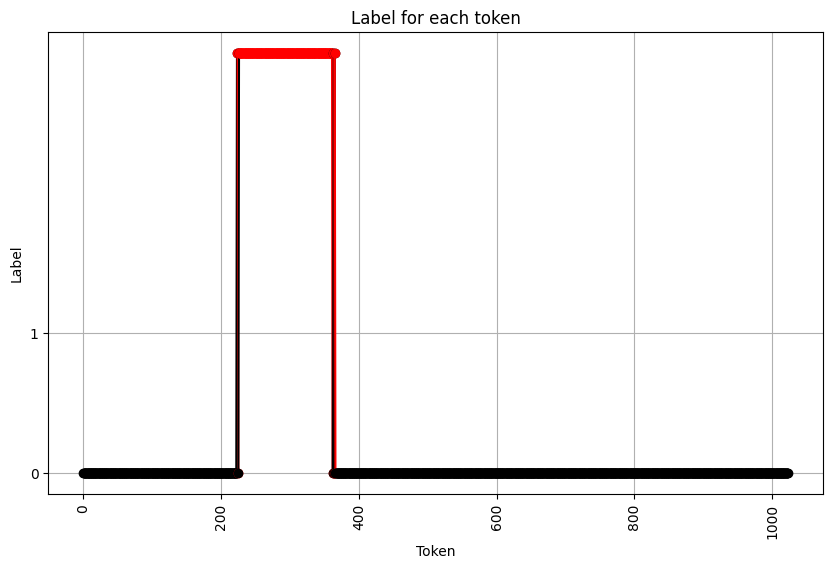



MTTSLIQPTFSRGEIGPELAARTDLAAYQTGLAKCINFIISPYGGAQNRPGTQFLAQTAGNEVARLIRFKFNVNDTYALEFTHLKMRIFRNGALVVYSSGPNVGQIFELVTPFTRDQLFEMNFTQSADVMDIVHPAHKPKKLKRFAHDNWTLTDVSLVPAVPAPASATATPDAGGSSTVLIAWQYQVTAVVDDGSQTPEESLPVTSNSINVKSDNQKATLTWPAVVGATYYNVYKDNAGAGIYGFVGRATSTSFTDVNITPTKTDTPPTGADPFIGAGNFPRAVAYFQQRLVYASTENKPQTLWFSRTGVFTNFGYSFPTKDDDAITWTIASNEVNQINHVMPLRALMTFTDGAEWIIQGQSSGFTAKTINGDPQTYNGIGQLRPLVLNNTALYAQERGRTVTAFGYTLESDGFSGSDISVLSPQMLQEYSLVDWDYQKIPYSIVWGAREDGAMVGITYLAEQQVIGWHRHYTDGTVLSVCSVPEGRRDAVYLCVERVINGVAKRYVERMADRQPERYRGTPLIKYSWFLDSALMYDGTNQSATTITIMGGTEWKYPEALTATSSASLFSPGDVGDSIQYLATPDADPFRMVITAYGSPTQVTVRPYGEVPTAIRGVAFTSWAFARNTLSGLSHLEGKKVTVLADGNVTKDVTVTSGAIELDTPAGVVLVGLPYECELQTLEVTFGGQETLSDKAKIIQQVTAVLLESRGGFYGTANEESKLWEFKPRQDSDDYGPIQAFTGKATQVITDNWSGNGQITVVQKDPLPMTILALIPATEVGGRK
(1, 1.0)


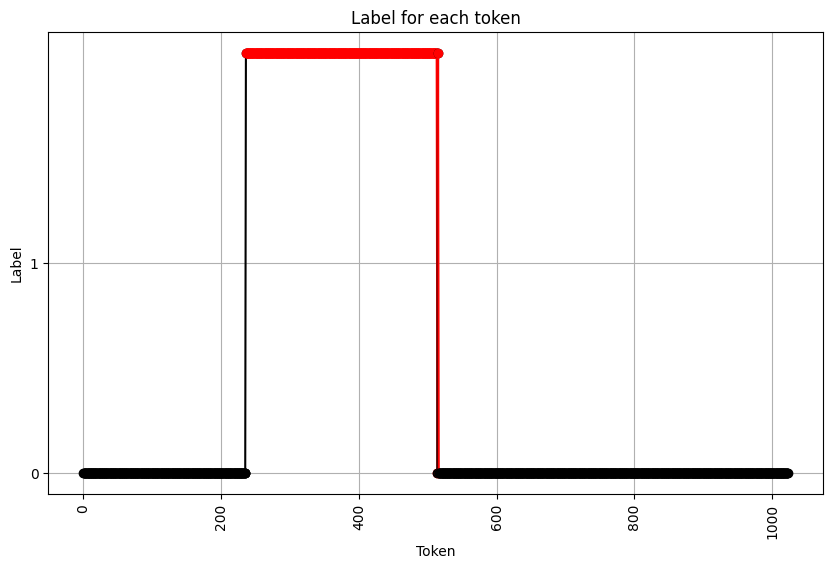



MAFKFKGSLSAVDATLKGGVKFDNEKLPDSKNMPEGKFTINEIDNSSTTDIASNTLVTNFGKPDNVAGMLSFNTGDWENNNSAPVKLMMRVVNNNNDSDWVTIFDSSKTTVTWSSVASAGQSVFTVPNLDFKKAIIYINGILQYPGISYQTFGGTVTFSNYLQSGDNVYIVVGKDSDNTTNIQYISTATTEQNTITLPYSRSSNYVYINGILQYPSTFTISNDIITLNSSMQEGDNIFVLSNDKSVSNYTSVAVQDQTDFTISGTIVEPTVYVNGVLQYDDYYNISGNTLSFVGKLFEGDQVLVFLDNPQLIDDVNTEYTNIIDDTNNSNKINIPYFHFSELQVFINGILQNPDNGAYDLNGTEVTLSSPLQEGDDIHVIVYNSPIQDDNIVTKADLSSYASINELNLLKDSLKTEGINLKWQPHLPSIEVAFGLPRRSLKIWKAGNTSTANQYWLYPVDGTVWAGVGILGTVPDVPFYKLDSNKDVITWTYTATSDNINRIFVPYNFGSINIFINGVFQSVELGHYTYTGQYINLNGALQTGDNLIAILGKLILNTNPYLTIESASKFITKSDIYNTDGAEKIGTSDGRNVQINLNEVSDFNKNLESNNQNLGANLINTEIDISVGKWIKNTVITPDMFFDSVNDVDWLPAFTKAAAVSMQLKLPVTLLPRDYTFLSALNMSMFGYGIVCDMSRNNKVVLKALANNTNAEVFITMKNVDRRKTGGFLIDANNLYDVAFDTTWDLTGGPSLMMVWEKIQIQGWKKIGWRANNNNDVWNKNITILEPGADVSSDAVSYYNHSAGGPISFEGCSFQGGRIQVTAQHISASYCVFRGVEIKTGGSGWNTFAAIGCHFFKDTYYNSCFVLGGNIQGFTVMGGLVEPTDGGSVFRGLGTGYFNCGQLELLNTRISSYNSSNPAVLASGTMLSVYGNTTIKITGGIAELSSYDPSTMGWVNTLICDKVLLNQLNNTPITRIFTGSLCKYNTPTISSVSMASATA

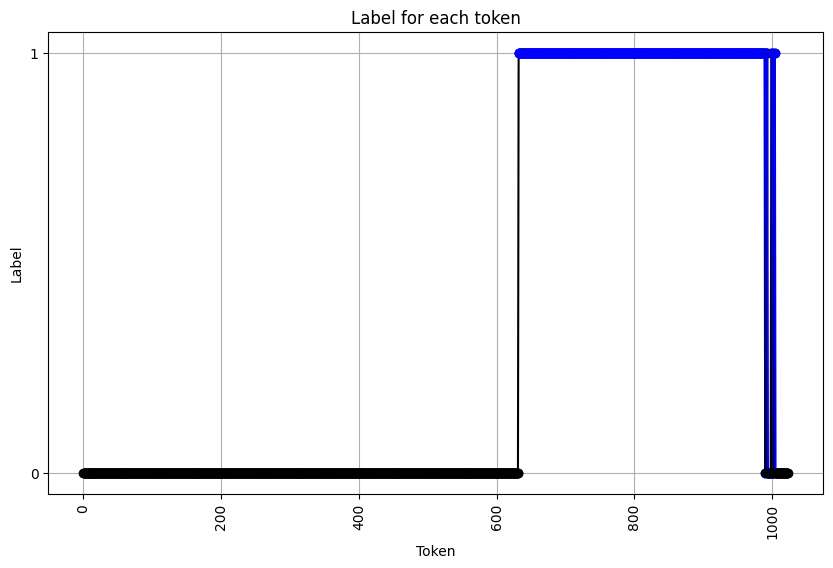



MSYQAEILTEDDTIRDLTVRFNRLMLAVQDIDGDKVDTSIKDIEDLKNQVIYIKANYIKQYPSLEEAKKATDLEEGMVVQTMGYYAINDGGGSIYAIAKTSDTQVEDGGSIIKYNDTLHFHSLSTDPVNYKQFGAKGDGVTDDGPYIRRAHEYANSVGLPVYNPSGEFYFKSERYVPVRTNTNLGQTVIHIDESKTPATQGNIYIIMSQYGQNPLSNDELTAIKNSLKKGTRYVAELAKYAGSFIKVFDSNTKVGNRQSENPNSGWDMQDFFIIEEGGRIVGDITWDFKDVTSGLVRRLDKSYLTFEGGIFLLSGNLSAASTGDQTTGGILIQRSRTIVKNQFVGIEDSASDKPTASDTGFYSLHPILVFTAYICL
(1, 1.0)


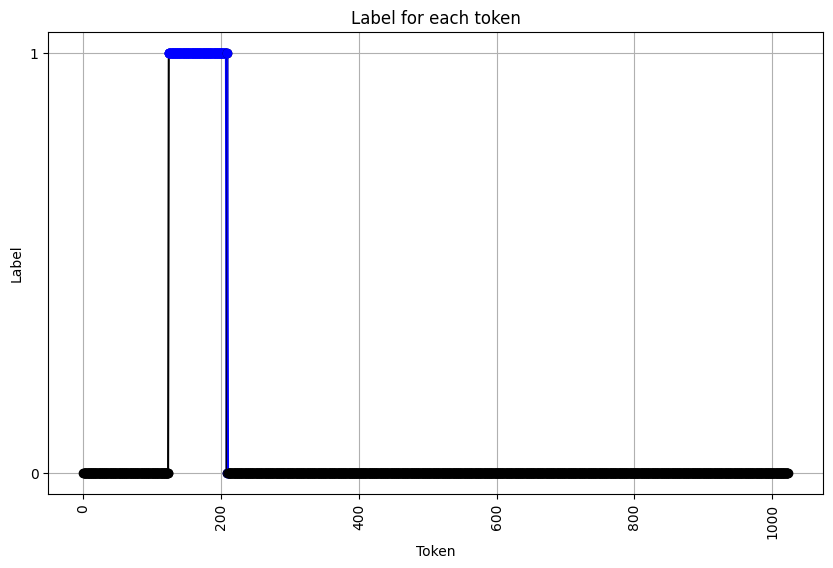



MYPIPCLFLTLSGGGTEPLPPGSVKKVAFTRGLVGGATKRSMAILLIDGRLYTQGDNAWSECANGNISPFKDHWHLAANGVADVFGGGRAFVVKYNNGGWQYCGDTSQFTGSGSIYSSWTSFPSSITGTVSLANLQSVSCALGNTLWQMVDGRLYGSGSNTNGCLGSGNTTVISIPRSISASSVRAYSLNACVTYLNNIGLPRVCGATHQIDGTSTTQTQNFIDVSFASVTETVYVKEWLANETNSMAIASTGVDDTEHYLYTRGIGTAQYSKKEGIGPFETFRVIDGGQSHFLIADNKLYGLGDLSAQLGLGTPSTMVLEPTLVPVPTGRDWDLSKLTYIVDMKTDVLNQGNSISHWMVYDGNLYYAGNLYGFFGSTDSTGEFTNIPEASFGGTTADAITTGSIPYAIKGSRSQLTWTVEPADAEIYDISFTSSAPNIATVDSNGIMTFLEEGGFDITMTAKTGSGADAKTLTDTSGGYVSIFSVTTDSIPQKEVGDVFVFMDKNSPDYTPGPNVVGMEISPANVDTNFIDGELTTTNPDVVMIDEGGFLSCIAVGDARCGVRLIYREGQVEAFDDSYVSVSDFTAPPDPVDPGEPVVPSQPQ
(1, 1.0)


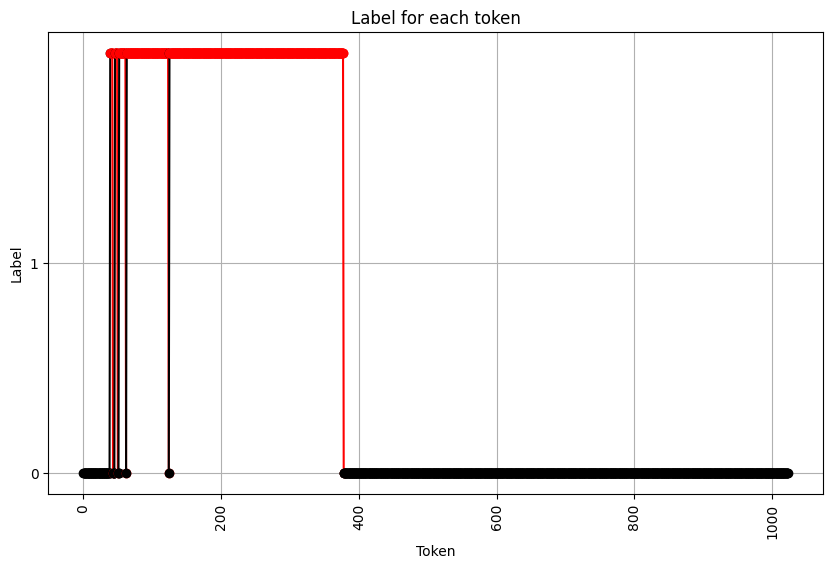



MNPQFAQPKGSTSKETNKDSIARKFGCKKSEVVYAKAGQSLSGYKVIYDKVSQRSYALPSNIGAVTVTSLVDGILTHSGGTVDLGALAVLREEYVILIENFTSGFTIRVKNEVVSDGVNLYRWGGGLPKTVNAGEDLDSTGGISVGAWISAGVDSLRNDLAANDGFKFIGQCPDIATLRTIEPGVNGQRIILRQHTAGTGLGGGSFRAVVDGTGYEDDNGVVIKTTGGAAWLRLNADRVNPFMFGATGGVDDTVAVQASVDSGRATELTAPFNVTSIKLKKKSASIYGSGMHISRLVQKPGVAGDCVVIEDTCSLIKLDNFGIYGTGAQQDTAFTAGTRGLVVPTPTGLSTNYPFNTSADPRRDLCINNVHIAGFDEYGLKIENGNFSVSTTNLLINHINQVGAYCATTDWTWTNIQINTCGKECLVLDGAGNARIIGAKLIWANWQPYAASGSYPGLKINNCQNITMSATEVQDCGSDGIIFKDSYSISISGLNTNRNSINSNYSYNNCVFDSCDVTIDGFVGLNYSSNSGSGIPSSAANFRFLSSDCTVVVNGNVESEYLGILFRGDNNIIQPTNSDLKINGLINYDKTSITFQNVMPSFDGVSTTPVFVPAPSIIGQANGLRLSQGNKDKIRYTTSRVPAGGVSLSAILIPTITGAETFNIIVLGTGFGSTNNSLYFQLNVDSSGNQSVALLISGDGQTQVLSGVIPDEFKIQSGVPYHFALGAAPGRFWWSILNIQTGSRIRRAFRRDYLSAPFNSLFGNDVSINFFSGEGSSDEACSGIGAKVYAGAFSSESDYCASRYYSLYNPIDPSKMFSYRTLDGSI
(1, 1.0)


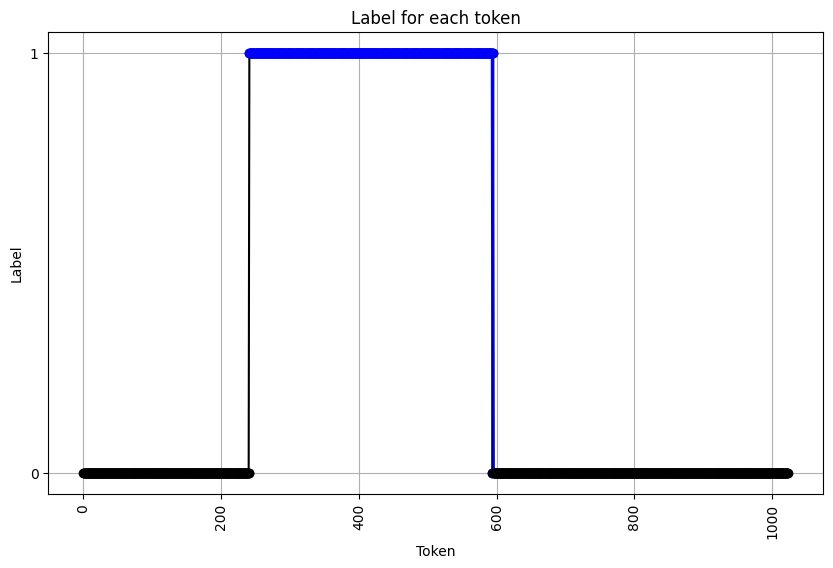



MTRNVEELFGGVITAPHQIPFTYKSNVGGETFLSLPFYPVTGVVTINGGMQVPLDNFEIDGNTLNLGRALSKGDVVYCLFDKILSPEDTAKGIRIYKFQAVGGETEFTPDFTSYGVQSLYIGGEYKTPEIEYSYDSTTGKVSLQTALTAGVWVVAEMSVKQPNISPAFDRSIQEIARSANVKDSEVIVSTDTISLLDGKKVIYDIAAQTSYGLPTIPDGSVISSVSGGKLNYNPGDVQVDLLPLPDSSQAVKLFYLQPSGAENIKVSSGDTVQDILNNINKHRVVSSISELLNVSPTETTFVFVASFHPSTNYGGGFFRWDPSGNKAAHNGGTIIDPGKTFPTWDSAGKTSWFTASGTGTGVWRRQDVMGHYRAEDFGALPWNVGDAHDSTKEFQQVANVAYRGGCWRWTGRHRITSYIDIPNKQTFGSYAQMTSVYSELFQPSNFQGVHVISDPSLARSVQNAVFFDAATGEAFRCGEGASPTDCLVYGRGFTTTGMDLATSLPSAASYCDTQAFRHGKAINVRNVTVALMKYALDSNPWDASKGDYYSTTDHMTILYCYCISRVPTGQDITFNTKHINMRAYVNQIGDYGLAVRNVVFIGGSIEGYNTSTFLRSSTQLSFKGTYFETGDTSFNGTVFSLVGWCTLNFEECLVYLNNTTNFVSSGGSGQSAGVLGLTIKSQGNVWRKTDAGTTTVFAVDPVTNKQALVGSEILNAASGATIAYWAGAVPPGTYTAPISVAF
(1, 1.0)


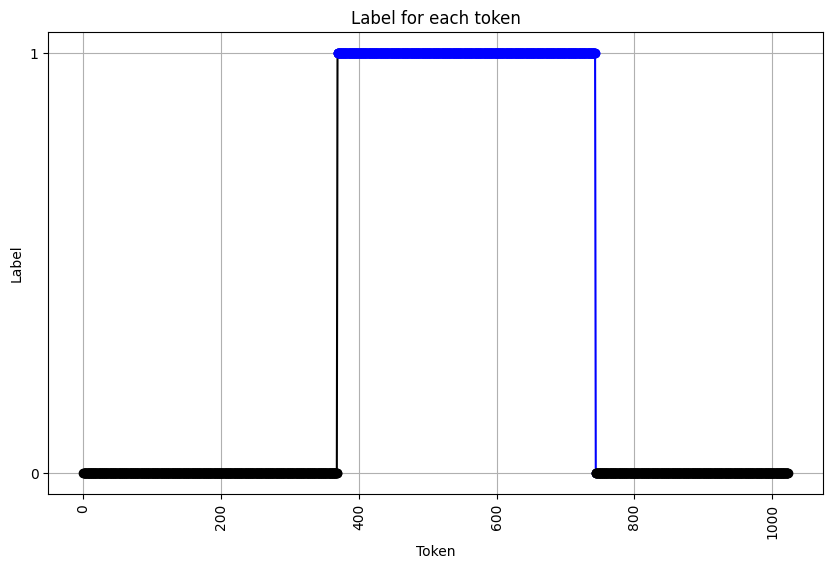



MPLITQSIKNLKGGISQQPDILRFSDQGEAQVNCWSSESDGLQKRPPTVFKRRLNIDVGSNPKFHLINRDEQEQYYIVFNGSNIQIVDLSGNQYSVSGSVDYVKSSNPRDDIRVVTVADYTFVVNRKVVVKGGSEKSHSGYNRKARALINLRGGQYGRTLKVGINGGVKVSHKLPAGNDAENDPPKVDAQAIGAALRDLLVTAYPTFTFDLGSGFLLITAPSGTDINSVETEDGYANQLISPVLDTVQTISKLPLAAPNGYIIKIQGETNSSADEYYVMYDSNTKTWKETVEPGVVTGFDNTTMPHALVRQSDGSFEFKALDWSKRGAGNDDTNPMPSFVDATINDVFFYRNRLGFLSGENVIMSRSASYFAFFPKSVATLSDDDPIDVAVSHPRISILKYAVPFSEQLLLWSDEVQFVMTSSGVLTSKSIQLDVGSEFALGDNARPFAVGRSVFFSAPRGSFTSIKRYFAVADVSDVKDADDTTGHVLSYIPNGVFDIQGTGTENYICVNSTGAYNRIYIYKFLFKDSVQLQASWSHWEFPKDDKILASASIGSTMFIVRQHQGGVDIEHLKFIKEATDFPSEPYRLHVDSKVSMVIPIGSFNADTYKTTVDIGAAYGGNAPSPGRYYLIDSQGAYLDLGELTSISTVITLNGDWSGRTVFIGRSYLMSYKFSRFLIKIEDDSGTQSEDTGRLQLRRAWVNYRDTGALRLIVRNGEREFVNTFNGYTLGQQTIGTTNIGDGQYRFAMNGNALTTSLTLESDYPTPVSIVGCGWEASYAKKARSV
(1, 1.0)


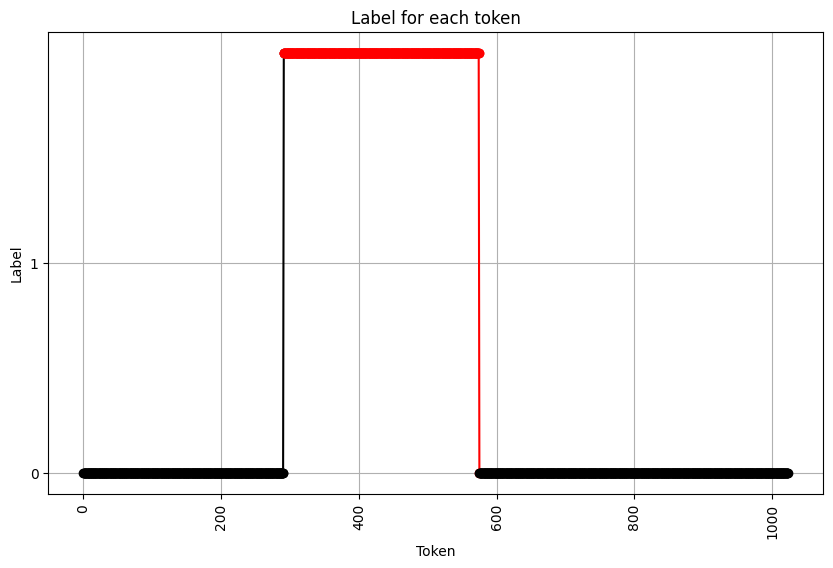



MSISFNHPQNTITSTGNSGSLNLVVLGGSPTNPRPIRFNSSSVIMPVQSLPTGEAGAIVFDKSTKTMKYHDGSNWVELLSASDVVAPLNVQINNIINSMGTKIDTVNYSSAAIPMASISGTNLNIVFPNSNPTVGSTGLYTSAKTGSIMYYSLASGQTYASIREQMSGKTNGQSGRTGSQTSPWLTSDGWCLADGMWWTWQGENGTVLKQTPNLNQSAYFKGLSSGGITKTDSPIGQSGSLDTYTFTIPDHYHGVGQMNGNSGPTGDDGSFIFGRSWNDGNSYRGLTITGDLNRREERSINGSDPNIALSTTNSIYLNASQRTISHSHNLQNFDVAHFNVAVLYNIAEPSLALSESVANTKFVLKSGDTMTGNLNVANTLRIAGNSTNIQLYFTNSTLSERAAIYHQSTTNTLRLRSNGGSEVYINGDGSLYVPGSTTVTGNFVSQGSATVSGNIISQGSATVSGNITSQGSATVSGNITSQGRNVVRAINGITADGNGNLNVTNSSGTTSGWHKDEGTGIITQWGYIQSTGNDIHVNFPRTFSSACYCVTLGQIFNSHADQGRTARLLAPASVSGFDFYIGSSETGCYWQAIGR
(1, 0.939708948135376)


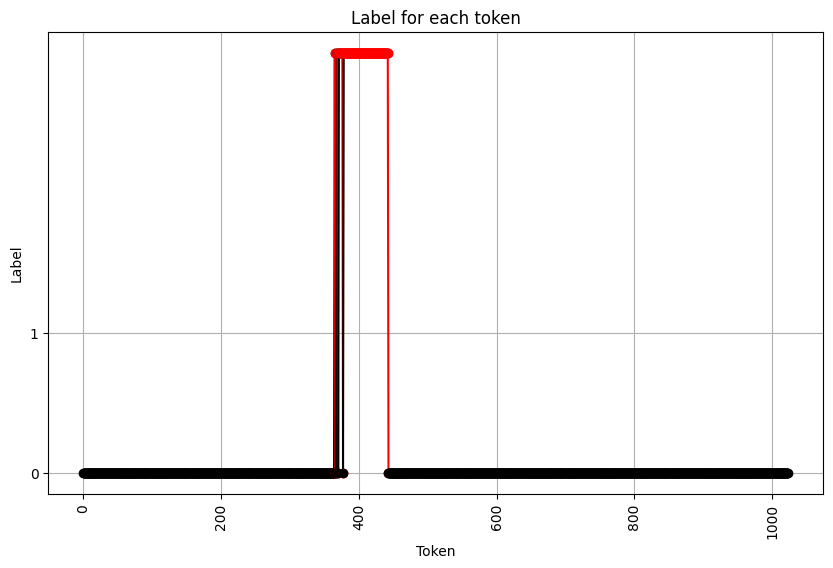



MKKTIYILSILLLTISGVSAQTVIKIKQPNPQQITIADDSIKLNGSTSVPLSDIIKPITLAEYNAMDAATKLKNAGRQIIDPTGTPTAISIVDGSVSTAKIANSAVSGIKILDEAITESKIADASITDSKINADTYKKLYYAVPDGYISPRDYGAVMDGVTDDRAAFVATLTAANTLGKRIWIDSDINLDVEETGTKSIFIPSNTWIEGRDKDVRISINNLLSPAFYIALQENITFKNITFSYDNTYDATIRYTDASTLANDNQIKNYLTANKSVNFNGLEPIKLSPVNYRYGFRLDGAKNVVFENVVFDAEGDLPNAYPLGWIKLIEQYSESTSVVSGGATTVCENITFKNIDFNKSIMGIQGLVQGFYMSDVNSYYFTDCQDGDGSNLGGEHAGSTAYWMPPPHLIYLNNDGSVNYQSKDIHINNVIDYGFLVGTTAVRADGRDNQGYLTSLKTVNNMSNVYVDGYKSYRRDGLADIGDITNGVYKNMYSESTTDIFESSRQFTPLRFVGIMDNVLFDNIVIKDLSDIASTYPISRSYGDNVTMNNIQLFSKTLSTTYTGVIGVSGSNNTIKNLTYTIENHTDAASNYQGLIFHDNTTMDSGSNNNYEVTINGWRNINSDPIALKPRMLFSKAINPNNNYARLYDSSNNNIIEQINEFQTDTWTKTEVVTLGAGVQQTLTMNIPSGYAINKVIAATQTSLDAGTTVSIGTVSGTANNLIPLVVQASGTGAIAINNINETALSTSARSIYIRTSTGDFNSTGKVKVTVELKRWRLN
(1, 1.0)


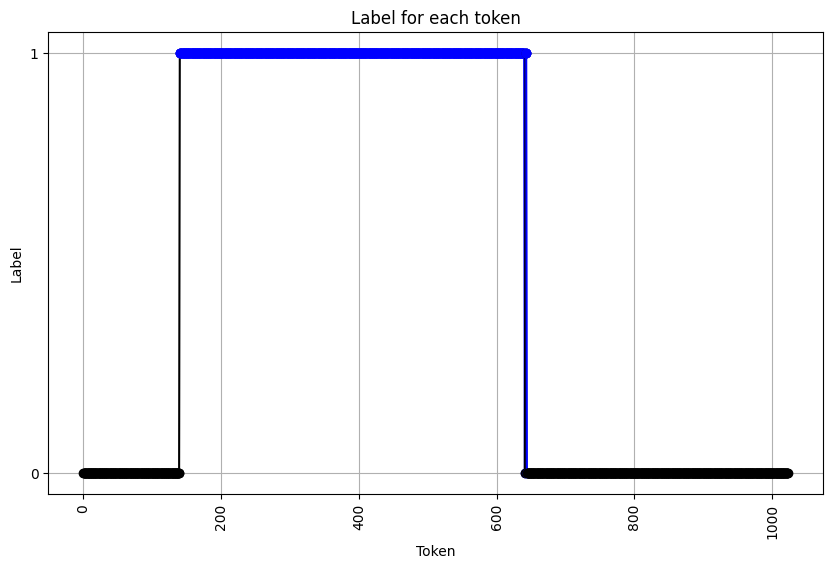



MASQSHGFDNTIVFGKETEFGVPAENSSYGSIGVIEEFSPEENRNIVARNSLGLRAPFSLRQGTNETDASISLAVQNGKPFAFALGHVTTVENPDVEGGYIHTIRPTRAGEQLPSFTAQNHNALLNWTRNYVGGKMDTATITASSDDAVTFESDILFATVEDSTEAPVPVVLDTENFFMFYEGFAELNNQPFADVTEFECEISNNLERRYTLNGKNRADRVQEGNLEITASLTVDLTSKDVYAQFANGEDLNMKLTLQDQYDENHKIVIELLGGKYDTNSISVTADALQEQELEAVFTDVVVTAYDTRPNLI
(1, 1.0)


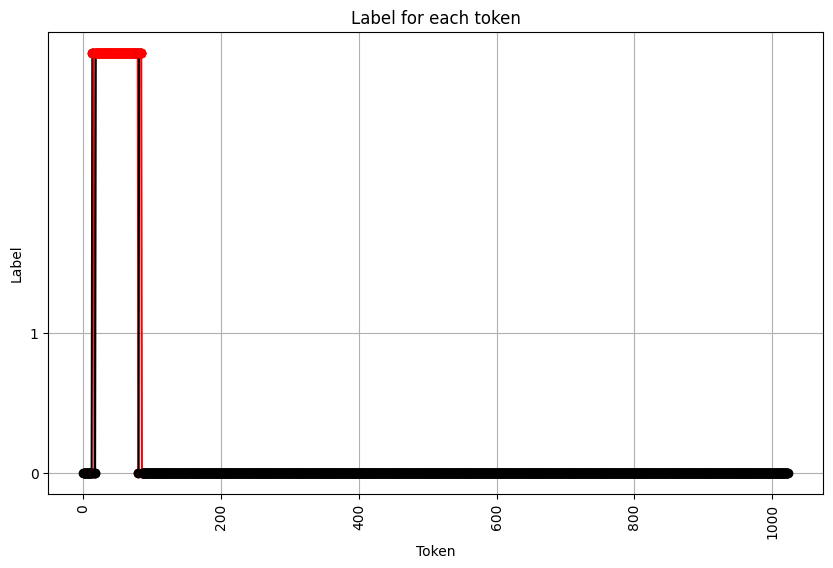



MLDLDRQEIKNAVGIFTDPNPSDLPPNAWNEGRNVRFKDGKAIKSQGHEAVFGALPGGRGPKYAMPYLSEATPYWFVTGGDKIFRTEGTAYIDVSRAAPYSTIPSAKWNGGFLSGVAIMNNGVDVPQFVTTFGGSQFADLTNWPVGLQAKVVRPFKNYLIALNLTKTSVQMPTVVKWSSPADPGNVPFTWDETDPTNDAGENPLADTAGAIVDGKKLRDQFIIYKEDSVYTMRYIGGVFVFQFQQLFDDVGMISQNCAAEFDGKHFVVGQGDVYVHNGVQKNSVIEGKVKKALFDAIRAGSNNSVFVVPDYANSEMWVCFQSTAEAVSGSYCDRAAIYNWTTGLWTFRDLPQIVYATFGVIDPRTPDTWASDPNPWDSDTTVWGNSTYNPAKNKILLVSESNKATYSVGDTSLFGTSSFKSTLMRTDLYGGDDLHFKNVNSITPHIKGSGICNIYVGASQIMDAPVRWQGPFPYKIGTDFKIDCRVQGRYIGVRFEFDSVGQWEFSGYTIETNKLGGKR
(1, 1.0)


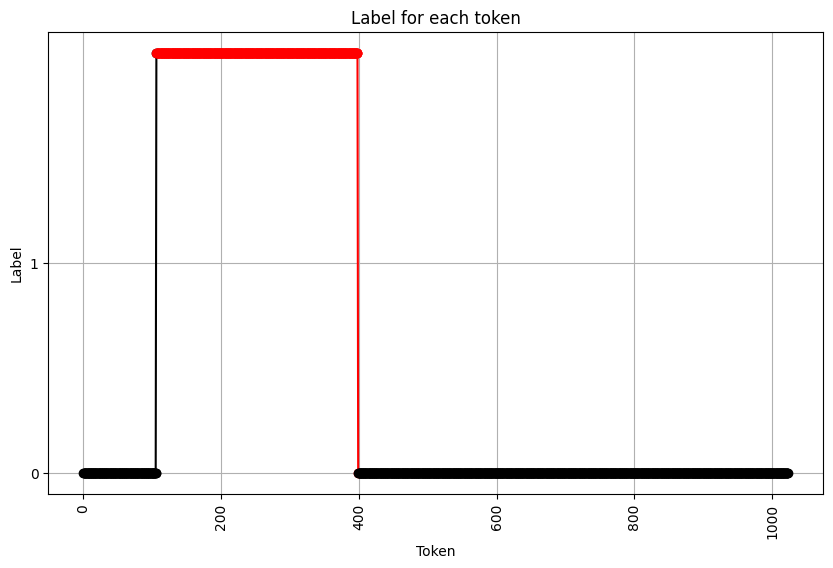



MSINRIRGDGGVIIDSKSFLELPKAPSKETADVIRSGMIRYNKEWKSFEGVLDFEDGTMAYRRFANLDANGKLLTSQLPDSVTSGLQFVGTYNPIPDDIDPPLAQTPLPAPAASLNGDYYVVRGIMDAAQAHYEANNPQTSPVTFTPTNPTGQGNWIEILYYVDSNPNISGAKLVTYAFARIIPASIPSTGHDGLKNLATDADLTKPFASGVPMNQTALSDGDWIIITEDKNIRLRQSRTSISAASVLYDNTVMIANHRQFRTNAGTVQTSIDNVVIECLRRTGDSMYNDGTDGSGRFGVVYGSAAAPALTFNNNPFDPTNNPGNDPTKWSDANTGIFHPADDAIGFSTAGTERVRINNSTLTLYQSTSTPASTPVLRFDNATNTNVGLSASSNIISFSSMNKVQVEFKNGESAFHGNIVVDGTSTLTGDTSASNITASGNLNIQGNTTLGDAASDTITVNGVSTFTANTNFNGTTNKFKNINLLANGIITLESATNQSTIQLVSSDLKLSMGNYADVSIYDNGTIRTRFNRYGIQLPVLATIDNSVGVDGMIAYSNTERTSMQKVQGQWVPIGSGSVRTDAFTISSWVLSGNYYTLTVTASNIVTAEIQEQVSPGVYTRVEVDSVTFNGTNVVFSIPSTPDVRFDGRTLVTIR
(1, 1.0)


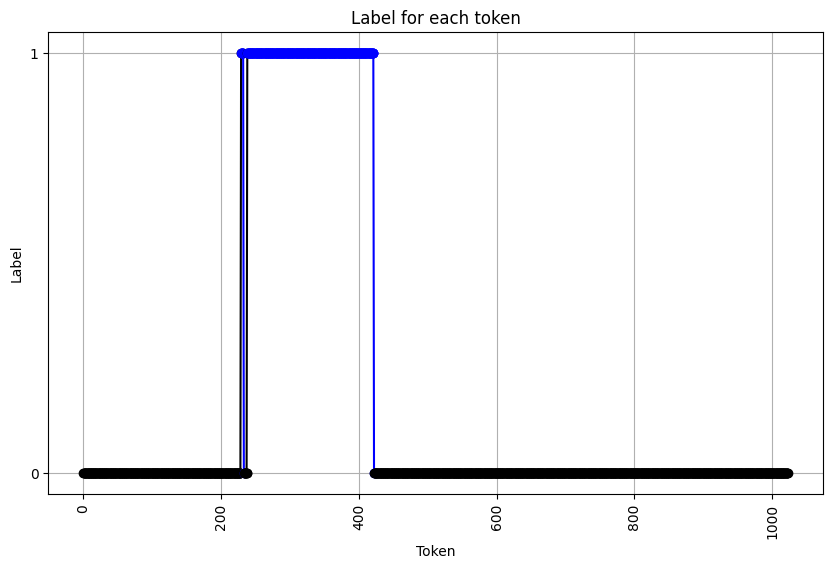



MTQEQNFDINDGQNFGVSNVAEFYNDVHVYGKLYADLVGGLSGDGGSLTVDALIVNNNSSFFGDVSIEGLLDTDYLTVFQRLDVGAGGTVFTAISTTNGRDGEGQIGGRVGIGSTRPDALLQVGEQLNSLVVTDGGNVGLGSTTPGARFQVGTECLIVNTDPCSVGIGTTLPQQKFQVKTGTLGAVISDAGQVGVRTSTFQGTEVFKVNSTDNSFVITDTGNVGIGSLDPTAIPGYNVADGIIKLNVEGTVKIDRNIIDSADSSGANGYYLARDGNGIRWQQASPVSLDGMYVQDEGANLPVSGTAQLFQYLNFVEIESQGLGVDTLLPIPDPVNPTAVAKIQTQALWGHTNSANNSPLYRMSKIGILNNSPSTELDVTGEVHATGNVDFDSQLNVDGETFLNAALDVDGLTTFNNTTDATSTTSASVQLDGGLGVVKQIYIGGIARVQDSTDSSSCTTGALTVAGGVGISKNLNICGDQKIESSTESVNCTTGALIVTGGVGISKNLNVCGDADIYGTTQSVDKNSGALVVDGGVGIEKNLNVGQNTKLTGSLELESRIIDKFDSNGVGICKTDYRLSSFDVSGVGVGVSWRPPGVQTKKTIWVTKNGCDTNSGLLEGDAKYTIAAAAVVAQMGDTIKVRSGVYYENNPIGLRTDVAISGEDLRLVTLVPENTSKDFFHVRNGCLVENVSFKGSAGTETLHHGLAAVAFPPTDAADQAVTGYIELGPSNEGPRGRYQSPYVRNCTNFMTGSIGMKIDGNHVGAAYTGTNNLGQDLKSMVCDAFTQYNEAGIGVSITNKGYAQLVSIFTIGCEKAIYCDSGGQCDLTNSNSSFGKFGLVADGTSGVEFDGTLNTKMEAEADKIDVTNCQDQSNNNRTPFDGQGAYFHLDMNDYPDTISTASITEPMQTIRSIVVVNGGNAGDYSASAPPLVTATLPQGPESIIAEFSPNVSAAGTITSVDVIASGRNFLPTQNIVMSISGSGNAQLTADMDPILYTVD

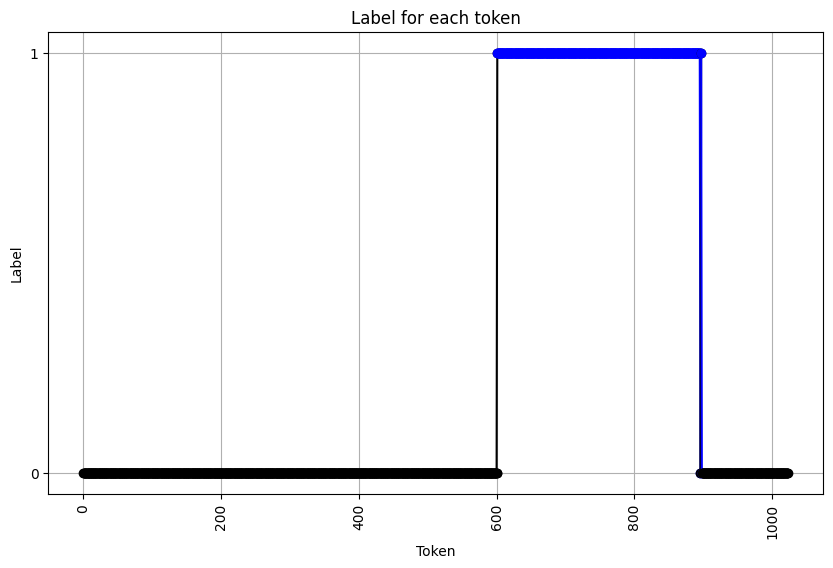



MSTNQLRPKYPSGIEAQERSKFDKGIDTDGILNTGLIEHAPGAEMTVPADNTAGDANIAGIRYNPDNDEFEGGYGDNSWRQLGGGGIRWEQADKNSPVHVAKAARGYLIDNRLGQSQIIFPVVTRVGTIIAIADQFGKFATLPLTIKASGGKIYGQTDDMTISTNNVAATFTWTGQEQGWIITSGVGLGQGQVYNRTIFSEVLTAPTSFINVNHATEMVDVYINGARLAEKRYNLADTGVALKEEIPAGVEVQVIEYKPIQLTISDEDSRLKELENQVQALKDGPIIWRYTATGGETVLNPGTAFTRCKLEINGIGWDIDDYSIVDNKIILPEPLGVDPISGQGDRVKVTIGFDNDVGFEGYVSKQELADEDGAKMVGTSLVSNLDDVIAGKVLQWSVGVKVTSPHQIIQYAEKSYQYIGYLPRVVAGANPMADGGVWSVANPAGVWVPVGDLGFATTIGATGGAAMVGMKNGGNLQQAIGWVTPEQFGAKGDGVTDDIAAINAAVGTGLNVIFNASSTYLIGGPIILPYTATWQNLFGNDAVIKAKSHFLMFQQKDFDGNVGMNTAYKNFYGIRGVGTAHAKSVYTQVVQSQFLRMTNGTASDCSAIGFCNGLSLMGGARVFNFYADDIRNAAIRGEGENNFLVGMNAGFIAGDVVLIKSNYSYYSNLFCEYAGVSPEDTEEPASLRDQGAMVSFAQDGQNAIGNVVDTCHCLNYGGAFAVFSGSYNKMTGSLYGGAFVEARRAKGAGNAIYMSGSYNMIADVQLDLVYSGVEMHTGSSHCSMGYITIEAKSGYGTYAISINGTTTDCHIRGLHVKRGLTKSADAYLGTDGTDIGELKLENFTQPSSGASPVRVLGSNIIDRLYVSQSPTSTSTFINVTIQGNAQIRDLQIDGCLGNSLLVTAGAVPNLGTVQITPNQSSTVPPCIFSGTDTRVVGGLNIRGGSAVGQPRANGTLWLGSYRGPTWARADSAVAGTVHYPDPVAHSL
(1, 1.0)


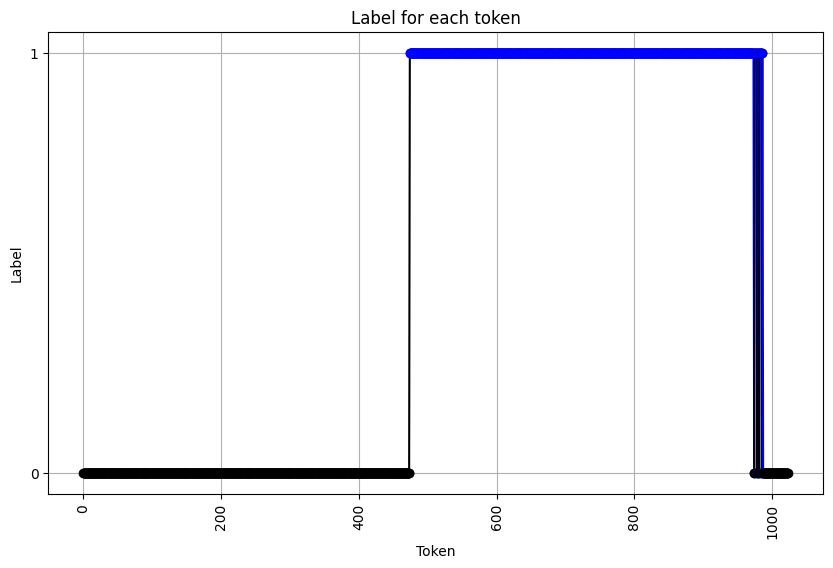



MKYLFILLFPLFLNSQIPGTDGTGSVDDTSALQSWIDSGSLTKPLGNEIYLVSETLDIDQIGAQEVDFNGATITVNSVADRYAILIDKPDRSLSTLKNLTIDGNDFQRNGIKVESPVFADNVDILDFYSSTVSIIGWAININLTNYGDFTFTNCDVTKMYSEYNSIIGDVLGSARAYDIQVSAMPPNTFTVLIEDFVWNGFYGDDGGPIRVDDNTSENMSITNNSVTLKNGSVTAFTRRGIKMAMDNITIDNVFYKSITTSNPFYQYAEPAGLIGARPLDTDPNGLLDNIVIKNCTFDGSGNYPWALIDKANAKWSNNTFVNGAGIRIGNIGNSEIGDVVICGSNFGSGSKIHQQLTTVSNKAGTNIIIDSNNIADSNYLEFTTLNYIEQVVSDCITYEPEPSTSTRNQKLIYWRY
(1, 1.0)


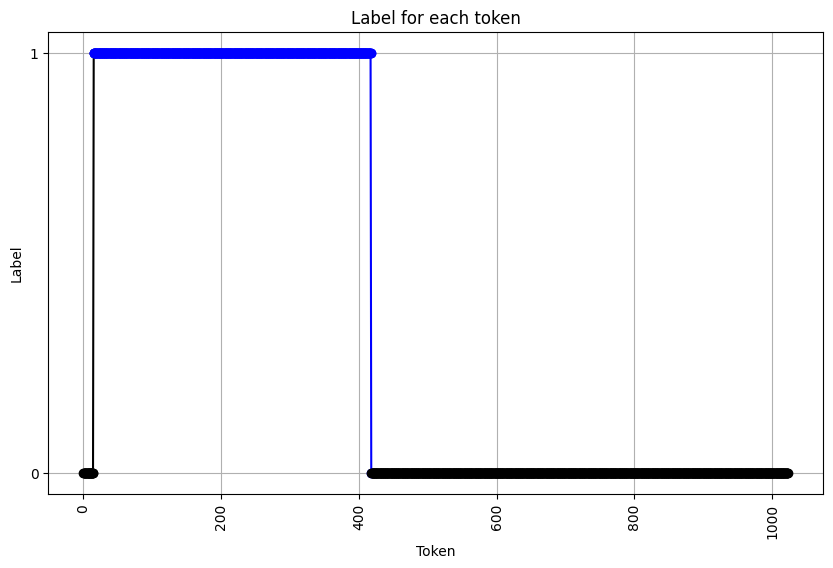



MLPFARMMNYGNIVPVPLQIKKIIPTDLDVVVLYTDGQLYARGNNSFGKFGRGNNTALKSWTLIRENVNDCWLTQGTLLVKDNDSNYFYCGYGDHLGLPTSTTTFLSYNQYIENLYTQSSSTSIKQMYGGTTWFTVLMDNNTIWSTGWSGARQFADGTGSTQQITDGSFVKAVTPNVDIAQIQSTNNCVMFFDTQNNLYIGGGTSGISTSTTWTPFNEYTLYKPSTTYTKTLQYTGCSSGAVSALVENPSSGARQFLVGGLASNGAWGNNTTTSSALAVLGSNSTTLPTGTLYSIHTGYPTQSSILVTSTGVYATGLNASSYAGSLGIGTSATVGKFTACPMPTQITYSMYDKIKIYRGSYRTFLTADMKNIYSTGTYDDGGPSTTRYVLDTPRQL
(1, 1.0)


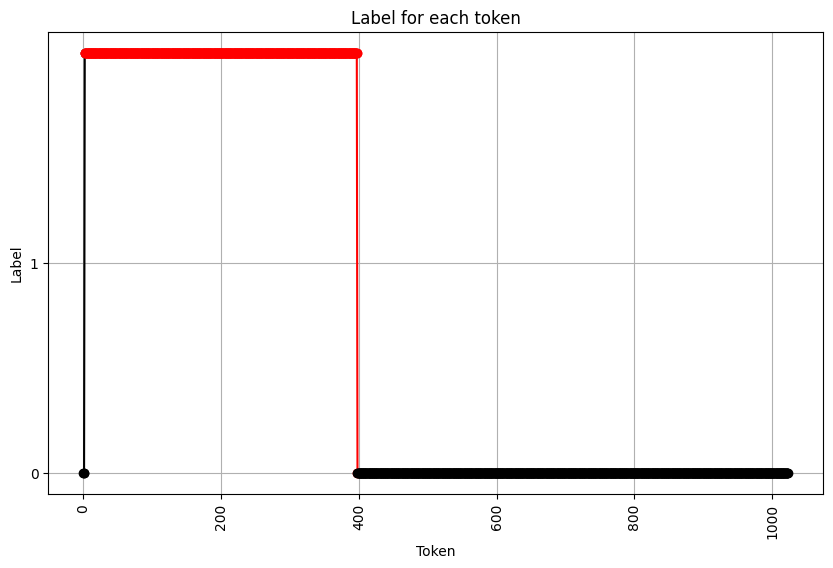



MWYAGNGASFGLSTDKSTTWSSAKIVFDRITALGKTIKQIVVSAGALSVLCTDNTIWNTGYGSYGQLGNGRSTDSLSSFVQGTVPTGVTPSKILANFLMQGFIGTDGRLYYTGAISGVGTTDMTLYSKYTLCSQITNTYTVKDYTTNSSYFAFAIANNNSTNKLFAYHGGGQYFGQLANGSTSQTYISLRQTTQAPGDIIRSSVGYSYFSNHIITSLGVYATGNNTGDNAGQLGIGTQTDVSAYTKCVLPTEMNMNNVYVTATLYRTYLTDGIQIYSTGQNITDGGVASTVFVKDSPF
(1, 1.0)


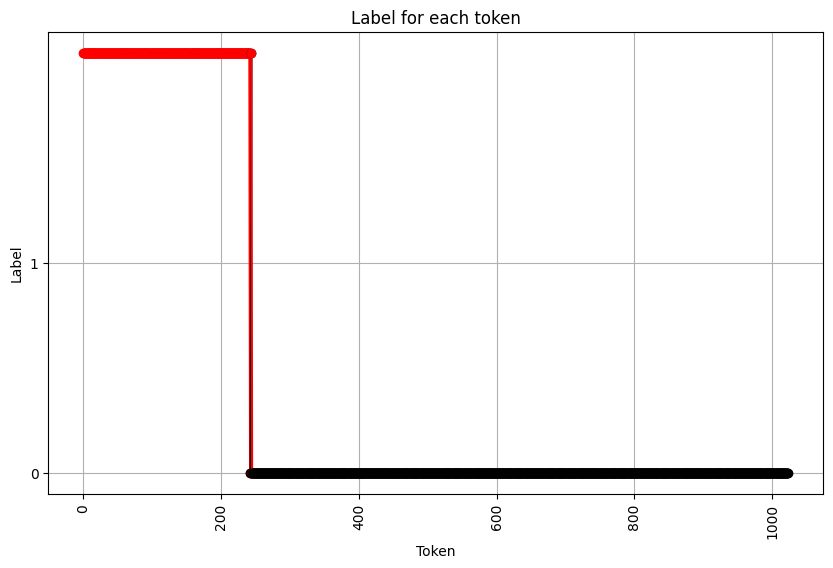



MGLHVQKAQLSVIKLSDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK
(1, 1.0)


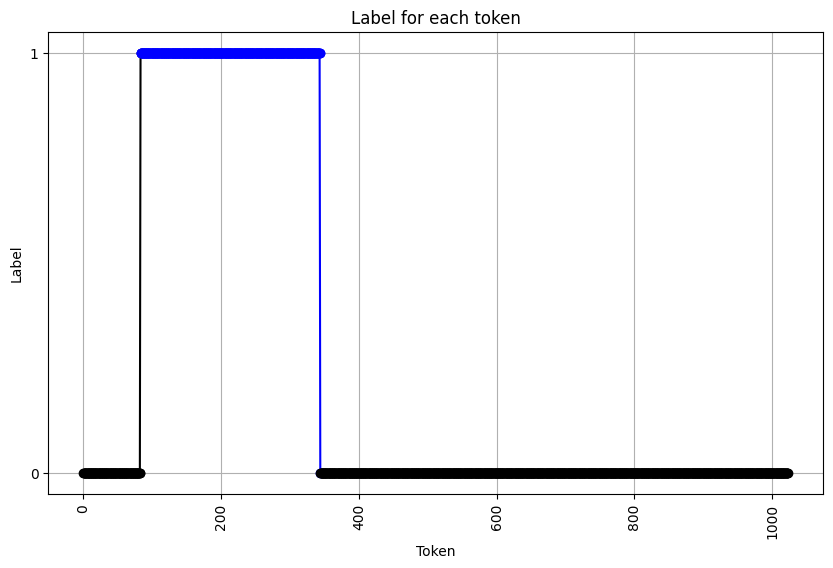



MGLVSQSIKNLKGGISQQPNILRFPDQGELQVNGWSSETEGLQKRPPMVFNRKLGAAGFLGAAPLVHLINRDEYEQYYVVFTGGDIKVFDLNGQEYAVRGDKSYVQTANPRNSIRCVTVADYTFVVNRERVVQADGNLTNGGTFNDQKDALINVRGGQYGRTLNVIFNEATRATIKLPSGTGTTPPIEEQVAAVDAQHIAEELAKQIRESLAGNPGWTINVGTGFVNIIAPDGDSIRGLQTKDGYADQLISPVTHYAQTFAKLPQNAPDGYTVKIVGDTSRSADKYYVRYNLTRKVWEETVGWNIQVGLNNGTMPWSLIRAADGQFDFVANSWVGRTAGDDDTNPHPSFVGQAITDVFFYRNRLGMLSGENIILSRTAKYFNMYPASVAVLSDDDPIDVAVSHNRVSILKYAVPFSEELLLWADEAQFVLNASGVLSAKSVELNLTTEFDVNDGARPYGIGRGVYFASPRATFTSINRYYAVQDVSAVKNAEDMTMHVPSYIPNGVFSISGSSTENFATVLTSGAKGKVFIYKFLYIDEQIQQQSWSHWDFGDNVTVLAANSIGSHMHVILQNGYDIFMGSISFTKKTLDFGNEPYRLYMDAKTRYDIPANAFNNDRYETTVDLNAVFGGMRWQVGKILVSDEVGEVRQYEPPAGGWASDPTLRIVGDMAGKRVFIGFAYEFRYEFSKFLIKKQDESGGFSTEDVGRLQHRRAWLNYEQSGAFYVDVTNLGRSYRYTMSGKPLGDTTLGQANLESGQFRFPLAGNAQYNRVVLTSDYTTPLSIIGCGWEGNYIRRSTGI
(1, 1.0)


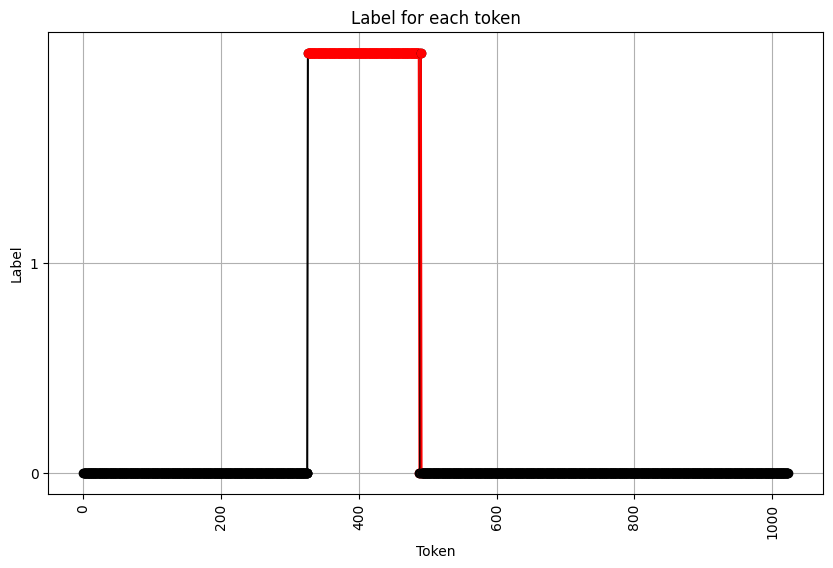



MNPQFAQPKGSTSKESNKDSIARKFGCKKSEVVYAKSGQSLSGYKVIYDKETQRAYSLPVDIPAGTTAISLSASALLVHSGGSVDLGELASQRNEYNVLPGSFTTGAIVSTKNDVLTHNGIQYRWNGSLPKVVPQNSLPSSDDNWIGLGASYLKEQLNSTSGASMVVLANGKTIEEEFAEEAAWQNQENMVRTVIPNVYHHIRGVQRHSGKNLAWSAPDVAIDKLNPTDTVFYRMPQIVKTGDGTLMIFCNELHGNNTDIGATPDQQCNIVMKYSIDNGWSWSAKVVVANFGATYQNGEIAAVYNPVDGRVYCYFTSCKGQLGWGYSQPGNDPNTSSQIYVTYCDAEAPTIWRTPANITATLKPATADFIWTSPTKPVVLPDGKMAMIVSTVTGSRVDSFLTIMKYDIKYSMDYVLSSEESGGEVGLNLLPDGRMVMNSRAYHTTDLKGLQKFYISDHQFKNWQHLSDLVTSDSKGDLVPIFDGVNGVLTWAFTCANGVGDNSIGRTNYRVWISRDLVTWGLAPTGDINTSDSVGYIASMPGGDDGYVISTSESGGFGGIWFTQWNAKYIQNRNYNRYHKELRELESVDETAMLASGAIPNYSFYVNKDSNLINFNRNGTPVKIQQLGVSQNAVDKYTTTQTLASIPVDGVDIVLVTGSGITLTLSGFSGGYMGQRVTVISDSSGGGVVLKRADTTLPTVTDRFHFNVAGAFTALRVDYATKMMVTLVKTPSGWFTESIANVTI
(1, 1.0)


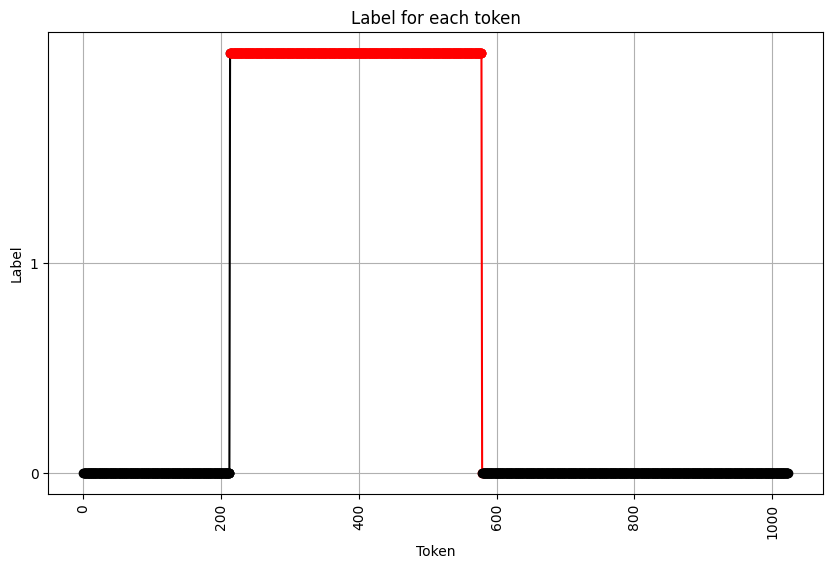



MLDNFNQPKGSTIGVLKDGRTIQEAFDSLPRLESFSGSTATDKLRAAITLGVSEVAIGPVEGNGGRPYEFGDVVIPYPLRIVGCGSQGINVTKGTVLKRSAGASFMFHFTGEGQAQRPMGGGLFNINLNGDTATALGDIIKVTQWSYFKANNCAFQNMAGWGIRLKDVMESNISGNLFRRLGGPSGGGILFDDVRSAVTDNVNNLHIEDNTFALMSGPWIGSTANSNPDLIWIVRNKFEFDGTPAAPNTVDSYVLDFQQLSRAFIQDNGFTHFTTERNRYVGVLRVGATAVGTIKFEDNLLFACESAGLIAGGIVVSRGNVNNQGSATTAIKQFTNTSSKLCKLERVINVQSNGNVSVGQQILPDGYINMAELPGNTRLPSEYDADGETTSVLRVPANTQVRQWSVPKMYKDGLTVTKVTVRAKGAAAGAILSLQSGSTVLSTKSIDAGVWKNYVFYVKANQLQETLQLRNTGTADVLADGMVFGKVDYIDWDFAIAPGTLAAGAKYTTPNQSYLDVAGMRVQAVSIPMFDGPTTGLQVWVEATSANGSFVVVMKNDTGSELVTTVTRCRVRAFVS
(1, 1.0)


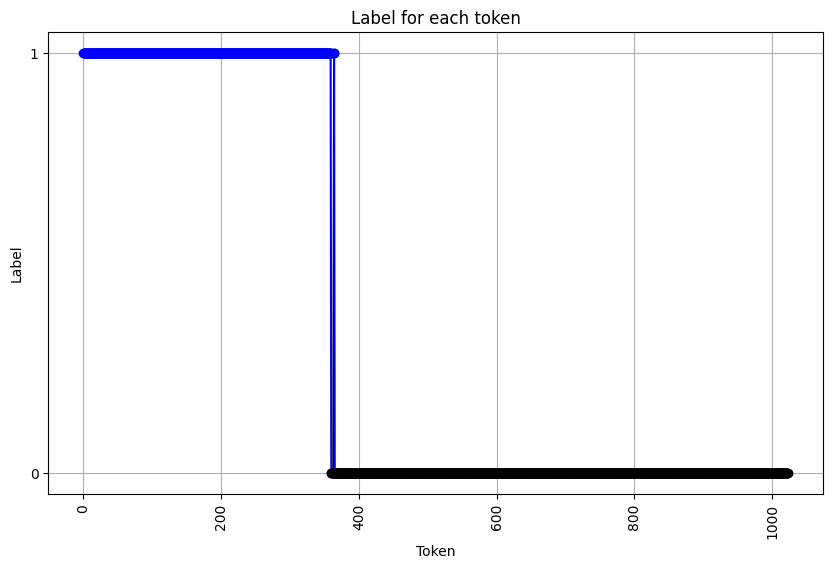



MARPKIQERTPDLLRVEPFLGLNVSQAAEQINDHQSPDLLNVIVSKTGNLDKRTGYKKAFTTSLGSGRITGMYLYRKIDDTKVFLFGWDTKLYKLENGAPVLLSSTFSGNELSFFVMNNKCYIQDGTKMQVTDGVTVSDIVPYIPTVSISKTPLGGGTPFEDFNLLGGGFKDSFSGDGTAKDYQLSFSGIDADKVTATVDGANKVEGTDFTVNRTSGKVTFTTAPTKGTNNVIITGYKRRQDLERKIHKCRINVLYGGANDTRVFVAGNVDLLNVMYGSGVNDPTYFPENRFYQVGADSEYIMNFAKQFDTLVIIKERSIWGMSFELKDGVPSYPTKPLNDTTGAVSRNSVQVLDNTPVMFNDKGVFSLTSSNVRDERNVSLISEDINPALLVEANKQNAKTIDYDRKYFLALNNRVYVYDYDIKSWYQFDNINACNFLEVDGRLYFGALDKGMIYMFMKPTDTYPYNDDGKAINAYWKSKLFTFDADELKKMVDKVFFSLKVGKASSADLYYITNKKYSNLIKNVEINGFMDFRFLDFNNFTFNTSAFPKEAAARIKAKKITHFQILFKNDRLNEGMGISSAAIKYRYMSYIK
(1, 1.0)


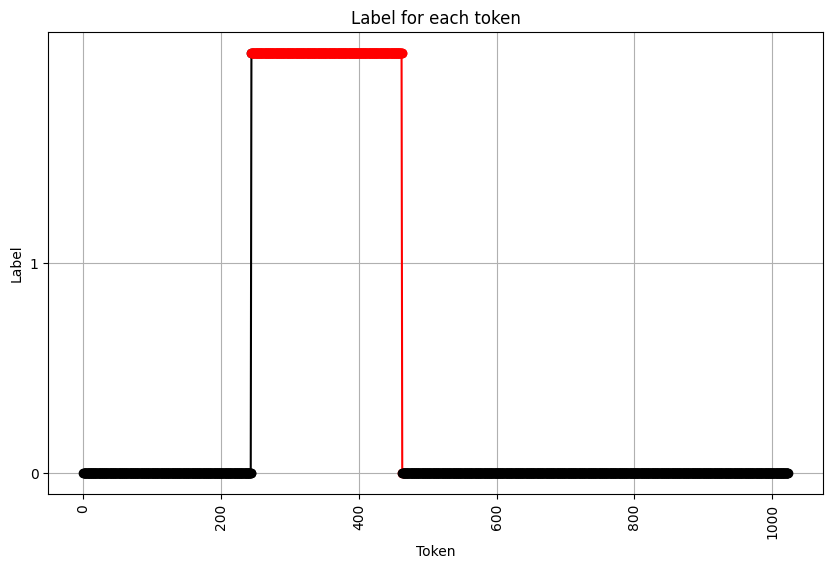



MPTTWYPYDNGTVGPTGPEGPQGPPGSAGTPGVVQSVNGQSVQDVVLDAADVNALPSNANAQLDATYFGINKAAGNYRVLRWLTDGASRWEAQVDDVAEGGSAAGSDFRLASRNDDGSFNKTVIHAKRSDGTISFGTTVHHGAAQVTSYGAVGLRDIGADPATASGGTYVYSKSGKLFVKQADGTSFQIAQVSYPVTSVNSKTGNVTLGAADVGAISSVSGGTAGGTVRVTGTAGTYRTLGLSTGPTGTASDRWYFQADNAAEAGGAAGSDLVITGRSDTGTFQSHAMHAKRSTGQTSFGTTRPLGEAQTTVAGAIAARDRTTDPATASGGIQLYSKAGLPYIKQGDGTVFKVGSGGGTGGGAVDSVNGKTGIVTLAASDVNALPISGGDLTGAVNINPTSGNTLTAYGSTDPATYFRVTADGHPYSNSLRATFYNLGVGDTGAPFGGGKFMLGIKDASVLPTSNPTNGVIAYSEAGKLKVRQTDGTIVTVANAPVSSVNGLTGAVNLTIEDLEGVSVSNVGQANGLATLDSGKRVPLAQIPLSATPGAFQPEDLGLKAWAGDPATCRSGYRDGSTGKGRMAAVVVRQTTTVSKIVWHFLGYAGGMKTGSWAGIYNTSGALVRGTGDLSTAAYEPAEQHGVGGGCSTSNLTSSVTLAPGTYYIAWRFNYTASPADGPLLMAFESTDVSATLYGLNAVRRFGAFATSATTAPSSVSGWETDPIRFWVALA
(1, 1.0)


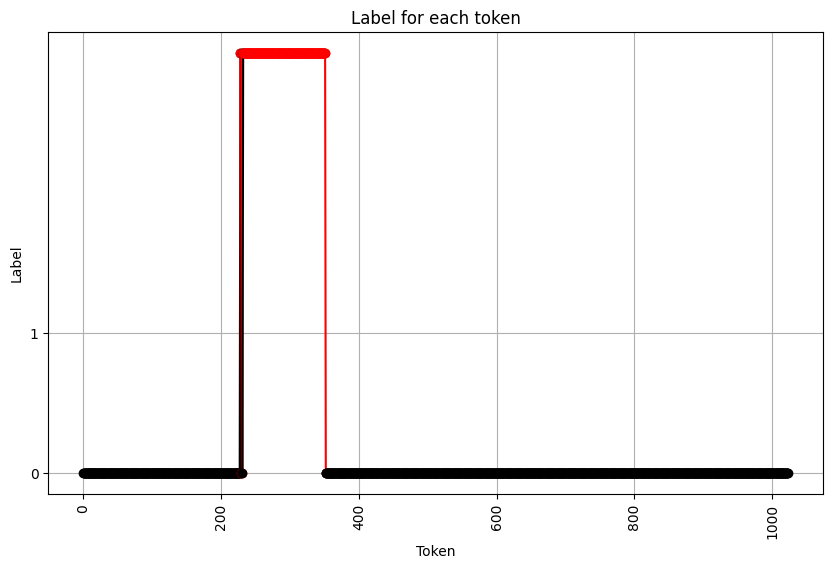



MASQSHGFDNTIVFGKETEFGVPAGNSSYGSIGVIEEFSPEENRNIVARNSLGLRAPFSLRQGTNETDASISLAVQNGKPFAFALGHVTTVENPDVEGGYIHTIRPTRAGEQLPSFTAQNHNALLNWTRNYVGGKMDTATITASSDDAVTFESDILFATVEDSTEEPVPVVLDTENFFMFYEGFAELNNQPFADVTEFECEISNNLERRYTLNGKNRADRVQEGNLEITASLTVDLTSKEVYAQFANGEDLNMKLTLQDQYDENHKIVIELLGGKYDTNSISVTADALQEQELEAVFTDVVVTAYDTRPNLI
(1, 1.0)


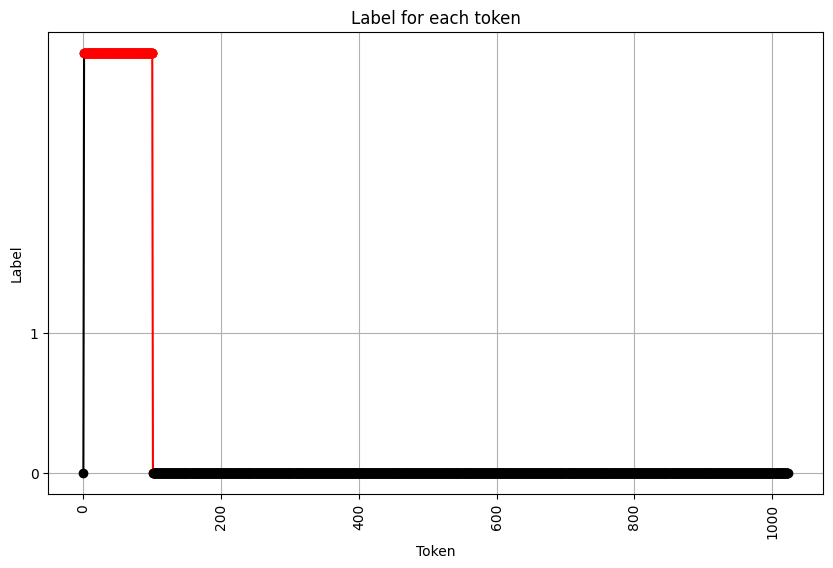



MAFGSNIYVAIGATGVYESSDKFDWKRTSDLQFSHVVYANGFYAVAADGIYVKGADGWALAHAFVIPVVCARNVNGEALFGTTQGTILRSSDWSEVSVGLGAIWLSDSSDDILDVLLVRSDYVESLQGTLNNLVSTGTTEIDGLTVHACAYDDVNKCVVASLAFDGQPMFAVLKNNQWLFSIVALDEPAISLARGAVLTSNAVYTTTDYVSFTLLHSFADFEAQTLAYL
(1, 1.0)


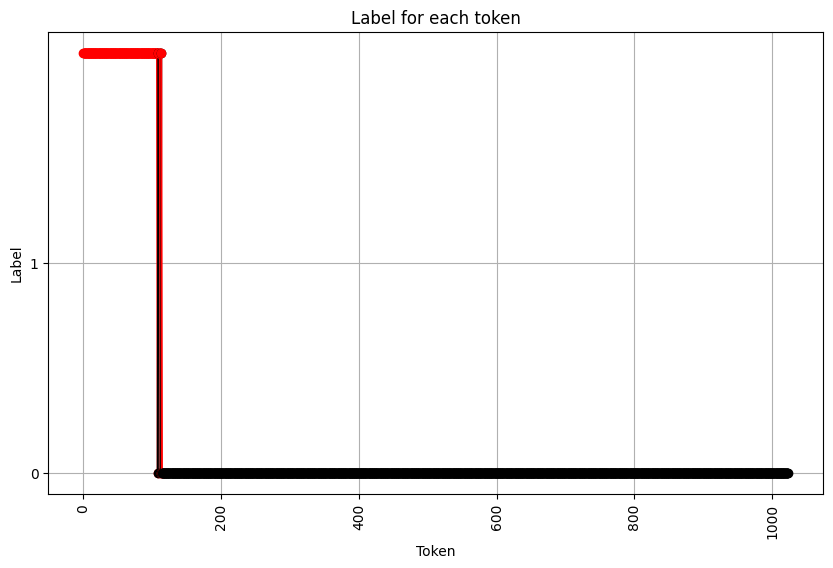



MEVQGSYGRQLQGVSQQPIAVRLPGQVTSQLNAVPNVVDGLKTRMGSKHLARILNSLDANSLIHHYKRGDDAEEYFVILQPGQVPVIFTVGGLACPVNTQGSAATYLSSSSLPRETTQLMTIGDYTFVLNRKMPVQARGDVTPSLDNKGLVYVAYANFSFTYQILINGQVAAEHKTASSEDVKNEDLVRTDYVAGKLLENFNSRTASFPGFSMYQDGNVLVVDNSNGANYALTTVDGADGQDLVAIRHKVTNLDTLPNRAPVGYKVQVWPTGSKPESRYWLQAESQDGSKVTWVETIAPGVRKGWNAATMPHVLVRESLNANGSANFTYRPGEWEDRDVGDDLTNDFPSLLNDSSPQPISSMLMVQNRLMLTSGEAVVASRTSRFFDFFRYTVLATVDTDPFDVFADIEEVYNIRWSAQMDGDVVLFTSDQQFTLPGDKPLTPTSAVIRPVTQFKMTPGVKPAPSGDSILFAFDQGSYSGIREFFTDSYSDTKKAQPATSHVDKYIRGKVLELSASSSFNRAFIITSSDRNILYVYDWLYEGTEKVQNAWHKWSFPAGTVLHAVSYSNEKLYLVLTRTNTSGGVAGVYIEVMDMGDELEYGLQDRVRMDRRATLSMTYNATTRVWTSSALPWLPQDLSSLDAVLVSGWAGYVGGAFQFSYNASNNTISTNFDLAESNTATIVVGETYWYEVEPTPPLIKDSKDRVSYLDTPTVGNVYLNLDMYPDFSVVVTDKETLQERTVYLANKTAGSITNVIGYIAPHEGTLRIPLRRKSTDVSFKIRSKSPATFQLRDIEWTGSYNPRKRRV
(1, 1.0)


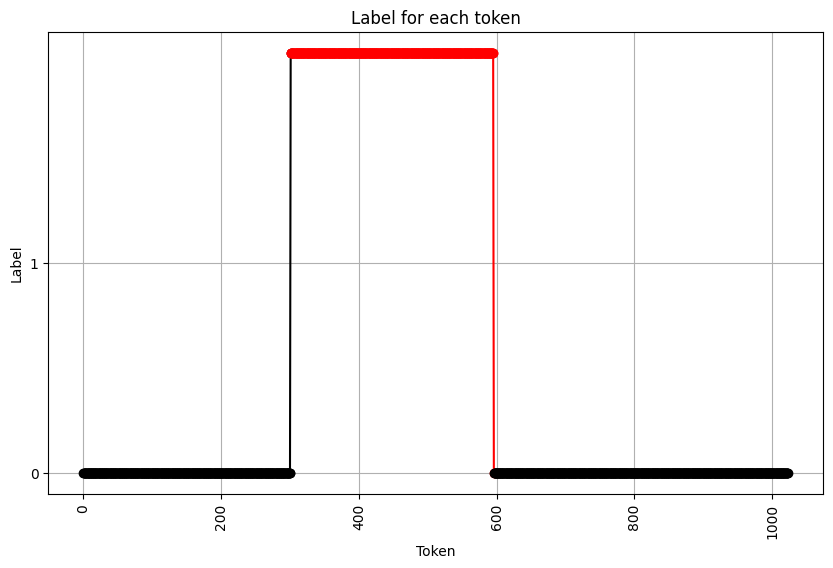



MEVQGSLGRQIQGISQQPPAVRLDGQCTTMVNMVPDVVNGTQSRMGTTHIAKLLDEGTDNMATHHYRRGEGDEEYFFTLKKGQVPEIFDKHGRKCNVISQDAPMTYLSEVVNPREDVQFMTIADVTFMLNRRKVVKVSNRKSPKVGDKAIVFCAYGQYGTSYSIIINGTTAASFKTPDGGSAEHVEQIRTERITSELYSKLQQWSGVNDYEIQRDGTSIFIERRDGKSFTVTTTDGAKGKDLVAIKNKVSSTDLLPSRAPAGYKVQVWPTGSKPESRYWLQAEPKEGNLVSWKETIAADVLLGFDKGTMPYIIERTGIIDGIAQFKIRQGDWEDRKVGDDLTNPMPSFIDEEVPQTIGGMFMVQNRLCFTAGEAVIASRTSYFFDFFRYTVISALATDPFDIFSDASEVYQLKHAVTLDGATVLFSDKSQFILPGDKPLEKSNALLKPVTTFEVNNKVKPVVTGESVMFATNDGSYSGVREFYTDSYSDTKKAQAITSHVNKLIEGNITNMAASTNVNRLLVTTDKYRNIIYCYDWLWQGTDRVQSAWHVWEWPMGTKVRGMFYSGELLYLLLERGDGVYLEKMDMGDALTYGLNDRIRMDRQAELIFKHFKAEDEWISEPLPWTPTNPELLDCILIEGWDSYIGGSFLFKYKPSDNTLSTTFDMHDDNHVKAKVIVGQIYPQEFEPTPVVIRDRQDRVSYIDVPVVGLVHLNLDMYPDFSVEVKNVKSGKVRRVLASNRIGGALNNTVGYVEPREGVFRFPLRAKSTDAVYRIIVESPHTFQLRDIEWEGSYNPTKRRV
(1, 1.0)


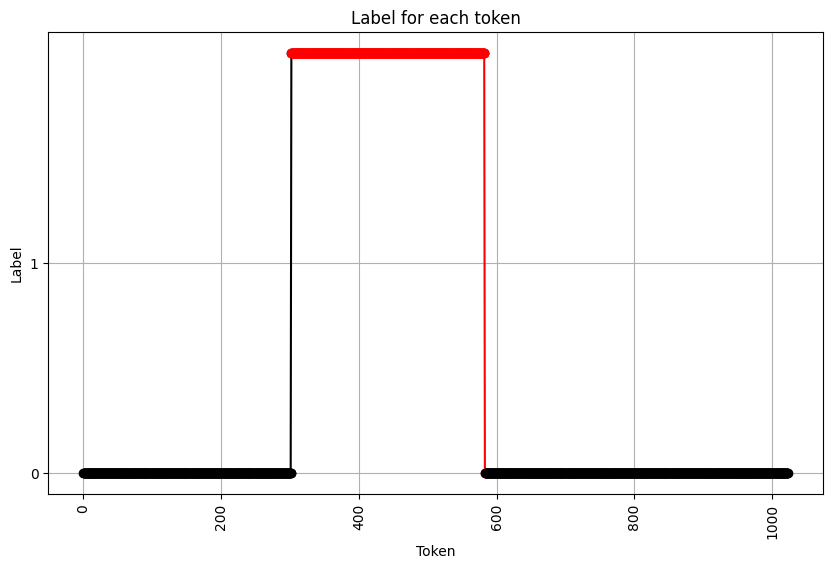



MASQSHGFDNTIVFGKETEFGVPAPDNTYGSLGVIEEFSPEENRNIVSRNSLGLRAPFMLRQGTNETDASVTLAVQNGKPFAFALGHVDTVEDTENAGNFIHTIRPTRAGEQLPSFTAQNHNALLNWTRNYVGGKFDSFTLTASSDDAVTFEGDILFATVEDSETAPVPVVLDTENYFMFYEGFAELNNQPFADVTNFELEIANNLERRYTLNGKNRADRVQEGNLEITASLTVDLTNTEVYNQFANGEDLNMKLTLQDQYDENHKIVVELLGGKYDSNAISLTATELQEQELEAVFTDIQITAYDTRPNLI
(1, 1.0)


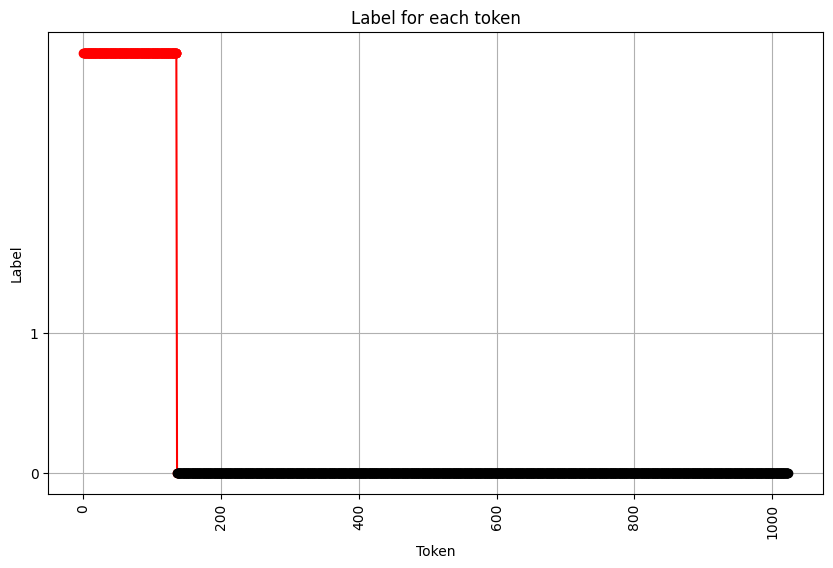



MAEFRLGRLKFNWRSDWTISTAYVIDDIIKYGANTYVCKKNHTSAGAEESFYSTDLTLNWSLHTEGIVNKGSWAANYWYKVNDIFKYGNTQYRVTTGFTSGATFDEAATTTNVVEYLQSFNYEDTWSNSTQYQDGDVVTYGGYTYVAKSVNTNKAPSYNLTNDWDIITTGFSVVGYYSTTTDYKQGDVVQYGGYTYVAITTSTNTIPTTPANWTLVTKGVSWKGNWDSTVKYELGDAVKRLSNSYIGVATVGSLNEDPSTDGTSTYWSMLAEGAANNVMTTQGDMVYYTTGSARLPKGTNGQVLAMSSGGVPNWESNSVTHPVFYVTEEGSDTNDGSNISRAFASVRHACAKAAETGNPCSVYVKAGTYSETLPIVVPPFVSIVGDNLRTSRVKPGVHYAHTFISGLTGSITADSGGPFTAGSGTTYDSATGDLVLEIGTHSLTTSNTIGINGNSLTFTCSQDSHATQHTYPRPKDPVYNKTDIAIIATTGTTITVRVGKGNASRHQDLVLASAPSSVSYGSSIFNGAGTKCAVILDSDYAEKKIQIRWLSGGEWTTSDEWENGGTDIGITSVTTRPNEESTMFMLSNATMLKDLLMEDMTGFSPAGIVTTISCSIAGSKVTGSELFPDLVGTTVTGSGVSTGTKVSGFIDAQTLEVDIVQNLGATDLTFTAQQYDPNNAHIKGTFCALNPESRVIKSPYVSNCSAKSVRGIGAVVDGGVHRQFVDGSATPSNKSIVFDSFTNIHDEGMAFWITDGAVAETVSCFTYYNHISYAATRGGRLRSLVGNSSWGKYGVVSSGFSPLEKAREGEIEGLVLQYDVDSMSGSGFQVGERIRGNTSGAWGYINSVQGTTQEKIYYSVISEGPVGVGTGFGPGETITAMTSGTTAPLLNNTSANEGQAGRILVLSGLGTSPTLEVNGSIEFITGLGNGGYNSDNITGADPFTFVISGVSQTGPTGKGNVQIDRAQWSTTGAAHTGGSTTFVKYPVNIGASFTLLTP

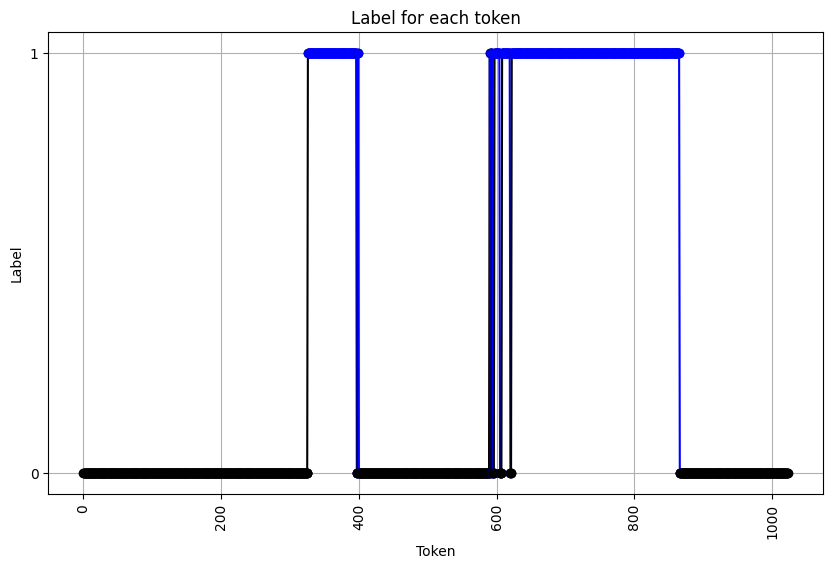



MISQFNQPRGSTSVEVNKQSIARNFGVKEDEVVYFTAGIDLSGFKVIYDESTQRAYSLPSGIVSGTTAISLNEQAILTHSAGSVDLGELAVSREEYVTLSGSFNFGHTINVKNELLVHDDKKYRWDGSLPKTVDAGSTPETSGGVGIGTWLSVGDAAFRQEANKKFKYSVKLSDYSTLQDAATAAVDGLLIDVDYTFTADESVDFSGKVLIIECKGKFIGDGMLVWNGLGAGSVIKKPHMHTKTTPYTVYRFDANGNWVTDPTQVLASVQQRLDVGYKPNINDLDIWDDLPDNVKNQVAGATLRIMSGDNIIVENPEATFGGYLFTLCNRILVKNPRNFIALESGITFENHHTTAWGTGNWVVGGEIKYGSGSAVLFIRNDGGTDHDGGVRDLISYRVGESGVKTYQNEIGGRSARNYRLVFDNITTIQCYYDGIDVNADTGSPTERVDDYSLAEYPWFHLPTQHIIRNIITRDCMGIGAWWDGQKNIIDNVVTYEAHKEGVFDRGTNNDITNITVVGANKDLTNLNQITCEGGSRLRGINIHAYTTQGYAIYAPSSEVSNVSCAGSGTKKLLCTYISDIQGGNINVQHSANQMTLAMQPAMGGTTNPSLLMTADCQIATPGGEASIVKLSAIQEGVRVGEFQLNRLGFKHMSIPAAPLQLPESALEHNSSIGFFFGSDGALRLLAKKPDGSYVTYTL
(1, 1.0)


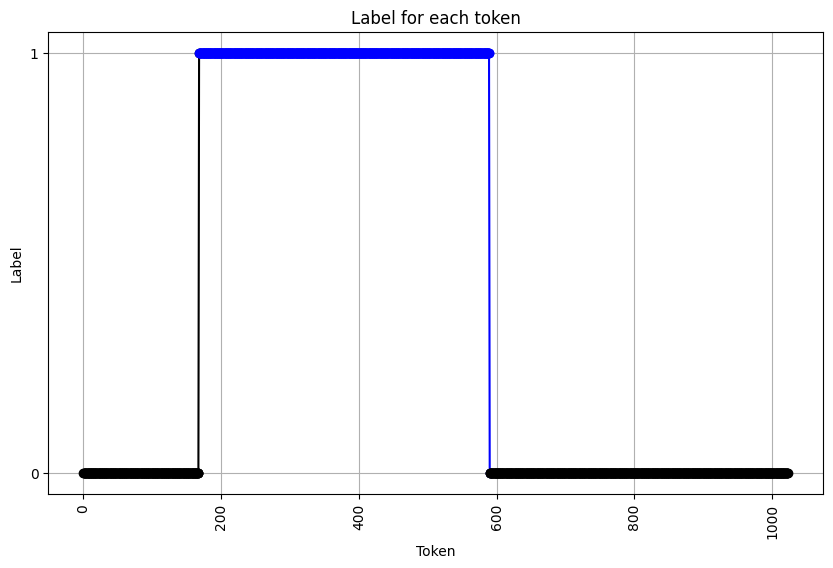



MENSKHVYFIDFEKHGIRSNGTAARETTDGFISALNDAVASGYKTVYVPKGNYLIDGVGEDKMPEYGGGIQFPSNIEVIFHKEAVFKVEPNSSTGYACFNLENVDNVILRGGCVVGERFEHDYDMNVSPFRRTHEWGYGVHIRGCRNILIEDMHISDCTGDCIWVPAHGMMNWGDTVYIPSESITIRKCRTEKGRRNNIATDGCLGLLIDDCDIIKAGGDTIGPQLGIDLEGYAEDGIKYGHPYEINITNCRFRKNGRGALNINVSAKVHATNNFSDDVFSYGYSSDVSICNNKIINDSGTVKKYGIDSIRKSSTETGNRAIISGNHVIGFEIGICARGLGVKISNNYLKDISSIGIYPYLAEEVSVSDNIIDSNCLHVWVRESKDVKISDNKTKGAANYFAYRVEASSDVIISDSKSQSKGGIQVLRSRKVVLKDNDLALIGTDYGIHWDKQSEVEVLHNTVRDAAMIAIAGNSELYPSIIKGNNIKDCTYLVGLYVNGGSDHILWDNDVSFKGTGSANGGYGVQLVGTENAWLMNNKVRVSNGRTLSSSYESRGSQNTMYINNALQTGKLNSHESDYVNGIIELPFSTQ
(1, 1.0)


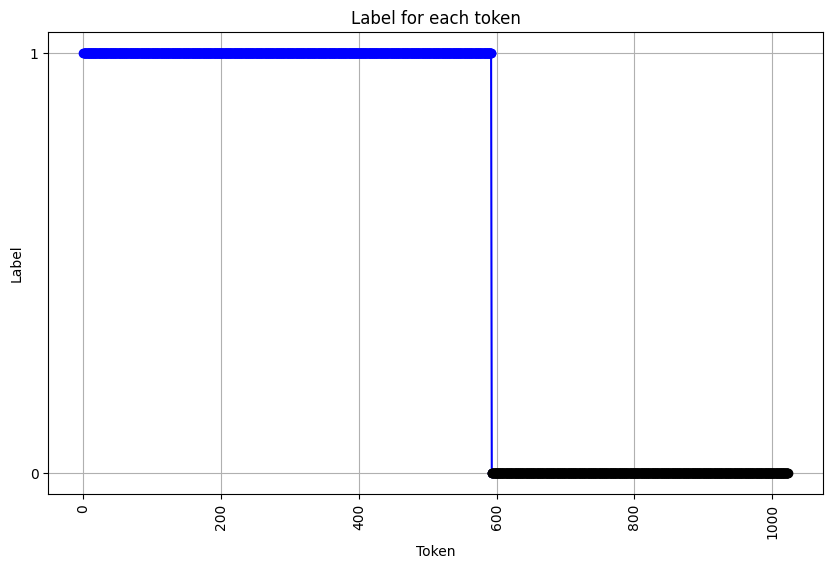



MIFKNKDISTNINERGVDIGSIDANFYTEDEQTASIRIFVKWNDKPVNLNLVNMRPVLNLYMQDGSIFEDEAVKIVMPESGVIQYSIPVNVIKHVGKVNAKLFLVNENESIHAVNFSFNIIDSGVEGPVRKELSFNLVDDAIRRIIQESTLSLLDDTFKADVNEALKAYVMANTNEFKGPKGDTGEQGIQGIKGDTGPVGPQGYKGEKGDTGEQGPQGFVGPQGMKGERFTYEDFTGEQLRELRTFVNAASTEQKYIPKTLKDSLLVTPPNNEPIKTYAQNIGDKYFDSFQSLNTVPSNSIGADSSIKMELNSYFFYTFKATDLLSPGNKFSIQIKSDQVDAKTLFQYNIVDVNNAYLVTNTSIPKTSEGEYSIENITIPSNASKINLRIDARSNTSITSLKSVFLFTGALTTLSTITPVESVVEQLSTDFYNLRDDYKEHKLQNELPEIQNSLPIKYIPPKNLALKNTVVSDKIYTDGQGKYHVLFDISTLKNKNGTTYYVSGNGSDSNDGLTDKTPLKNLYAAYKKSDVGTIMVEGNFKYQRTTSGYLLNAINKNINIIGYNGKPKIIASDNLTYTNNATYSNVKQANRTAVLRVIDLNNLEATGDYLELTKMNDLTSVSQTANSWYTDGTIVYINSESNDVQCLLDTDLINEKGEYNIYLENVELIGGRRNVKLDSSNGKIICNDVKMSYCVQSNGNGLEMVGGSQSISYKTEISKSMMDGFNYHKGINGELPYFIEIDCIGRDNGFEKGAGGSKSNNGSTSHDGIKGIRINGIYTRNDGGNTADVNAGTETLNLGCVIADGLQPYNLIVQDCNCYYEFCKSYGNNTAALVNGTGKLYNRMSQFIGNVKDIDGSNERY
(1, 1.0)


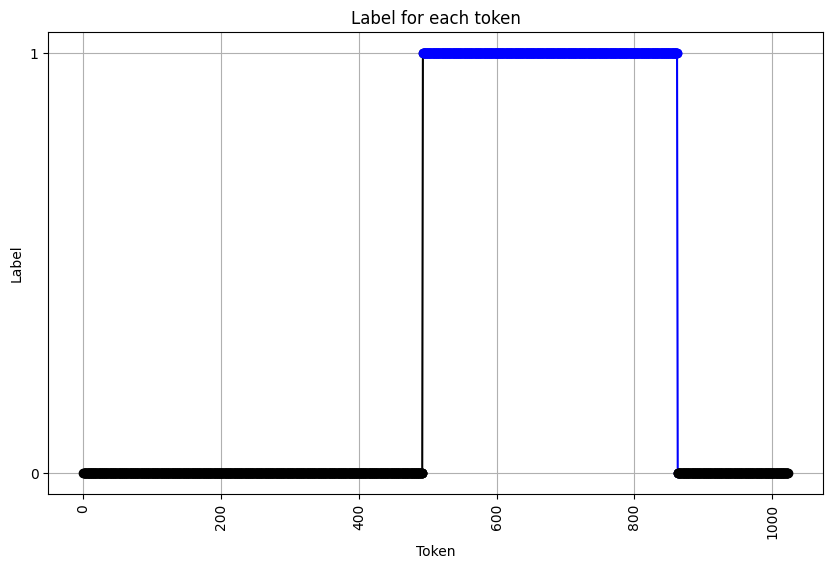



MSLSNLNSTNSKSMLINSGTFRSGVYITSPNQLLSYTDTNGMNAAYYYTGVLPYTTISNTPTSDSPLWKVLYIADKYSYLKTDIVPITSGGTGANTVAAANTAFGLGTGDSPTFQGLNILYSGNEPRINLNNSVLRSNAGNSLVISAQQGIYLRPAGDNVSTSQILYSPAGTLTMTGTSVNISGSLTLGSALALASGGTGATDAPTARTNLGLGTSAVVNTGTSGATVPLLSTANTWSSTQTIQGNLVVGVSGTSTINLGASAFMRDNGSKSLIITSNSASDASPAGLYLRPMGDTVSNVQIYGNSTGWSVNGNTQISGTFSNTGNASFLNSAYTVDSTGMYASSTGKVLGAVGTPWSTTYTNTLTSGTSAQLYLNSTSGTINLQNSGVTTYTYTSSAFSPATTGKNSAAVGTPWSITYSNSITSGTSTALTLNGTSSNINMQIAGTTILQLGSSNLIINNNIGIQSKNTSNTALDLIKIDSSNISQIGNTSIPTNINSSVNPTVKVGANTYTLYSTGNKPTVSAFRASYLTTAGSDSKQTLTTSNTPQTLLVNTITAAASIITANTSTGTFLSNVTQGMMLCISAQIIREVTGGGDVYWMMFLETSPDGTTWTPVTGSNRIVTLSSSTTNEMKQVDFSVAIQSTAGTYLRIRHACTDSTKTVSVISKDSLFAGVPISSGLIVSFLTI
(1, 1.0)


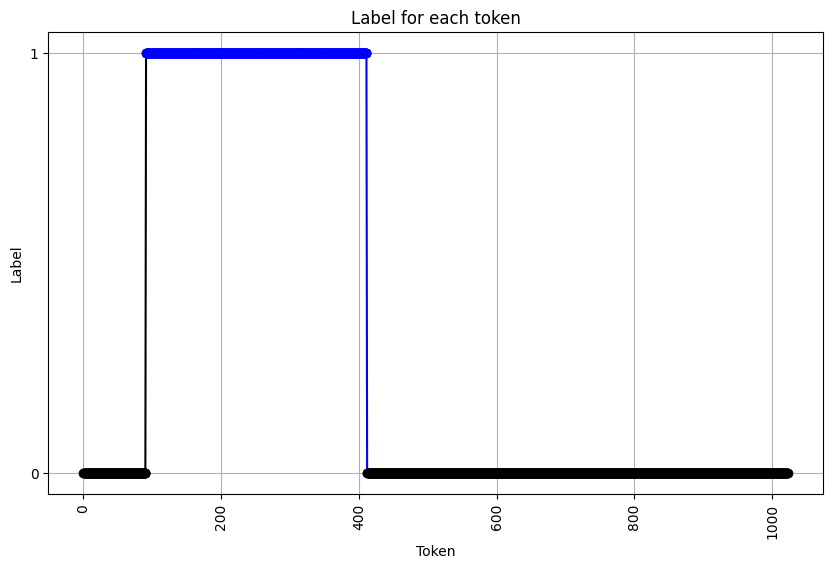



MSLSNLSSSNSNGAFLDYGEFRSGVYIQTSNQILYFTDENGNKVGYQWKGLLPHTTTTNDPNTDGGISDTAWCSIVGSGFIEKLSKEGIDLSWKAHLPTVEVSYNLPHKSLKIWEEGTISTDNDYWLYPGDGTVWNGVGVLGSIPDVPFKQIVPQNNVIEWSTIATEGQNQFTVPYEFTNISVFINGLLQNKSTGGYVVNGSTVTLNGSLKAGDVIHVVISNVHTTNIIYALQSDLNNYYTKTNLNSTSGSSYIGLTQGGTLDEAITYITPQMVNDTPYQTFGTALTSACNKAMANGIGEVRIPAGRYILDKTVDISMTKGLRLVFSPDAWILVKTPMTALKFFINKQHLNIEANGARIMADWGTTADGSQYAALDISDDTLDKSCSVTDLKVGFTGNKFGYGVYASCINLSTFHRCLLQANIGFYLESSLTNGATAHAMGVQIVNCEIYTTSDVIKIVNQGQLGCEGLLIEGGEFMGAGTGVRIVNEGLTSSSYLPPLFRIINNHFNCYQALYVKDVCRLVFSNNDVQSRHSSSKAVNGVLELGGVQGFQHNNNTYTSVLVGTGTNSDKTTPVYQFNSSLSNAYFSSTGNIYWLDGMTQPAYGFNGTTNVTIIESSNEILQSAASWTTSSYFQYFRPDNKTSIGNNGASVGLGRISSATLSSGVLTLSRAPAVGNTFTLPTSVVANTSSISQITCPSILVGKTISIQFSASEISFTHNTNLICPDGKSFKMWLPNVIQVYFLNTTQAIIMGVTGFNTISRNDISSAPTSKTSYGYAGAEYFDSTTKRLYKYIVGYGWVYTTMNDL
(1, 1.0)


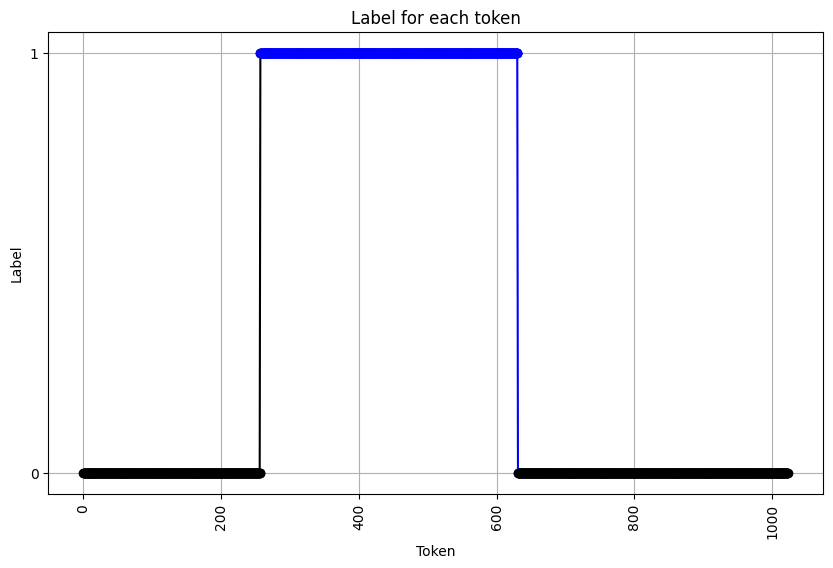



MFPIPSLFLLMAGGGTTPLPPGGVKKIAFSREQTSGVKRSMAILLTDGRLYTQGDNAWGECADGTTSPFYDHWKLAASNVADVFGVGKAFVVKYNSGGWQYAGDQGQFTGSTSNMMAWTSFPSSITGTVNLANLVSVVGGGGNTLWIMSNGTLYGSGPNANGCLGSGNSNPIPTPRTISTSCIRAFGLNACVTYLNNVGVPRVCGSTYGINGSFTPITSFASVTFPGATGTIYAKEWMCNEDNTIAIASAGASDTDHYLYTRGITTNNATYTKVSGFGPFTTFRVLDGGQSRFFIADDALYALGDSQRNLGLGDTTTSVTVPTVIPVPTGADWDLSKLTFVAEMKGDNMSQGATLGHWMVYDGNLFYTGSPKGFFGSTTIVGKFTNVPENSFEGIRADSITTGSIGVAIVGTTKQLTWSIDPPGAEIYDLQFSSSHPEFATIDANGLMTFVAEGGFDITMTAKTGTSATTLTDTSGGYVSTLGMATDSLSAMTVGETKQLVYTVTPAGVENLDGYSITFSSEDPAVATVSPTGLITAVADGGTRIHATAAVQTVTADDSSYLSVNAP
(1, 1.0)


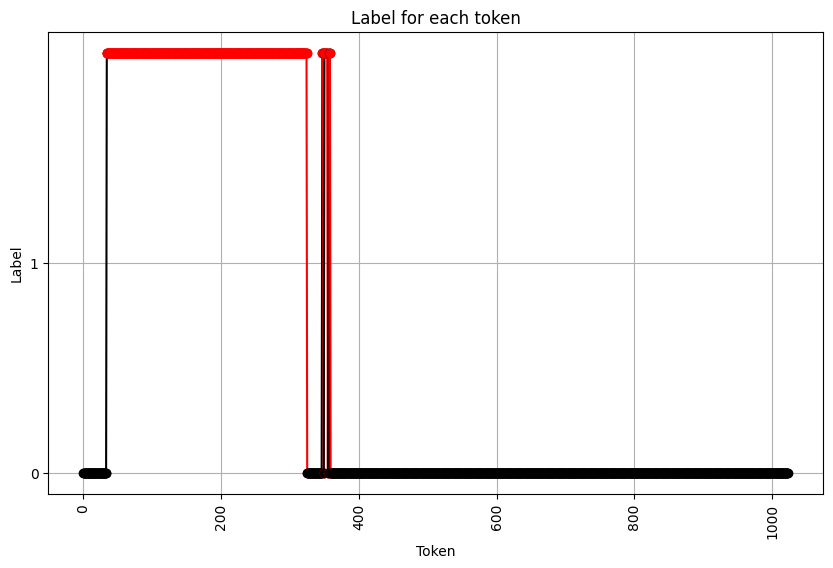



MPVLCTGFLICIKYSITNKGGNMLPFARMVKYGNIAPELILPKNRLQCSADAKFYLHTNGNLYWFGSSAYGQSGNGSLDSSTEWTLVNSNVTRYWGGVQGTIAIKKDGTIWYTGRRTVIPILSSNTNGVWVDITQNFTDFGVSADDIDSVVISSCMRVFLKNGKWFYCGAGTGGVFGNGSTSSVSRFTYSTIENVISAGCAIYSTGLVLNDGSYWYAGRTFVSGTTTQNLLTFTQDTSISNAIKAVNTNETSYIFLNDGNVKVASINDYGQAGTGNRSVAPMSTLIPNLSFQGEVELVGELGTNLTGPSCIINNNNKLFSCGLNSNGQCGIGTTDMYITSFAEMDLTALEGSNLSSFCKSYSYTMLVDEYNNLYTCGVPNLTGMSSTTVPTRVPDSLLPWK
(1, 1.0)


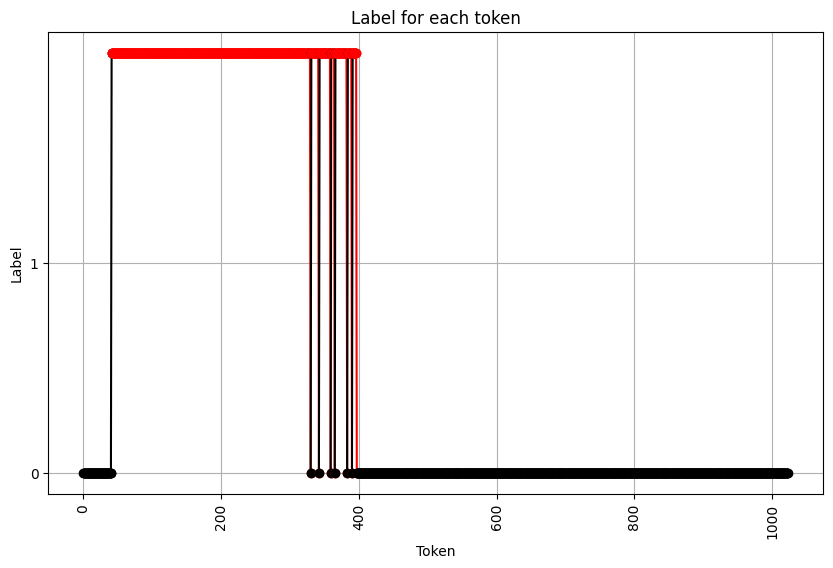

In [50]:
for seq in FP_seq :
    if len(seq) > 200 : 
        prediction, sequence_outputs = predict_sequence(model_classifier, str(seq))
        if prediction[0] == 1 :
            for ref_id in dpos_reference_dico :
                if str(dpos_reference_dico[ref_id]) == str(seq) :
                    print(ref_id)
            print(str(seq))
            print(prediction)
            plot_token(sequence_outputs)
            print("\n")

12 Divide and conquer<br>
14 real FN (mostly triple helix)
> Check the divide and conquer

In [25]:
fasta_DNC = SeqIO.parse(f"/media/concha-eloko/Linux/PhageDEPOdetection/Divide_Conquer.txt", "fasta")

def divide_and_conquer(fasta, window=1000, slide=250):
    sequences = []
    for i in range(0, len(fasta) - window + 1, slide):
        sequences.append(fasta[i:i+window])
    return sequences

for record in fasta_DNC :
    aa_seq = str(record.seq)
    aa_dnc = divide_and_conquer(aa_seq)
    for index, aa_div in enumerate(aa_dnc) :
        prediction, sequence_outputs = predict_sequence(model_classifier, aa_div)
        if prediction[0] == 1 :
            print(record.description , f"with a Dpo division : {index} fragment")
    

In [26]:
import pprint
pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = False)
pp.pprint(prediction_results)


{'AY349011.3.multi.faa': [((1, 1.0), 'lcl|AY349011.3_prot_AAQ54995.1_60'),
                          ((1, 1.0), 'lcl|AY349011.3_prot_AAQ55000.1_65')],
 'CP000711.1.multi.faa': [((1, 1.0), 'lcl|CP000711.1_prot_ABQ88383.1_2'),
                          ((1, 0.991202712059021), 'lcl|CP000711.1_prot_ABQ88395.1_14')],
 'DQ831957.1.multi.faa': [((1, 1.0), 'lcl|DQ831957.1_prot_ABI15697.1_20')],
 'DQ834250.1.multi.faa': [((1, 1.0), 'lcl|DQ834250.1_prot_ABI21803.1_19')],
 'FJ230960.1.multi.faa': [((1, 1.0), 'lcl|FJ230960.1_prot_ACI90991.1_86'),
                          ((1, 1.0), 'lcl|FJ230960.1_prot_ACI91003.1_98'),
                          ((1, 1.0), 'lcl|FJ230960.1_prot_ACI91006.1_101')],
 'FQ482084.1.multi.faa': [((1, 1.0), 'lcl|FQ482084.1_prot_CBX44498.1_37'),
                          ((1, 0.9999966621398926), 'lcl|FQ482084.1_prot_CBX44510.1_49')],
 'FR671405.1.multi.faa': [],
 'FR671406.1.multi.faa': [((1, 0.9979360103607178), 'lcl|FR671406.1_prot_CBW39009.1_42')],
 'FR671407.1.multi.f

***
### The alleged FP :

In [20]:
FP_seq = []
for seq in predicted_positives :
    if seq not in dpos_reference :
        FP_seq.append(seq)

In [22]:
p =0
for seq in FP_seq :
    if len(seq) > 400 :
        p += 1
len(FP_seq), p

(122, 83)

In [24]:
with open(f"/media/concha-eloko/Linux/PhageDEPOdetection/Dpos_reference.T12_FP..3L2007.multi.fasta", "w") as outfile : 
    for fasta_file in tqdm(os.listdir(path_out)) :
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            if str(record.seq) in FP_seq :
                outfile.write(f">{record.description}\n{record.seq}\n\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1510.59it/s]


In [ ]:
Make ESMfold on FP predictions 

rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/Dpos_reference.T12_FP.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/
